# 실험 시작

## 라이브러리 설치

In [3]:
# 기본 유틸
import os
import sys
import time
import gc
import warnings
import pickle
import json
import re
import random
import tempfile
import zlib
import olefile
import shutil
import subprocess
import uuid
import traceback
import csv
import hashlib
from datetime import datetime
from dotenv import load_dotenv
from getpass import getpass
from collections import Counter, defaultdict
from typing import List, Dict, Any
from difflib import SequenceMatcher
from concurrent.futures import ThreadPoolExecutor, as_completed

# PyTorch
import torch

# 데이터 처리
import numpy as np
import pandas as pd
import tiktoken

# 시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import koreanize_matplotlib
import plotly.express as px
from wordcloud import WordCloud
from PIL import Image

# 머신러닝 / 차원축소
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import Levenshtein

# PDF / HTML 처리
from pypdf import PdfReader, PdfWriter, errors
from bs4 import BeautifulSoup
import html2text
from markdownify import markdownify as md

# Docling
from docling.document_converter import DocumentConverter

# SentenceTransformers
from sentence_transformers import CrossEncoder, SentenceTransformer

# 한국어 형태소 분석
from kiwipiepy import Kiwi

# LangChain Core
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage

# LangChain Community
from langchain_community.retrievers import BM25Retriever
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import Qdrant
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# LangChain Classic
from langchain_classic.retrievers.ensemble import EnsembleRetriever

# LangChain Text Splitters
from langchain_text_splitters import (
    MarkdownHeaderTextSplitter,
    RecursiveCharacterTextSplitter
)
from langchain_experimental.text_splitter import SemanticChunker

# Upstage
from langchain_upstage import UpstageDocumentParseLoader, UpstageEmbeddings, ChatUpstage

# OpenAI
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

# HuggingFace / Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline

# Vector DB (Qdrant)
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_qdrant import QdrantVectorStore

# Jupyter Display
from IPython.display import display, Markdown, HTML

# Progress Bar
from tqdm import tqdm

# Windows COM (필요 시)
import win32com.client
import pythoncom

# 경고 무시
warnings.filterwarnings("ignore")

# 환경변수 로드
load_dotenv()

print("모든 라이브러리 정상 로드 완료")
print(f"PyTorch CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

모든 라이브러리 정상 로드 완료
PyTorch CUDA 사용 가능: True
   GPU: NVIDIA GeForce RTX 5070


# API KEY 설정

In [2]:
import os
from getpass import getpass
from dotenv import load_dotenv

# .env 파일 로드 (있다면)
load_dotenv()

# API 키 입력 (보안을 위해 getpass 사용)
print("API 키를 입력해주세요:")
print("-" * 50)

# HuggingFace Token
if not os.getenv("HF_TOKEN"):
    os.environ["HF_TOKEN"] = getpass("HuggingFace Token: ")

# OpenAI API Key
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

# Upstage API Key
if not os.getenv("UPSTAGE_API_KEY"):
    os.environ["UPSTAGE_API_KEY"] = getpass("Upstage API Key: ")

print("-" * 50)
print("모든 API 키 설정 완료")

# 확인 (앞 부분만 표시)
print("\n설정된 키 확인:")
for key_name in ["HF_TOKEN", "OPENAI_API_KEY", "UPSTAGE_API_KEY"]:
    value = os.getenv(key_name)
    if value:
        print(f"  • {key_name}: {value[:8]}...")
    else:
        print(f"  • {key_name}: 미설정")

API 키를 입력해주세요:
--------------------------------------------------
--------------------------------------------------
모든 API 키 설정 완료

설정된 키 확인:
  • HF_TOKEN: hf_EKqso...
  • OPENAI_API_KEY: sk-proj-...
  • UPSTAGE_API_KEY: up_nvYnp...


## 한글 설정

In [16]:
# ==========================================
# [설정] 1. 한글 폰트 강제 설정 (Windows/Mac)
# ==========================================
# 운영체제에 맞춰 폰트 설정
import platform
system_name = platform.system()

if system_name == 'Windows':
    # 윈도우는 '맑은 고딕'이 국룰
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif system_name == 'Darwin': # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    # 리눅스 등 (나눔고딕 설치 가정)
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

## 사업 단위 텍스트 추출 & 파싱 & 2차 CSV 생성

#### 1차 파싱(재형님: 클로버, GPT-4o로 파싱 시도, 승우님: Pymupdf, Pyplumber로 파싱 시도 두분 모두 pdf에서 모아찍기로 된 문서들은 제대로 파싱이 안됐음 upstage는 그거까지도 알아서 처리함을 확인)

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 1단계: PDF 원문 추출
# ==========================================================================================================
# 목표: 각 프로젝트 폴더에 있는 PDF 파일들을 Upstage API로 파싱하여 Markdown 텍스트로 변환
# 입력: data_list_v3_base.csv (프로젝트 메타데이터) + Files 폴더 (PDF 파일들)
# 출력: rfp_docs.csv (project_id, 공고번호, 사업명, full_text, 텍스트길이)
# 다음 단계: 이 full_text를 헤더 구조화 → 청킹 → 검색 인덱싱
# ==========================================================================================================

# ==========================================
# [설정] 경로
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
BASE_META_PATH = os.path.join(CSV_DIR, "data_list_v3_base.csv")  # 프로젝트 메타정보 (ID, 공고번호, 사업명 등)
FILES_ROOT_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\Files"  # PDF 파일이 담긴 루트 폴더
stats_csv_path = os.path.join(CSV_DIR, "rfp_docs.csv")  # 최종 결과물 저장 경로

# 동시 처리할 프로젝트 수 (API 상태에 따라 조절, 5~8 권장)
MAX_WORKERS = 7  # ThreadPoolExecutor로 7개 프로젝트를 동시에 처리 (API 호출 병렬화)

def parse_pdf(file_path, filename):
    """
    [핵심 함수] PDF 파일 하나를 Upstage API로 파싱
    
    역할: PDF → Markdown 텍스트 변환 (재시도 로직 포함)
    입력: file_path (PDF 절대 경로), filename (로그용 파일명)
    출력: "# [FILE: xxx.pdf]\n파싱된텍스트..." 또는 "" (실패 시)
    
    왜 필요한가: PDF는 그대로 읽으면 표/이미지 구조가 깨지므로 AI가 읽기 쉬운 Markdown으로 변환 필요
    """
    max_retries = 3  # 최대 3번 재시도 (API 일시 오류 대응)
    
    for attempt in range(max_retries):  # 0, 1, 2 (총 3번 시도)
        try:
            # [1] UpstageDocumentParseLoader 객체 생성
            loader = UpstageDocumentParseLoader(
                file_path,  # 파싱할 PDF 경로
                output_format="markdown",  # 출력 형식 (HTML 대신 Markdown 사용)
                coordinates=False  # 좌표 정보 불필요 (텍스트만 필요)
            )
            
            # [2] API 호출하여 파싱 실행 (Document 객체 리스트 반환)
            docs = loader.load()
            
            # [3] 여러 페이지를 하나의 문자열로 병합
            file_text = "\n\n".join([d.page_content for d in docs])  # 각 페이지 내용을 '\n\n'로 연결
            
            # [4] 파일명 헤더를 붙여서 반환 (나중에 어느 파일 내용인지 구분 가능)
            return f"\n\n# [FILE: {filename}]\n" + file_text
            
        except Exception as e:
            # [5] 예외 발생 시 처리
            if attempt == max_retries - 1:  # 마지막 시도(2번째)에서도 실패
                # 실패 정보 상세 출력
                error_type = type(e).__name__  # 예외 타입명 (예: TimeoutError)
                error_msg = str(e)  # 예외 메시지
                
                print(f"\n [최종 파싱 실패]")
                print(f"   파일명 : {filename}")
                print(f"   경로   : {file_path}")
                print(f"   원인   : {error_type}")
                print(f"   메시지 : {error_msg}")
                print("-" * 30)
                
                return ""  # 실패 시 빈 문자열 반환 (프로젝트 건너뛰기)
            else:
                # 재시도 전 2초 대기 (API 과부하 방지)
                time.sleep(2)
                
    return ""  # 모든 시도 실패 시 빈 문자열

def parse_project_worker(row_data):
    """
    [일꾼 함수] 프로젝트 하나를 처리 (ThreadPoolExecutor에서 병렬 실행됨)
    
    역할: 한 프로젝트 폴더 내 모든 PDF를 파싱하여 하나의 full_text로 병합
    입력: row_data (DataFrame의 한 행, project_id/공고번호/사업명 포함)
    출력: {"project_id": ..., "full_text": ..., ...} 또는 None (실패 시)
    
    왜 병렬인가: 프로젝트마다 독립적으로 API 호출하므로 동시에 처리해도 안전
    """
    # [1] 메타데이터 추출
    project_id = str(row_data['project_id']).strip()  # 프로젝트 고유 ID (폴더명과 일치)
    notice_num = row_data['공고 번호']  # 공고 번호 (메타데이터)
    title = row_data['사업명']  # 사업명 (메타데이터)
    
    # [2] 프로젝트 폴더 경로 구성
    folder_path = os.path.join(FILES_ROOT_DIR, project_id)  # 예: "Files/PMR-001"

    # [3] 폴더 존재 여부 확인 (없으면 스킵)
    if not os.path.exists(folder_path):
        return None  # None 반환 시 결과에서 제외됨

    # [4] 폴더 내 PDF 파일 목록 추출 (.pdf 확장자만)
    pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]
    if not pdf_files:
        return None  # PDF 없으면 스킵

    # [5] 프로젝트 내 모든 PDF를 순차적으로 파싱 (한 프로젝트 내에서는 순차 처리)
    full_text = ""  # 프로젝트 전체 텍스트를 담을 변수
    
    for f in pdf_files:  # 각 PDF 파일 반복
        # parse_pdf 함수 호출하여 파싱 (파일명 헤더 포함)
        full_text += parse_pdf(os.path.join(folder_path, f), f)

    # [6] 파싱 결과 검증 (최소 10자 이상이어야 유효한 텍스트로 판단)
    if len(full_text) > 10:
        # 딕셔너리로 결과 반환
        return {
            "project_id": project_id,  # 프로젝트 ID
            "공고 번호": notice_num,  # 공고번호
            "title": title,  # 사업명
            "full_text": full_text,  # 파싱된 전체 텍스트 (여러 PDF 병합)
            "char_len": len(full_text)  # 텍스트 길이 (통계용)
        }
    return None  # 파싱 실패 시 None

def main():
    """
    [메인 실행 함수] 전체 파이프라인 오케스트레이션
    
    흐름:
    1. CSV에서 프로젝트 목록 로드
    2. ThreadPoolExecutor로 병렬 파싱
    3. 결과 수집 및 CSV 저장
    """
    # [1] 메타데이터 CSV 존재 여부 확인
    if not os.path.exists(BASE_META_PATH):
        print(f"[에러] 메타 데이터 CSV가 없음: {BASE_META_PATH}")
        return

    # [2] CSV 로드 (project_id, 공고번호, 사업명 등 포함)
    df = pd.read_csv(BASE_META_PATH)
    results = []  # 파싱 성공한 프로젝트 결과를 담을 리스트
    
    # [3] 작업 정보 출력
    print(f"작업 시작: 총 {len(df)}개 프로젝트")
    print(f"동시 실행(Workers): {MAX_WORKERS}개")

    # ========================================================
    # [4] 프로젝트 단위 병렬 처리 실행 (핵심 부분!)
    # ========================================================
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # [4-1] 일감 배분: 각 프로젝트(행)마다 parse_project_worker 함수 실행 예약
        # future_to_pid: {Future객체: project_id} 매핑 (나중에 어느 프로젝트가 실패했는지 추적용)
        future_to_pid = {
            executor.submit(parse_project_worker, row): row['project_id'] 
            for idx, row in df.iterrows()  # 각 행을 순회하며 작업 제출
        }
        
        # [4-2] 결과 수집 (tqdm으로 진행률 표시)
        for future in tqdm(as_completed(future_to_pid), total=len(df), desc="Processing Projects"):
            try:
                # 완료된 작업의 결과 가져오기
                result = future.result()  # parse_project_worker의 반환값
                if result:  # None이 아니면 (파싱 성공)
                    results.append(result)  # 결과 리스트에 추가
            except Exception as e:
                # Worker 함수 내에서 예외 발생 시 (비상 방어 코드)
                pid = future_to_pid[future]  # 실패한 프로젝트 ID 찾기
                print(f"\n프로젝트({pid}) 처리 중 오류: {e}")

    # [5] 결과 저장
    if results:  # 파싱 성공한 프로젝트가 하나라도 있으면
        # [5-1] 리스트 → DataFrame 변환 (딕셔너리 키가 컬럼명이 됨)
        df_res = pd.DataFrame(results)
        
        # [5-2] CSV로 저장 (UTF-8 BOM, Excel 호환)
        df_res.to_csv(stats_csv_path, index=False, encoding="utf-8-sig")
        
        # [5-3] 완료 메시지 출력
        print("\n" + "="*50)
        print("작업 완료")
        print(f" 총 {len(results)}개 프로젝트 텍스트 추출 성공")
        print(f" 저장 경로: {stats_csv_path}")
        print("="*50)
    else:
        # 모든 프로젝트가 실패한 경우
        print("\n 추출된 데이터가 없음")

# [6] 스크립트 직접 실행 시에만 main() 호출 (모듈로 import될 때는 실행 안 됨)
if __name__ == "__main__":
    main()

# 업스테이지 2차 파싱

- 업스테이지는 h1(#, 대제목)만 표시 가능하고 h2, h3는 표시자체가 안됨
- 문서들의 제목 패턴들을 분석해서 수동으로 지정해주기로 함

## 업스테이지용 헤더 패턴 분석

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 1.5단계: 제목 패턴 분석 (헤더 구조화 준비)
# ==========================================================================================================
# 배경: Upstage API는 h1(대제목, #)만 자동 인식하고 h2(##), h3(###)는 인식하지 못함을 알게됨
# 문제: 청킹 시 h2/h3가 없으면 문서 구조를 제대로 파악할 수 없어 검색 품질 저하
# 해결책: 문서 내 제목처럼 생긴 패턴(1.1, 가., (1) 등)을 파악하고 수집하여 파싱할때 수동 헤더 규칙 생성
# 
# 흐름:
# 1. [이 단계] 제목 패턴 분석 → 패턴 빈도 확인 → 규칙 설계
# 2. [다음 단계] 규칙 기반 h2/h3 태그 자동 삽입
# 3. [최종 단계] MarkdownHeaderTextSplitter로 구조 기반 청킹
# ==========================================================================================================

# ==========================================
# [설정] 경로 (이전 단계와 동일)
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
BASE_META_PATH = os.path.join(CSV_DIR, "data_list_v3_base.csv")  # 프로젝트 메타정보
FILES_ROOT_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\Files"  # PDF 원본

def extract_title_patterns(text, limit=100):
    """
    [패턴 탐지 엔진] 텍스트에서 제목처럼 생긴 라인들을 추출
    
    역할: 정규식 기반 제목 패턴 매칭 (로마숫자, 제N장, 1.1 형식 등)
    입력: text (파싱된 Markdown 텍스트), limit (분석할 최대 줄 수)
    출력: [{'pattern': regex, 'text': '실제 제목 텍스트'}, ...]
    
    왜 필요한가: 문서마다 제목 스타일이 다르므로(1., 가., Ⅰ. 등) 패턴 빈도를 파악해야 규칙 생성 가능
    """
    lines = text.split('\n')  # 줄 단위로 분리
    patterns = []  # 발견된 패턴을 담을 리스트
    
    # [핵심] 제목 패턴 후보 정규식들 (한국어 공공문서에서 자주 사용되는 형식)
    title_regexes = [
        r'^[IⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩilvx]+[\.\s]',      # 로마숫자 (Ⅰ., Ⅱ., I., II. 등)
        r'^제\s*\d+\s*[장절조항]',                 # 제N장/절/조/항 (제1장, 제2절)
        r'^\d+\.\s',                              # 1. 2. 3. (숫자+점+공백)
        r'^\d+\.\d+\s',                           # 1.1 1.2 (2단계)
        r'^\d+\.\d+\.\d+\s',                      # 1.1.1 (3단계)
        r'^\d+\.\d+\.\d+\.\d+\s',                 # 1.1.1.1 (4단계)
        r'^[가-힣]\.\s',                          # 가. 나. 다. (한글+점)
        r'^\([가-힣]\)',                          # (가) (나) (다) (괄호+한글)
        r'^\(\d+\)',                              # (1) (2) (3) (괄호+숫자)
        r'^\[\d+\]',                              # [1] [2] [3] (대괄호+숫자)
        r'^\d+\)',                                # 1) 2) 3) (숫자+괄호)
        r'^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]',             # 동그라미 숫자 (①②③)
        r'^[-▪■□●○◆◇]\s',                       # 불릿 포인트 (-, •, ■ 등)
    ]
    
    # [1] 앞부분만 분석 (문서 앞쪽에 목차/구조가 집중되므로 limit 줄만 처리)
    for line in lines[:limit]:
        stripped = line.strip()  # 앞뒤 공백 제거
        
        # [2] 필터링: 빈 줄이거나 너무 긴 줄(100자 초과)은 제목이 아님
        if not stripped or len(stripped) > 100:
            continue
            
        # [3] 패턴 매칭: 정규식 리스트를 순회하며 첫 번째 매칭되는 패턴 사용
        for regex in title_regexes:
            if re.match(regex, stripped):  # 줄 시작 부분이 패턴과 일치하면
                # 매칭 성공: 패턴 정보와 실제 텍스트 저장
                patterns.append({
                    'pattern': regex,  # 어떤 정규식에 매칭되었는지 (통계용)
                    'text': stripped[:80]  # 실제 제목 텍스트 (80자까지만, 예시용)
                })
                break  # 첫 매칭 패턴만 기록하고 다음 줄로
    
    return patterns  # 발견된 패턴 리스트 반환


def analyze_one_file(project_id, folder_path, pdf_file):
    """
    [단일 파일 분석 워커] PDF 하나를 파싱하여 패턴 추출
    
    역할: ThreadPoolExecutor에서 병렬 실행될 개별 작업 단위
    입력: project_id, folder_path, pdf_file (파일 식별 정보)
    출력: {'success': True/False, 'patterns': [...], 'error': ...}
    
    왜 병렬인가: 파일마다 독립적이므로 동시에 여러 파일을 API 호출해도 안전
    """
    try:
        # [1] 파일 경로 구성
        file_path = os.path.join(folder_path, pdf_file)
        
        # [2] UpstageDocumentParseLoader로 PDF 파싱
        loader = UpstageDocumentParseLoader(
            file_path,
            output_format="markdown",  # Markdown 형식 출력
            coordinates=False,  # 좌표 불필요
            split="element"  # 요소 단위로 분리 (기본값)
        )
        docs = loader.load()  # API 호출하여 파싱 실행
        
        # [3] 여러 페이지를 하나의 텍스트로 병합
        text = "\n\n".join([d.page_content for d in docs])
        
        # [4] 패턴 추출 (각 파일당 앞 100줄만 분석)
        patterns = extract_title_patterns(text, limit=100)
        
        # [5] 성공 결과 반환
        return {
            'success': True,
            'project_id': project_id,  # 나중에 추적용
            'filename': pdf_file,
            'patterns': patterns  # 발견된 패턴 리스트
        }
        
    except Exception as e:
        # [6] 예외 발생 시 에러 정보 반환
        return {
            'success': False,
            'project_id': project_id,
            'filename': pdf_file,
            'error': str(e)[:200]  # 에러 메시지 (200자까지만)
        }


def analyze_sample_projects(sample_size=None, max_workers=7):
    """
    [파이프라인 오케스트레이터] 전체 프로젝트의 제목 패턴 분석 (병렬 처리)
    
    역할: 모든 PDF 파일을 병렬로 파싱하고 패턴 수집하여 통계 생성
    입력: sample_size (샘플링 개수, None이면 전체), max_workers (병렬 처리 수)
    출력: all_patterns (모든 파일에서 수집한 패턴 리스트)
    
    흐름:
    1. 프로젝트 목록 로드 (샘플링 또는 전체)
    2. 각 프로젝트 폴더 내 PDF 파일 목록 생성
    3. ThreadPoolExecutor로 병렬 파싱
    4. 결과 수집 및 에러 로깅
    """
    # [1] 메타데이터 CSV 로드
    df = pd.read_csv(BASE_META_PATH)
    
    # [2] 샘플링 또는 전체 분석 결정
    if sample_size:
        # 샘플링: 랜덤하게 N개 프로젝트만 선택
        sample_df = df.sample(n=min(sample_size, len(df)))
        print(f" {sample_size}개 프로젝트 샘플 분석 중...\n")
    else:
        # 전체 분석
        sample_df = df
        print(f" 전체 {len(df)}개 프로젝트 분석 중...\n")
    
    # [3] 작업 목록 생성 (각 PDF 파일이 하나의 작업)
    tasks = []  # [(project_id, folder_path, pdf_file), ...]
    for idx, row in sample_df.iterrows():  # 각 프로젝트 순회
        project_id = str(row['project_id']).strip()
        folder_path = os.path.join(FILES_ROOT_DIR, project_id)
        
        # 폴더 존재 여부 확인
        if not os.path.exists(folder_path):
            continue
            
        # PDF 파일 목록 추출
        pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]
        
        # 각 PDF 파일을 개별 작업으로 등록
        for pdf_file in pdf_files:
            tasks.append((project_id, folder_path, pdf_file))
    
    print(f" 총 {len(tasks)}개 파일 처리 예정\n")
    
    # [4] 결과 수집용 변수 초기화
    all_patterns = []  # 모든 패턴을 담을 리스트
    success_count = 0  # 성공 카운트
    error_records = []  # 에러 기록 (나중에 CSV 저장)
    
    # ========================================================
    # [5] 병렬 처리 실행 (핵심!)
    # ========================================================
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # [5-1] 작업 제출: 각 PDF 파일마다 analyze_one_file 실행 예약
        futures = {
            executor.submit(analyze_one_file, pid, path, fname): (pid, fname)
            for pid, path, fname in tasks
        }
        
        # [5-2] 결과 수집 (진행률 표시하며)
        for future in tqdm(as_completed(futures), total=len(tasks), desc="파일 분석"):
            result = future.result()  # analyze_one_file의 반환값
            
            if result['success']:
                # 성공: 패턴을 전체 리스트에 추가
                all_patterns.extend(result['patterns'])
                success_count += 1
            else:
                # 실패: 에러 정보 기록
                error_records.append({
                    'project_id': result['project_id'],
                    'filename': result['filename'],
                    'error': result['error']
                })
                # 실시간 에러 출력
                print(f"\n {result['project_id']}/{result['filename']}: {result['error']}")
    
    # [6] 에러 파일 CSV 저장 (에러가 있을 경우만)
    if error_records:
        error_df = pd.DataFrame(error_records)
        error_path = os.path.join(CSV_DIR, "title_pattern_errors.csv")
        error_df.to_csv(error_path, index=False, encoding='utf-8-sig')
        print(f"\n 에러 {len(error_records)}개 발생 → {error_path}")
    
    # [7] 완료 메시지
    print(f"\n 처리 완료: 성공 {success_count}개 / 실패 {len(error_records)}개")
    
    return all_patterns  # 수집된 모든 패턴 반환


def generate_pattern_report(patterns):
    """
    [리포트 생성기] 패턴 분석 결과를 통계와 예시로 정리
    
    역할: 수집된 패턴을 집계하여 빈도, 예시, CSV 저장
    입력: patterns (analyze_sample_projects가 반환한 패턴 리스트)
    출력: 콘솔 출력(빈도 통계 + 예시) + CSV 파일
    
    왜 필요한가: 어떤 패턴이 많이 사용되는지 알아야 h2/h3 규칙을 우선순위 있게 설계 가능
    """
    # [1] 패턴 없으면 종료
    if not patterns:
        print(" 패턴이 발견되지 않음")
        return
    
    # [2] 패턴별 빈도 계산 (Counter 사용)
    # 각 패턴(정규식)이 몇 번 등장했는지 집계
    pattern_types = Counter([p['pattern'] for p in patterns])
    
    # [3] 빈도 통계 출력
    print("\n" + "="*60)
    print(" 제목 패턴 빈도 분석")
    print("="*60)
    
    # 정규식 → 사람이 읽기 쉬운 이름으로 매핑
    pattern_names = {
        r'^[IⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩilvx]+[\.\s]': '로마숫자 (Ⅰ, Ⅱ, Ⅲ)',
        r'^제\s*\d+\s*[장절조항]': '제N장/절/조',
        r'^\d+\.\s': '1. 형식',
        r'^\d+\.\d+\s': '1.1 형식',
        r'^\d+\.\d+\.\d+\s': '1.1.1 형식',
        r'^\d+\.\d+\.\d+\.\d+\s': '1.1.1.1 형식',
        r'^[가-힣]\.\s': '가. 형식',
        r'^\([가-힣]\)': '(가) 형식',
        r'^\(\d+\)': '(1) 형식',
        r'^\[\d+\]': '[1] 형식',
        r'^\d+\)': '1) 형식',
        r'^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]': '동그라미 숫자',
        r'^[-▪■□●○◆◇]\s': '불릿 포인트',
    }
    
    # 빈도 높은 순서대로 출력
    for pattern, count in pattern_types.most_common():
        name = pattern_names.get(pattern, pattern)  # 이름 매핑 (없으면 정규식 그대로)
        percentage = (count / len(patterns)) * 100  # 비율 계산
        print(f"{count:4d}회 ({percentage:5.1f}%) | {name}")
    
    # [4] 실제 제목 예시 출력 (각 패턴별로 3개씩)
    print("\n" + "="*60)
    print(" 실제 제목 예시 (각 패턴별 3개)")
    print("="*60)
    
    # 패턴별로 실제 텍스트 예시 추출
    for pattern in pattern_types.keys():
        # 해당 패턴에 매칭된 텍스트들 중 3개만 추출
        examples = [p['text'] for p in patterns if p['pattern'] == pattern][:3]
        name = pattern_names.get(pattern, pattern)
        
        # 예시 출력
        print(f"\n[{name}]")
        for ex in examples:
            print(f"  • {ex}")
    
    # [5] CSV로 상세 결과 저장 (모든 패턴 정보)
    df_patterns = pd.DataFrame(patterns)  # [{'pattern': ..., 'text': ...}, ...] → DataFrame
    output_path = os.path.join(CSV_DIR, "title_patterns_analysis.csv")
    df_patterns.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"\n 상세 결과 저장: {output_path}")


# ========================================================
# [메인 실행] 스크립트 직접 실행 시
# ========================================================
if __name__ == "__main__":
    # [1] 시작 메시지
    print("="*60)
    print(" 전체 RFP 문서 제목 패턴 분석 시작")
    print("="*60 + "\n")
    
    # [2] 전체 프로젝트 분석 (sample_size=None → 전체)
    # 샘플링하려면 sample_size=10 같이 숫자 지정
    patterns = analyze_sample_projects(sample_size=None)
    
    # [3] 리포트 생성 (빈도 통계 + 예시 + CSV 저장)
    generate_pattern_report(patterns)

 전체 RFP 문서 제목 패턴 분석 시작

 전체 98개 프로젝트 분석 중...

총 254개 파일 처리 예정



파일 분석: 100%|██████████| 254/254 [20:54<00:00,  4.94s/it] 


처리 완료: 성공 254개 실패 0개

 제목 패턴 빈도 분석
6053회 ( 69.0%) | 불릿 포인트
1341회 ( 15.3%) | 1. 형식
 388회 (  4.4%) | 가. 형식
 330회 (  3.8%) | 로마숫자 (Ⅰ, Ⅱ, Ⅲ)
 273회 (  3.1%) | 동그라미 숫자
 257회 (  2.9%) | 제N장/절/조
  71회 (  0.8%) | 1) 형식
  41회 (  0.5%) | 1.1 형식
   7회 (  0.1%) | (가) 형식
   6회 (  0.1%) | (1) 형식

 실제 제목 예시 (각 패턴별 3개)

[불릿 포인트]
  • - 가. 공 고 명 : 한영대학교 특성화 맞춤형 교육환경 구축 – 트랙운영 학사정보시스템 고도화
  • - 나. 사업기간 : 계약일로부터 3개월(안정화기간 1개월 포함)
  • - 다. 사업예산 : 일금 일억삼천만원정 (\130,000,000) 부가세포함

[가. 형식]
  • 가. 국가를 당사자로 하는 계약에 관한 법률 시행령」제43조에 따라 협상에 의한 계약체결 방식
  • 가. 「지방자치단체를 당사자로 하는 계약에 관한 법률(이하 지방계약법) 시행령」제13조 및
  • 가. 가격입찰(전자) 제출기간 : 2024. 10. 14.(월) 10:00 ~ 2024. 10. 16.(수) 14:00

[제N장/절/조]
  • 제12조(수의계약 체결 제한) ① 공공기관(공공기관으로부터 출연금 · 보조금 등을 받거
  • 제43조 및 제44조의 규정에 의하여『봉화군 재난통합관리시스템 고도화 사업』의
  • 제88조에 의거 면허보완을 위하여 공동도급[(공동 또는 분담이행)이행방식,

[1. 형식]
  • 1. 소속 고위공직자
  • 2. 해당 계약업무를 법령상 · 사실상 담당하는 소속 공직자
  • 3. 해당 산하 공공기관의 감독기관 소속 고위공직자

[동그라미 숫자]
  • ② 제1항제1호부터 제6호까지의 어느 하나에 해당하는 공직자는 제1항을 위반하여
  • ③ 문서 상호 간에 모순이 있을 경우 계약특수조건,

## 2차 파싱(업스테이지 헤더 구조 보강)

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2단계: PDF 파싱 + 헤더 구조 복원
# ==========================================================================================================
# 배경: 1단계에서 Upstage API는 h1(#)만 인식하여 h2/h3 구조가 깨짐
# 문제: 청킹 시 문서 계층 구조를 활용하지 못해 검색 품질 저하
# 해결: 1.5단계 패턴 분석 결과를 기반으로 h2/h3/h4 헤더를 규칙 기반으로 자동 삽입
#
# 입력: PDF 파일들 (1단계와 동일)
# 출력: rfp_docs_v2.csv (헤더 구조가 복원된 full_text)
# ==========================================================================================================

# ==========================================
# [설정] 경로
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
BASE_META_PATH = os.path.join(CSV_DIR, "data_list_v3_base.csv")  # 프로젝트 메타정보
FILES_ROOT_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\Files"  # PDF 원본
stats_csv_path = os.path.join(CSV_DIR, "rfp_docs_v2.csv")  # 최종 결과 (v2 = 헤더 복원 버전)

# 동시 처리할 프로젝트 수 (API 상태에 따라 조절, 5~8 권장)
MAX_WORKERS = 7


def fix_upstage_headers(text):
    """
    [핵심 함수] Upstage 파싱 결과의 헤더 구조를 제대로 복원
    
    역할: 제목 패턴을 정규식으로 감지하여 적절한 Markdown 헤더(#, ##, ###, ####) 삽입
    입력: text (Upstage API가 파싱한 Markdown 텍스트, h1만 있음)
    출력: text (h2/h3/h4가 추가된 계층 구조 Markdown)
    
    왜 필요한가: 
    - Upstage는 h1만 인식 → 문서 구조 깨짐
    - MarkdownHeaderTextSplitter는 헤더 기반 청킹 → 구조 없으면 의미 단위 분리 불가
    - 패턴 분석(1.5단계)에서 발견한 제목 형식을 규칙으로 변환
    
    처리 내용:
    1. 불릿 제거: "- 가." → "가." (Upstage가 불필요한 불릿을 추가하는 경우 대응)
    2. 패턴 기반 헤더 레벨 할당:
       - h1 (#): 제N장, 로마숫자 (Ⅰ, Ⅱ, I, II, ...) → 대제목
       - h2 (##): 1. 형식, 제N절 → 중제목
       - h3 (###): 가. 형식, 1) 형식, 1.1 형식, (가) 형식, ① 형식 → 소제목
       - h4 (####): 1.1.1 형식 → 세부 항목
    """
    lines = text.split('\n')  # 줄 단위로 분리
    result = []  # 결과를 담을 리스트
    
    for line in lines:
        original_line = line  # 원본 보존 (헤더 아니면 그대로 사용)
        stripped = line.strip()  # 앞뒤 공백 제거
        
        # [1] 빈 줄은 그대로 유지
        if not stripped:
            result.append(original_line)
            continue
        
        # ========================================================
        # [2] Step 1: 불릿 제거 (Upstage가 자동 추가한 경우 대응)
        # ========================================================
        if stripped.startswith('- '):  # "- " 패턴
            stripped = stripped[2:].strip()  # "- " 제거
        elif stripped.startswith('-'):  # "-" 패턴 (공백 없음)
            stripped = stripped[1:].strip()  # "-" 제거
        
        # ========================================================
        # [3] Step 2: 헤더 레벨 할당 (우선순위 순서대로)
        # ========================================================
        # 주의: 위에서부터 순서대로 검사하므로 더 구체적인 패턴이 먼저 와야 함
        # 예: "1.1" 검사 → "1." 검사 순서 (반대면 "1.1"도 "1."로 매칭됨)
        
        # [h1] 대제목: 제N장, 로마숫자 (Ⅰ, Ⅱ, I, II, ...)
        if re.match(r'^제\s*\d+\s*장', stripped):  # "제1장", "제 2 장"
            result.append(f"# {stripped}")
        elif re.match(r'^[IⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩ]+[\.\s]', stripped, re.IGNORECASE):  # "I.", "Ⅰ.", "II "
            result.append(f"# {stripped}")
            
        # [h2] 중제목: 제N절, 제N조, 1. 형식
        elif re.match(r'^제\s*\d+\s*절', stripped):  # "제1절"
            result.append(f"## {stripped}")
        elif re.match(r'^제\s*\d+\s*조', stripped):  # "제1조"
            result.append(f"## {stripped}")
        elif re.match(r'^\d+\.\s', stripped) and not re.match(r'^\d+\.\d+', stripped):
            # "1. " 형식 (단, "1.1"이 아닌 경우만)
            # 조건: 숫자 + 점 + 공백으로 시작하되, 소수점이 아님
            result.append(f"## {stripped}")
            
        # [h3] 소제목: 가. 형식, 1) 형식, 1.1 형식, (가) 형식, ① 형식
        elif re.match(r'^[가-힣]\.\s', stripped):  # "가. ", "나. "
            result.append(f"### {stripped}")
        elif re.match(r'^\d+\)\s', stripped):  # "1) ", "2) "
            result.append(f"### {stripped}")
        elif re.match(r'^\d+\.\d+\s', stripped) and not re.match(r'^\d+\.\d+\.\d+', stripped):
            # "1.1 " 형식 (단, "1.1.1"이 아닌 경우만)
            result.append(f"### {stripped}")
        elif re.match(r'^\([가-힣]\)', stripped):  # "(가)", "(나)"
            result.append(f"### {stripped}")
        elif re.match(r'^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳]', stripped):  # "①", "②"
            result.append(f"### {stripped}")
            
        # [h4] 세부 항목: 1.1.1 형식, 1.1.1.1 형식
        elif re.match(r'^\d+\.\d+\.\d+', stripped):  # "1.1.1", "1.1.1.1"
            result.append(f"#### {stripped}")
            
        # [h3] 제N항 (소제목 수준)
        elif re.match(r'^제\s*\d+\s*항', stripped):  # "제1항"
            result.append(f"### {stripped}")
            
        # [기본] 나머지는 원본 유지 (본문 텍스트)
        else:
            result.append(original_line)
    
    # [4] 줄 단위 리스트를 다시 문자열로 병합
    return '\n'.join(result)


def parse_pdf(file_path, filename):
    """
    [핵심 함수] PDF 파일 하나를 파싱 + 헤더 복원
    
    역할: Upstage API 호출 → 헤더 복원 후처리 (재시도 로직 포함)
    입력: file_path, filename
    출력: "# [FILE: xxx.pdf]\n파싱+헤더복원된텍스트..." 또는 "" (실패 시)
    
    변경점: 기존 parse_pdf에 fix_upstage_headers 호출 추가됨
    """
    max_retries = 3  # 최대 3번 재시도
    
    for attempt in range(max_retries):  # 0, 1, 2 (총 3번)
        try:
            # [1] Upstage API 호출하여 PDF → Markdown 변환
            loader = UpstageDocumentParseLoader(
                file_path,
                output_format="markdown",
                coordinates=False
            )
            docs = loader.load()
            
            # [2] 여러 페이지를 하나의 텍스트로 병합
            file_text = "\n\n".join([d.page_content for d in docs])
            
            # ========================================================
            # [3] 헤더 구조 복원 (핵심 추가 부분)
            # ========================================================
            file_text = fix_upstage_headers(file_text)
            
            # [4] 파일명 헤더를 붙여서 반환
            return f"\n\n# [FILE: {filename}]\n" + file_text
            
        except Exception as e:
            # [5] 예외 처리 (재시도 로직)
            if attempt == max_retries - 1:  # 마지막 시도에서도 실패
                error_type = type(e).__name__
                error_msg = str(e)
                
                print(f"\n [최종 파싱 실패]")
                print(f"   파일명 : {filename}")
                print(f"   경로   : {file_path}")
                print(f"   원인   : {error_type}")
                print(f"   메시지 : {error_msg}")
                print("-" * 30)
                
                return ""  # 실패 시 빈 문자열
            else:
                # 재시도 전 2초 대기
                time.sleep(2)
                
    return ""


def parse_project_worker(row_data):
    """
    [일꾼 함수] 프로젝트 하나를 처리 (ThreadPoolExecutor에서 병렬 실행)
    
    역할: 한 프로젝트 폴더 내 모든 PDF를 파싱하여 하나의 full_text로 병합
    입력: row_data (DataFrame의 한 행)
    출력: {"project_id": ..., "full_text": ..., ...} 또는 None
    
    변경점: 없음 (parse_pdf가 내부적으로 헤더 복원 처리)
    """
    # [1] 메타데이터 추출
    project_id = str(row_data['project_id']).strip()
    notice_num = row_data['공고 번호']
    title = row_data['사업명']
    
    # [2] 프로젝트 폴더 경로 구성
    folder_path = os.path.join(FILES_ROOT_DIR, project_id)

    # [3] 폴더 존재 여부 확인
    if not os.path.exists(folder_path):
        return None

    # [4] PDF 파일 목록 추출
    pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]
    if not pdf_files:
        return None

    # [5] 프로젝트 내 모든 PDF를 순차적으로 파싱 (헤더 복원 포함)
    full_text = ""
    
    for f in pdf_files:
        full_text += parse_pdf(os.path.join(folder_path, f), f)

    # [6] 파싱 결과 검증
    if len(full_text) > 10:
        return {
            "project_id": project_id,
            "공고 번호": notice_num,
            "title": title,
            "full_text": full_text,  # 헤더 복원된 텍스트
            "char_len": len(full_text)
        }
    return None


def main():
    """
    [메인 실행 함수] 전체 파이프라인 오케스트레이션
    
    흐름: 1단계와 동일하나 출력 파일이 rfp_docs_v2.csv (헤더 복원 버전)
    """
    # [1] 메타데이터 CSV 존재 여부 확인
    if not os.path.exists(BASE_META_PATH):
        print(f"[에러] 메타 데이터 CSV가 없음: {BASE_META_PATH}")
        return

    # [2] CSV 로드
    df = pd.read_csv(BASE_META_PATH)
    results = []
    
    # [3] 작업 정보 출력
    print("="*60)
    print(" Upstage + 헤더 복원 파싱 시작")
    print("="*60)
    print(f" 총 {len(df)}개 프로젝트")
    print(f"  동시 실행: {MAX_WORKERS}개 워커")
    print(f" 기능: API 파싱 + 제목 계층 구조 복원\n")

    # ========================================================
    # [4] 프로젝트 단위 병렬 처리 실행
    # ========================================================
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # [4-1] 일감 배분
        future_to_pid = {
            executor.submit(parse_project_worker, row): row['project_id'] 
            for idx, row in df.iterrows()
        }
        
        # [4-2] 결과 수집 (tqdm 진행률 표시)
        for future in tqdm(as_completed(future_to_pid), total=len(df), desc="프로젝트 처리"):
            try:
                result = future.result()
                if result:
                    results.append(result)
            except Exception as e:
                pid = future_to_pid[future]
                print(f"\n  프로젝트({pid}) 처리 중 오류: {e}")

    # [5] 결과 저장
    if results:
        # [5-1] DataFrame 변환
        df_res = pd.DataFrame(results)
        
        # [5-2] CSV로 저장 (v2 = 헤더 복원 버전)
        df_res.to_csv(stats_csv_path, index=False, encoding="utf-8-sig")
        
        # [5-3] 완료 메시지
        print("\n" + "="*60)
        print(" 작업 완료")
        print(f"   총 {len(results)}개 프로젝트 텍스트 추출 성공")
        print(f"    저장 경로: {stats_csv_path}")
        print("="*60)
    else:
        print("\n 추출된 데이터가 없음")


# [6] 스크립트 직접 실행 시에만 main() 호출
if __name__== "__main__":
    main()

 Upstage + 헤더 복원 파싱 시작
총 98개 프로젝트
동시 실행: 7개 워커
기능: API 파싱 + 제목 계층 구조 복원



프로젝트 처리: 100%|██████████| 98/98 [32:16<00:00, 19.76s/it]  



 작업 완료
   총 98개 프로젝트 텍스트 추출 성공
   저장 경로: C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV\rfp_docs_v2.csv


## 통합 페이지들 EDA

In [5]:
# ==========================================
# [설정] 경로 및 모델 기준
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
FILES_ROOT_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\Files"

base_df = pd.read_csv(os.path.join(CSV_DIR, "data_list_v3_base.csv"))
df = pd.read_csv(os.path.join(CSV_DIR, "rfp_docs_v2.csv"))

print("원본 CSV 프로젝트 수:", len(base_df))
print("통합 CSV 프로젝트 수:", len(df))

print("\n[컬럼 확인]")
print(df.columns)

print("\n[결측치 확인]")
print(df.isnull().sum())

print("\n[char_len == 0 확인]")
print((df['char_len'] == 0).sum())

print("\n[글자수 통계]")
print(df['char_len'].describe())

print("\n[랜덤 샘플 3개]")
print(df.sample(3)[['project_id','title','char_len','full_text']])

print("\n[중복 project_id 확인]")
print(df['project_id'].duplicated().sum())

print("\n[폴더 개수 vs CSV 프로젝트 수]")
folder_projects = [f for f in os.listdir(FILES_ROOT_DIR) if os.path.isdir(os.path.join(FILES_ROOT_DIR,f))]
print("폴더 개수:", len(folder_projects))
print("CSV 프로젝트 수:", len(df))

print("\n[폴더 vs CSV 프로젝트 일치 확인]")
for folder in folder_projects:
    if folder not in df['project_id'].values:
        print(f"폴더 {folder}가 CSV에 없음")

원본 CSV 프로젝트 수: 98
통합 CSV 프로젝트 수: 98

[컬럼 확인]
Index(['project_id', '공고 번호', 'title', 'full_text', 'char_len'], dtype='object')

[결측치 확인]
project_id    0
공고 번호         0
title         0
full_text     0
char_len      0
dtype: int64

[char_len == 0 확인]
0

[글자수 통계]
count        98.000000
mean     125531.989796
std       53654.136906
min       58717.000000
25%       91287.750000
50%      111595.000000
75%      145625.750000
max      360160.000000
Name: char_len, dtype: float64

[랜덤 샘플 3개]
   project_id                               title  char_len  \
76   proj_078    인천공항운영서비스㈜ 차세대 ERP시스템 구축 사업(재공고)     84397   
50   proj_048  사업장 사회보험료 지원 고시 개정에 따른 정보시스템 보완 개발    110681   
93   proj_093                 산단 안전정보시스템 1차 구축 용역    141200   

                                            full_text  
76  \n\n# [FILE: 20240624332-00_1718692539796_입찰공고...  
50  \n\n# [FILE: 20240603877-00_1717484363984_(공고서...  
93  \n\n# [FILE: 20240408874-00_1712210907716_공고문(...  

[중복 project_id 확인]
0

[폴더 개수 vs CS

In [ ]:
# 순서 정렬
df = df.sort_values('project_id').reset_index(drop=True)
df.to_csv(stats_csv_path, index=False, encoding="utf-8-sig")
print("깔끔하게 번호순으로 정렬해서 다시 저장")

깔끔하게 번호순으로 정렬해서 다시 저장


### 토큰 수 분석

 데이터 로드 완료: 98개 프로젝트
 tiktoken으로 토큰 수 계산 중...
 tiktoken 계산 완료

 [토큰 통계]
count        98.0
mean     111194.8
std       48781.2
min       52372.0
25%       80867.5
50%       98023.5
75%      127531.8
max      334330.0
Name: token_count, dtype: float64

[상위 분포]
0.25     80867.50
0.50     98023.50
0.75    127531.75
0.90    174802.50
0.95    203830.05
0.99    279902.33
Name: token_count, dtype: float64

 [text-embedding-3-small 분석]
토큰 제한: 8,191 토큰
 통과: 0개 문서 (0.0%)
 초과: 98개 문서 (100.0%)

 98개 문서는 청킹 필요


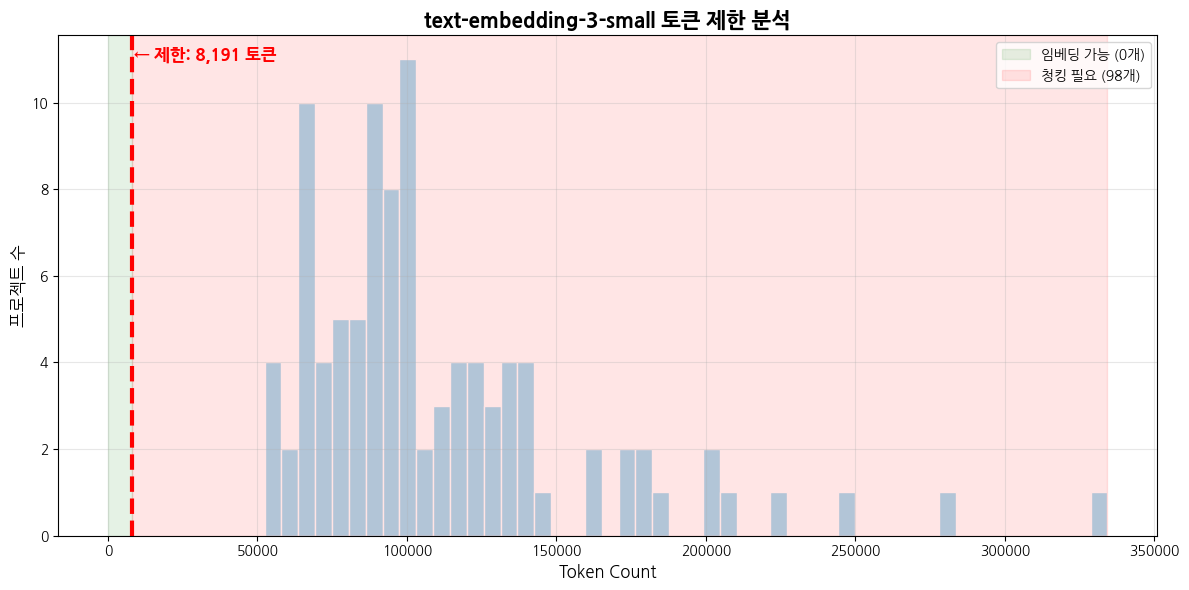


 토큰이 가장 많은 프로젝트 TOP 5

project_id      title                                          토큰 수         상태
--------------------------------------------------------------------------------
proj_033        모바일오피스 시스템 고도화 용역(총체 및 1차)                  334,330         초과
proj_016        예약발매시스템 개량 ISMP 용역                          278,219         초과
proj_069        철도인프라 디지털트윈 정보화전략계획(ISP) 수립 용역(변경공고         248,456         초과
proj_070        [재공고][긴급][협상형]운행정보기록 자동분석시스템 개량             222,126         초과
proj_008        차세대 포털·학사 정보시스템 구축사업                        208,409         초과


In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2.5단계: 토큰 수 분석 (EDA - 청킹 전략 수립)
# ==========================================================================================================
# 배경: 임베딩 모델(text-embedding-3-small)은 최대 8191 토큰까지만 처리 가능
# 문제: 이 제한을 초과하는 문서는 임베딩 생성 시 오류 발생
# 해결: 전체 문서의 토큰 분포를 분석하여 청킹 전략 수립
#
# 분석 목표:
# 1. 몇 개 문서가 8191 토큰을 초과하는가?
# 2. 초과 문서는 청킹이 필요, 그렇지 않으면 전체 임베딩 가능
# 3. 청킹 파라미터(chunk_size, overlap) 설정 근거 마련
#
# 입력: rfp_docs_v2.csv (헤더 복원된 full_text)
# 출력: 통계, 시각화, TOP 5 문서 (청킹 전략 결정 근거)
# 다음 단계: 분석 결과를 바탕으로 RecursiveCharacterTextSplitter 파라미터 설정
# ==========================================================================================================

# ==========================================
# [설정] 경로 및 임베딩 모델 기준
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
stats_csv_path = os.path.join(CSV_DIR, "rfp_docs_v2.csv")  # 헤더 복원된 버전

# text-embedding-3-small 토큰 제한 (OpenAI 공식 스펙)
EMBEDDING_LIMIT = 8191  # 이 값을 초과하면 임베딩 API 오류 발생

# ==========================================
# [1] 데이터 로드 및 토큰 계산
# ==========================================
if not os.path.exists(stats_csv_path):
    # CSV 파일이 없으면 종료 (2단계 파싱이 먼저 실행되어야 함)
    print(f" 파일이 없음: {stats_csv_path}")
else:
    # [1-1] CSV 로드
    df = pd.read_csv(stats_csv_path)
    print(f" 데이터 로드 완료: {len(df)}개 프로젝트")

    # ========================================================
    # [1-2] tiktoken으로 정확한 토큰 수 계산
    # ========================================================
    # 왜 tiktoken인가:
    # - 일반 문자 수나 단어 수는 부정확 (한글, 특수문자 토큰화 규칙 다름)
    # - OpenAI 임베딩 모델과 동일한 토크나이저 사용해야 정확
    # - cl100k_base: GPT-3.5, GPT-4, text-embedding-3 공통 인코딩
    
    print(" tiktoken으로 토큰 수 계산 중...")
    tokenizer = tiktoken.get_encoding("cl100k_base")  # OpenAI 표준 토크나이저
    
    # 결측치 처리 (full_text가 NaN이면 빈 문자열로)
    df['full_text'] = df['full_text'].fillna("")
    
    # 각 문서의 토큰 수 계산 (apply로 전체 행에 적용)
    # tokenizer.encode(): 텍스트 → 토큰 ID 리스트 변환 (예: "안녕" → [12345, 67890])
    # len(): 토큰 개수 계산
    df['token_count'] = df['full_text'].apply(lambda x: len(tokenizer.encode(str(x))))
    
    print(f" tiktoken 계산 완료")

    # ==========================================
    # [2] 기초 통계 (요약 통계량)
    # ==========================================
    # describe(): 평균, 표준편차, 최소/최대, 사분위수 자동 계산
    desc_stats = df['token_count'].describe().round(1)
    
    # 추가 분위수 계산 (상위 분포 확인용)
    # quantile(0.9): 상위 10% 문서의 토큰 수
    # quantile(0.99): 상위 1% 문서의 토큰 수 (극단값 확인)
    quantiles = df['token_count'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # 결과 출력
    print("\n" + "="*60)
    print(" [토큰 통계]")
    print("="*60)
    print(desc_stats)  # count, mean, std, min, 25%, 50%, 75%, max
    print("\n[상위 분포]")
    print(quantiles)  # 90%, 95%, 99% 지점의 토큰 수

    # ==========================================
    # [3] text-embedding-3-small 수용 분석 (핵심!)
    # ==========================================
    # 목적: 몇 개 문서가 임베딩 제한(8191)을 초과하는지 파악
    # 결과에 따라 청킹 전략 결정
    
    # [3-1] 초과/통과 문서 개수 계산
    over_count = (df['token_count'] > EMBEDDING_LIMIT).sum()  # 8191 초과 문서 개수
    pass_count = len(df) - over_count  # 8191 이하 문서 개수
    pass_ratio = (pass_count / len(df)) * 100  # 통과 비율
    
    # [3-2] 결과 출력
    print("\n" + "="*60)
    print(" [text-embedding-3-small 분석]")
    print("="*60)
    print(f"토큰 제한: {EMBEDDING_LIMIT:,} 토큰")
    print(f" 통과: {pass_count}개 문서 ({pass_ratio:.1f}%)")
    print(f"  초과: {over_count}개 문서 ({100-pass_ratio:.1f}%)")
    
    # [3-3] 전략 제안
    if over_count > 0:
        # 초과 문서가 있으면 청킹 필수
        print(f"\n {over_count}개 문서는 청킹 필요")
    else:
        # 모든 문서가 제한 이하면 전체 문서 임베딩 가능 (청킹 불필요)
        print(f"\n 모든 문서 임베딩 가능 (청킹 불필요)")
    print("="*60)

    # ==========================================
    # [4] 시각화 (히스토그램 + 제한선)
    # ==========================================
    # 목적: 토큰 분포를 시각적으로 확인하여 청킹 전략 수립
    
    plt.figure(figsize=(12, 6))  # 그래프 크기 설정
    
    # [4-1] 히스토그램 그리기 (토큰 분포)
    # bins=50: 토큰 범위를 50개 구간으로 나눔
    sns.histplot(df['token_count'], bins=50, color='skyblue', edgecolor='white', alpha=0.7)
    
    # [4-2] text-embedding-3-small 제한선 표시 (빨간 점선)
    y_max = plt.ylim()[1]  # Y축 최대값 (텍스트 위치 계산용)
    plt.axvline(EMBEDDING_LIMIT, color='red', linestyle='--', linewidth=3)  # 세로 점선
    plt.text(EMBEDDING_LIMIT + 500, y_max * 0.95, f'← 제한: {EMBEDDING_LIMIT:,} 토큰', 
             color='red', fontweight='bold', fontsize=12)  # 제한 라벨
    
    # [4-3] 통과/초과 영역 색상 표시
    # axvspan: X축 범위에 색상 채우기
    plt.axvspan(0, EMBEDDING_LIMIT, alpha=0.1, color='green', label=f'임베딩 가능 ({pass_count}개)')  # 초록 영역 (안전)
    if over_count > 0:
        plt.axvspan(EMBEDDING_LIMIT, df['token_count'].max(), alpha=0.1, color='red', 
                    label=f'청킹 필요 ({over_count}개)')  # 빨간 영역 (청킹 필요)

    # [4-4] 그래프 꾸미기
    plt.title('text-embedding-3-small 토큰 제한 분석', fontsize=15, fontweight='bold')
    plt.xlabel('Token Count', fontsize=12)
    plt.ylabel('프로젝트 수', fontsize=12)
    plt.legend(loc='upper right')  # 범례 위치
    plt.grid(True, alpha=0.3)  # 격자선 (투명도 30%)
    
    plt.tight_layout()  # 여백 자동 조정
    plt.show()  # 그래프 출력

    # ==========================================
    # [5] 토큰 많은 문서 TOP 5 (상세 분석용)
    # ==========================================
    # 목적: 가장 긴 문서들의 특성 파악 (청킹 전략 세부 조정)
    # 예: 상위 문서가 10만 토큰이면 chunk_size를 작게 설정해야 함
    
    print("\n 토큰이 가장 많은 프로젝트 TOP 5")
    
    # [5-1] 필요한 컬럼만 선택하여 정렬
    cols = ['project_id', 'title', 'token_count']
    top5 = df[cols].sort_values(by='token_count', ascending=False).head(5)  # 내림차순 정렬 후 5개
    
    # [5-2] 표 형식으로 출력
    print(f"\n{'project_id':<15} {'title':<40} {'토큰 수':>10} {'상태':>10}")
    print("-" * 80)
    
    for _, row in top5.iterrows():  # 각 행 순회
        # 상태 판단: 제한 초과 여부
        status = " 초과" if row['token_count'] > EMBEDDING_LIMIT else "✅ 통과"
        
        # 출력 (제목은 35자까지만, 토큰 수는 천 단위 콤마)
        print(f"{row['project_id']:<15} {row['title'][:35]:<40} {row['token_count']:>10,} {status:>10}")

# 분석  
### 프로젝트 문서 토큰 분포 및 대응 전략  

1. **분포의 형태: "극단적으로 큰 문서들이 평균을 끌어올림"**  
   * **평균의 함정:** 평균(111k) > 중앙값(98k) → 상위 초대형 프로젝트가 평균 왜곡  
   * **높은 표준편차(48k):** 문서 크기 편차 심함 → 일괄 처리 불가능  
   * **최소값조차 초과:** 최소(52k)도 제한(8k)의 **6.4배** → 예외 없이 전체 청킹 필수

2. **상위 구간(Fat Tail) 분석: "상위 몇 개가 전체를 흔든다"**  
   * **급격한 상승:** 95% 지점(203k) → 최대(334k) 약 **1.6배** 격차  
   * **시사점:** **98개 프로젝트 전부(100%) 청킹 필수**

---

## [조치 방법] 분석에 따른 실행 계획  

### 1. 청킹 전략
- **방식:** MarkdownHeaderTextSplitter (h1 기반) + RecursiveCharacterTextSplitter

### 2. 이원화 전략 (검색 vs LLM)
- **검색용:** 표 평문화 → 임베딩 (노이즈 제거)
- **원본용:** 표 구조 보존 → LLM 컨텍스트 (정보 보존)

### 3. 극단값 대응
- **Top 1 문서(334k):** 약 220개 청크 생성 예상
- **대응:** Reranker로 정확도 보완

---

**핵심 요약:**  
- 100% 청킹 필수 (최소값도 6.4배 초과)
- 헤더 기반 청킹으로 구조 보존
- 검색용/원본용 이원화 전략

### 헤더 분포 분석

데이터 로드 중
98개 문서 해부 시작

[분석 진단 결과]
1. 세부 목차(H2/H3) 실종: 0개 문서 (0.0%)
   -> 이 문서들은 '# 1. 제목' 안에 내용이 통째로 들어있을 확률이 높음
2. 거대 섹션(2000자 초과) 보유: 98개 문서 (100.0%)
   -> 이 문서들은 마크다운 청킹만 하면 '검색 불가' 영역이 발생
3. 가장 긴 섹션(Worst Case): 단일 챕터가 122,605자 (약 61,302 토큰)
   -> Recursive 청킹 없이는 절대 처리가 불가능한 크기


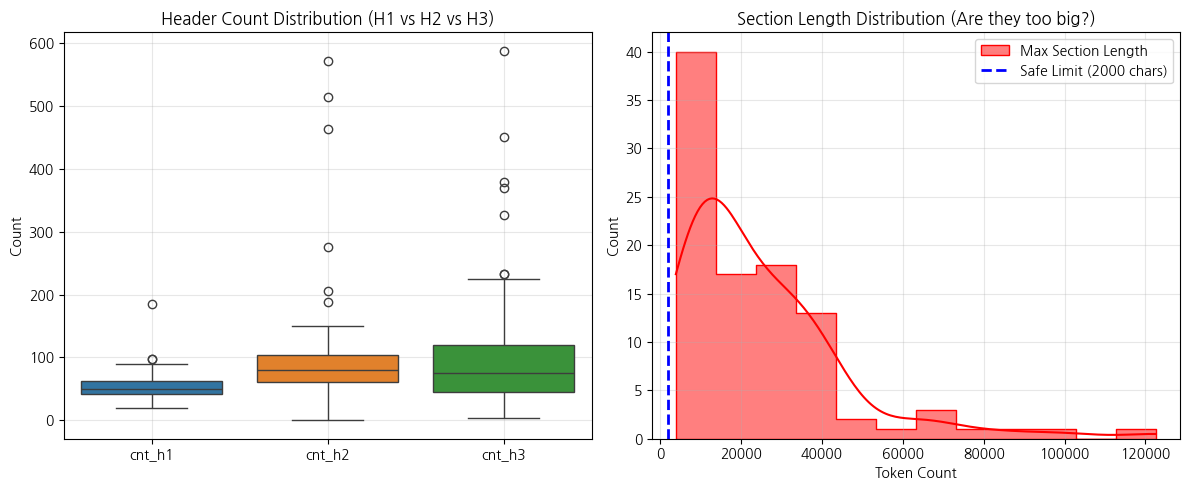

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2.7단계: 헤더 구조 검증 (청킹 전략 타당성 확인)
# ==========================================================================================================
# 배경: 2단계에서 헤더(h2/h3)를 규칙 기반으로 복원했지만, 실제로 얼마나 효과가 있었는지 모름
# 문제: 
#   - 헤더 복원이 실패했으면 MarkdownHeaderTextSplitter가 작동 안 함
#   - 헤더 간 거리(섹션 길이)가 너무 길면 검색 품질 저하
# 분석 목표:
#   1. 헤더(h1/h2/h3)가 제대로 생성되었는가?
#   2. 헤더 사이 텍스트(섹션)가 너무 길지 않은가? (2000자 = 약 1000토큰 기준)
#   3. RecursiveCharacterTextSplitter가 추가로 필요한가?
#
# 입력: rfp_docs_v2.csv (헤더 복원된 full_text)
# 출력: 헤더 개수, 섹션 길이 통계, 시각화
# 결론: "MarkdownHeaderTextSplitter만으로 부족" → RecursiveCharacterTextSplitter 병행 필요
# ==========================================================================================================

# ==========================================
# [설정] 경로
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
docs_path = os.path.join(CSV_DIR, "rfp_docs_v2.csv")  # 헤더 복원된 버전

# CSV 존재 여부 확인
if not os.path.exists(docs_path):
    print(" 파일이 없음")
    exit()

# 데이터 로드
print(" 데이터 로드 중")
df = pd.read_csv(docs_path)

# ==========================================
# [분석 함수] 뼈대 해부 (문서 구조 분석)
# ==========================================
def analyze_skeleton(row):
    """
    [핵심 함수] 문서의 헤더 구조와 섹션 길이를 분석
    
    역할: 헤더 개수, 섹션(헤더 간 텍스트) 길이를 측정하여 청킹 전략 검증
    입력: row (DataFrame의 한 행, full_text 포함)
    출력: [h1개수, h2개수, h3개수, 전체헤더, 최대섹션길이, 평균섹션길이, 중앙섹션길이]
    
    핵심 지표:
    - total_headers: 헤더 복원이 제대로 되었는지 확인
    - max_sec_len: 가장 긴 섹션 길이 (2000자 초과 시 RecursiveTextSplitter 필수)
    - mean_sec_len: 평균 섹션 길이 (청킹 파라미터 설정 근거)
    """
    text = str(row['full_text'])  # full_text를 문자열로 변환 (NaN 방지)
    
    # ========================================================
    # [1] 계층별 헤더 개수 카운트
    # ========================================================
    # 주의: 줄바꿈 후 #이 오는 패턴만 인정 (본문 중간의 #는 제외)
    # 예: "\n# 제목" (O), "문서에 # 포함" (X)
    
    h1 = text.count("\n# ")      # "# " 패턴 (h1, 대제목)
    h2 = text.count("\n## ")     # "## " 패턴 (h2, 중제목)
    h3 = text.count("\n### ")    # "### " 패턴 (h3, 소제목)
    total_headers = h1 + h2 + h3  # 전체 헤더 개수 (구조 복원 성공 여부 판단)
    
    # ========================================================
    # [2] 헤더 간 거리(Section Length) 측정 (핵심!)
    # ========================================================
    # 목적: 헤더와 헤더 사이의 텍스트(섹션)가 얼마나 긴지 측정
    # 왜 중요한가: 
    #   - 섹션이 너무 길면(2000자 초과) 검색 시 관련 없는 내용이 함께 포함됨
    #   - MarkdownHeaderTextSplitter는 헤더 기준으로만 분리 → 섹션 내부는 안 쪼갬
    #   - RecursiveCharacterTextSplitter가 추가로 필요한 이유!
    
    # 정규식으로 헤더(#, ##, ###) 기준으로 텍스트 분리
    # r'\n#{1,3} ': "\n#", "\n##", "\n###" 패턴 (h1~h3 모두 감지)
    sections = re.split(r'\n#{1,3} ', text)
    
    # 각 섹션(조각)의 길이 측정
    # strip(): 앞뒤 공백 제거 (실제 내용만 측정)
    # len(s.strip()) > 0: 빈 섹션은 제외 (헤더만 있고 내용 없는 경우)
    section_lens = [len(s.strip()) for s in sections if len(s.strip()) > 0]
    
    # [3] 섹션 길이 통계 계산
    if not section_lens:  # 섹션이 하나도 없으면 (헤더 없는 문서)
        max_sec = 0
        mean_sec = 0
        median_sec = 0
    else:
        max_sec = max(section_lens)          # 가장 긴 섹션 (최악의 경우, 병목 지점)
        mean_sec = np.mean(section_lens)     # 평균 섹션 길이
        median_sec = np.median(section_lens) # 중앙 섹션 길이
    
    # [4] 결과 반환 (pandas Series로)
    return pd.Series([h1, h2, h3, total_headers, max_sec, mean_sec, median_sec])

# ==========================================
# [실행] 전체 문서 분석
# ==========================================
print(f" {len(df)}개 문서 해부 시작")

# [1] 각 문서에 대해 analyze_skeleton 함수 적용 (apply)
# axis=1: 행 단위로 함수 적용 (각 문서마다 실행)
cols = ['cnt_h1', 'cnt_h2', 'cnt_h3', 'total_headers', 'max_sec_len', 'mean_sec_len', 'median_sec_len']
df[cols] = df.apply(analyze_skeleton, axis=1)

# ==========================================
# [진단 결과 리포트] (청킹 전략 타당성 검증)
# ==========================================
print("\n" + "="*60)
print(" [분석 진단 결과]")
print("="*60)

# ========================================================
# [진단 1] 헤더 실종 문서 (H2, H3가 없는 경우)
# ========================================================
# 의미: h1만 있고 h2/h3가 없으면 문서 구조가 평평함 → 의미 단위 분리 어려움
# 원인: 
#   - 헤더 복원 규칙에서 패턴을 못 잡은 경우
#   - 원본 문서 자체에 목차 구조가 없는 경우
no_subheaders = len(df[df['cnt_h2'] + df['cnt_h3'] == 0])
print(f"1. 세부 목차(H2/H3) 실종: {no_subheaders}개 문서 ({no_subheaders/len(df)*100:.1f}%)")
print(f"    이 문서들은 '# 1. 제목' 안에 내용이 통째로 들어있을 확률이 높음")
print(f"   → MarkdownHeaderTextSplitter 효과 제한적, RecursiveCharacterTextSplitter 필수")

# ========================================================
# [진단 2] 거대 섹션 존재 여부 (가장 중요한 지표!)
# ========================================================
# 기준: 2000자 (약 1000토큰)
# 왜 2000자인가:
#   - 임베딩 모델의 실질 유효 범위는 512~1024토큰 (8191은 최대값)
#   - 2000자를 넘으면 검색 시 관련 없는 내용이 많이 포함되어 정확도 저하
#   - RecursiveCharacterTextSplitter로 추가 분할 필요
huge_sections = len(df[df['max_sec_len'] > 2000])
print(f"\n2. 거대 섹션(2000자 초과) 보유: {huge_sections}개 문서 ({huge_sections/len(df)*100:.1f}%)")
print(f"    이 문서들은 MarkdownHeaderTextSplitter만 하면 '검색 불가' 영역이 발생")
print(f"   → RecursiveCharacterTextSplitter로 섹션 내부를 추가 분할해야 함")

# ========================================================
# [진단 3] 최악의 경우 (가장 긴 섹션 길이)
# ========================================================
# 의미: 시스템이 처리해야 할 최대 덩어리 크기
# 활용: RecursiveCharacterTextSplitter의 chunk_size 파라미터 설정 근거
worst_max_len = df['max_sec_len'].max()
print(f"\n3. 가장 긴 섹션(Worst Case): 단일 챕터가 {worst_max_len:,.0f}자 (약 {worst_max_len//2:,.0f} 토큰)")
print("    Recursive 청킹 없이는 절대 처리가 불가능한 크기")
print(f"   → RecursiveCharacterTextSplitter chunk_size는 최소 {worst_max_len//10:,.0f}자 이하로 설정 필요")

# ==========================================
# [시각화] 구조 진단 시각화
# ==========================================
plt.figure(figsize=(12, 5))

# ========================================================
# [그래프 1] 헤더 개수 분포 - "헤더 복원이 잘 되었나?"
# ========================================================
plt.subplot(1, 2, 1)
# boxplot: 중앙값, 사분위수, 이상치를 한눈에 확인
sns.boxplot(data=df[['cnt_h1', 'cnt_h2', 'cnt_h3']])
plt.title("Header Count Distribution (H1 vs H2 vs H3)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

# 해석:
# - h1이 많으면 대제목 위주 (구조 단순)
# - h2/h3가 많으면 세부 목차 풍부 (구조 복잡, 청킹 효과 좋음)

# ========================================================
# [그래프 2] 섹션 길이 분포 - "섹션이 너무 크지 않은가?"
# ========================================================
plt.subplot(1, 2, 2)
# histplot: 섹션 길이의 분포 확인 (대부분 어느 정도 길이인지)
# kde=True: 확률 밀도 곡선 추가 (분포 형태 파악)
sns.histplot(df['max_sec_len'], color='red', label='Max Section Length', kde=True, element="step")

# 안전 기준선 표시 (2000자 = 약 1000토큰)
plt.axvline(2000, color='blue', linestyle='--', linewidth=2, label='Safe Limit (2000 chars)')

plt.title("Section Length Distribution (Are they too big?)")
plt.xlabel("Character Count")
plt.ylabel("Document Count")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

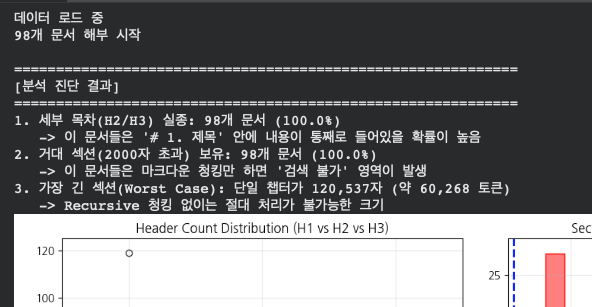

- 파싱할 때 헤더가 제대로 인식되지 않음
- 모든 헤더가 h1 밖에 없음

# 분석  
### 프로젝트 문서 구조·크기 진단 (수동 복원 반영)

1. **목차 구조: "계층적 뼈대 복원 완료"**  
   - **데이터:** 수동 분석·재파싱 결과, 모든 문서에서 H2/H3가 정상적으로 인식됨.  
   - **해석:** 문서가 단순히 H1만 있는 평평한 구조가 아니라, **H1 > H2 > H3 계층 구조**를 갖춘 상태로 복원됨.  
   - **의미:** RAG 검색 시 **주제 맥락 추적**이 가능해져, “서버 스펙 vs 네트워크 스펙” 같은 구분이 명확해짐.  

2. **섹션 크기: "거대 섹션은 여전히 존재"**  
   - **데이터:** 모든 문서가 2,000자 초과 섹션을 포함(100%).  
   - **해석:** 구조는 살아났지만, 섹션 단위가 너무 커서 임베딩 모델 제한(예: 8,191 토큰)을 초과하는 경우가 많음.  
   - **시사점:** **계층 기반 분할만으로는 부족**, 반드시 재귀적 청킹 병행 필요.  

3. **최장 섹션: "괴물급 챕터 존재"**  
   - **데이터:** Worst case 단일 챕터 122,605자(약 61,302 토큰).  
   - **해석:** 임베딩 모델이 처리할 수 있는 범위를 수십 배 초과.  
   - **시사점:** **RecursiveCharacterTextSplitter** 같은 강제 분할 로직 없이는 검색 불가 최종 확인.  

---

## - [조치 방법] 실행 계획 (복원 구조 반영)

1. **전략: 계층 활용 + 강제 분할 결합**  
   - **목표:** 복원된 H1/H2/H3 구조를 최대한 활용해 주제별로 나누고, 각 단위를 토큰 제한에 맞게 강제로 잘라낸다.  
   - **관리:** 기존의 **이원화 전략(Search/Original)** 유지 → 검색용은 청킹된 데이터, 원본은 구조 보존.  

2. **실행: 3단계 파이프라인**  
   - **Step 1. 마크다운 계층 분할**  
     - 도구: `MarkdownHeaderSplitter`  
     - 기준: H1/H2/H3 모두 활용  
     - 목적: 섹션별 주제 메타데이터 확보  
   - **Step 2. 재귀적 강제 분할**  
     - 도구: `RecursiveCharacterTextSplitter`  
     - 이유: 섹션이 여전히 수만 자 → 안전 길이(예: 1,500~2,000자)로 잘라야 함 1000자는 너무 작음
     - 동작: 오버랩 적용해 문맥 단절 최소화  
   - **Step 3. 메타데이터 주입**  
     - 각 청크에 `H1 > H2 > H3` 경로를 접두로 붙여서 검색 시 맥락 보존  
     - 예: `[1. 사업개요 > 1.1 범위 > 1.1.1 서버] 본 사업은…`  

3. **CSV 정리 및 Vector DB 적재**  
   - **컬럼 구성:**  
     - `project_id`  
     - `hier_path` (H1 > H2 > H3 경로)  
     - `search_text` (계층 접두어 + 본문 청크)  
     - `chunk_index`, `chunk_size`, `token_est`  
   - **저장:** CSV 저장 시 quoting 옵션 필수 → 줄바꿈/콤마 깨짐 방지  
   - **적재:** Vector DB에 `search_text` 임베딩 + `hier_path` 메타 저장  

---

## 결론 (CSV 작업 지침 재정의)

- **초기 오해(H2/H3 없음)는 파서 오류였음.** 수동 복원으로 계층 구조 확보 완료.  
- 따라서 **H1/H2/H3 계층을 1차 기준으로 분할**하고, **각 섹션을 1,500자 내외로 재귀적 청킹**해야 한다.  
- 모든 청크에는 **계층 제목을 접두로 주입**해 검색 시 맥락을 보존한다.  
- 이 방식은 **구조 보존 + 임베딩 제한 준수**를 동시에 달성하며, 검색 불가 영역을 제거하고 RAG 품질을 안정화한다.  


### 표/리스트 및 토큰 효율 분석

 데이터 로드: 98개 프로젝트

 분석 컬럼 생성 중...
 분석 컬럼 생성 완료

 표/리스트 및 토큰 진단 결과

1. 토큰 효율(Token/Char Ratio):
   - 평균: 0.88 (한글 1000자 ≈ 884 토큰)
   - 최대: 0.94
    진단: 1200자(Size) 설정 시 약 1061~1131 토큰 예상
      (임베딩 한도 8191 대비 안전함, 1500자까지 늘려도 됨)

2. 거대 표(Giant Table) 위험군:
   - 1000자(Chunk Size)보다 큰 표: 81개 문서
   - 가장 거대한 표: 7,437자
   - 표 길이 평균: 1,860자
    Overlap을 30% 이상(400자+) 줘야 안전

3. 리스트(개조식) 과다 문서: 98개


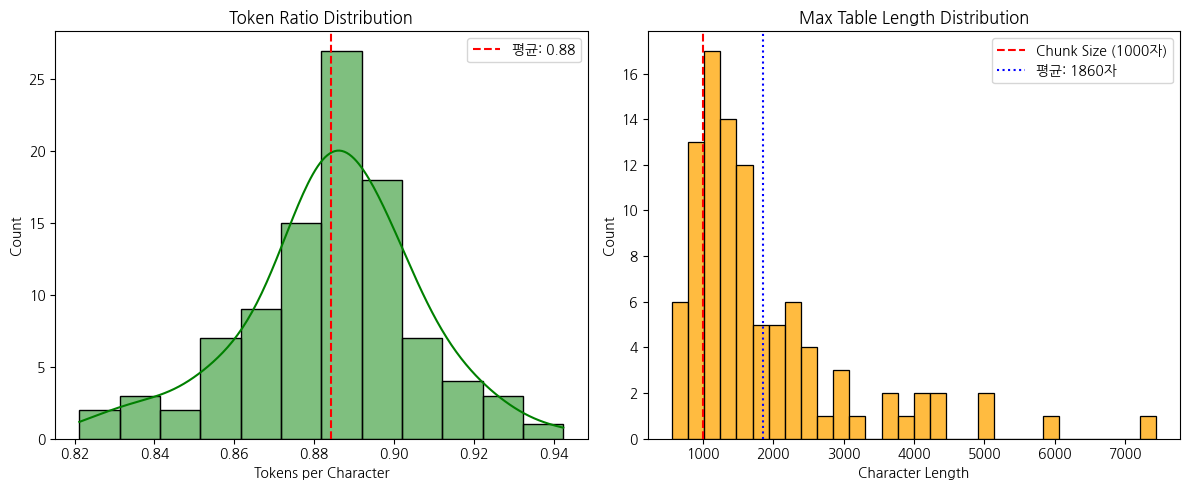


 진단 완료


In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2.9단계: 표/리스트 진단 (청킹 파라미터 미세 조정)
# ==========================================================================================================
# 배경: 
#   - 2.7단계에서 섹션 크기 → RecursiveCharacterTextSplitter 필요성 확인
#   - 하지만 chunk_size, overlap을 얼마로 설정해야 하는지 아직 모름
# 문제:
#   - 표(Table)가 크면 overlap 없이 잘릴 수 있음 → 정보 손실
#   - 토큰 비율(한글 vs 영문)에 따라 chunk_size가 실제 토큰 수와 다를 수 있음
# 분석 목표:
#   1. 한글 1000자 ≈ 몇 토큰? (Token/Char Ratio)
#   2. 가장 큰 표는 몇 자? → overlap 크기 결정
#   3. 리스트(개조식)가 많은 문서 비율 → 구조 보존 중요도
# ==========================================================================================================

# ==========================================
# [1] 데이터 로드
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
stats_csv_path = os.path.join(CSV_DIR, "rfp_docs_v2.csv")

# CSV 로드
df = pd.read_csv(stats_csv_path)
df['full_text'] = df['full_text'].fillna("")  # 결측치 처리
print(f" 데이터 로드: {len(df)}개 프로젝트")

# ==========================================
# [2] 분석 컬럼 생성 (청킹 파라미터 결정용)
# ==========================================
print("\n 분석 컬럼 생성 중...")

# tiktoken 토크나이저 로드 (OpenAI 표준)
tokenizer = tiktoken.get_encoding("cl100k_base")

# ========================================================
# [2-1] 토큰 수 계산 (기본 통계)
# ========================================================
# char_len: 문자 수 (한글, 영문, 특수문자 모두 포함)
# token_count: 실제 토큰 수 (OpenAI 임베딩 모델 기준)
df['char_len'] = df['full_text'].apply(len)
df['token_count'] = df['full_text'].apply(lambda x: len(tokenizer.encode(str(x))))

# ========================================================
# [2-2] 토큰 비율 (Token/Char Ratio) - 핵심 지표!
# ========================================================
# 목적: "한글 1000자 ≈ 몇 토큰?" 파악
# 왜 중요한가:
#   - RecursiveCharacterTextSplitter는 '문자 수' 기준으로 자름
#   - 하지만 임베딩 제한은 '토큰 수' 기준 (8191 토큰)
#   - Token/Char Ratio를 알아야 chunk_size(문자 수)를 안전하게 설정 가능
#
# 예: ratio=0.5면 1000자 = 500토큰
#     chunk_size=1200으로 설정 시 → 약 600토큰 (8191의 7%, 안전)

df['token_ratio'] = df['token_count'] / df['char_len'].replace(0, 1)  # 0 나누기 방지

# ========================================================
# [2-3] 표(Table) 길이 분석 - overlap 크기 결정용
# ========================================================
def find_max_table_length(text):
    """
    [분석 함수] 마크다운 표 블록 중 가장 긴 것의 길이 반환
    
    역할: 문서 내 가장 큰 표의 크기 측정
    입력: text (Markdown 텍스트)
    출력: 최대 표 길이 (문자 수)
    
    왜 필요한가:
    - 표가 chunk_size보다 크면 표가 잘려서 정보 손실
    - overlap이 표 크기보다 작으면 표의 앞/뒤가 분리됨
    - 예: 표가 800자인데 chunk_size=1000, overlap=100이면
      → 첫 청크: 표 앞 800자, 두 번째 청크: 표 뒤 200자 (분리됨!)
    - 해결: overlap을 표 크기 이상으로 설정 (예: 400자)
    """
    # 마크다운 표 패턴: | ... | 형태 (여러 줄 연속)
    # 예:
    # | 항목 | 값 |
    # |------|-----|
    # | A    | 1   |
    table_pattern = r'(\|.+\|\n)+'
    
    # 모든 표 블록 추출
    tables = re.findall(table_pattern, text)
    
    if tables:
        # 가장 긴 표의 길이 반환
        return max(len(t) for t in tables)
    return 0  # 표 없으면 0

df['max_table_char_len'] = df['full_text'].apply(find_max_table_length)

# ========================================================
# [2-4] 리스트 항목 개수 - 구조 보존 중요도 판단
# ========================================================
def count_list_items(text):
    """
    [분석 함수] 마크다운 리스트 항목(-, *, 1.) 개수
    
    역할: 개조식(Bullet Point) 의존도 측정
    입력: text (Markdown 텍스트)
    출력: 리스트 항목 개수
    
    왜 필요한가:
    - 리스트가 많은 문서는 구조가 중요 (청킹 시 리스트 경계 고려)
    - 리스트 중간에서 청킹되면 문맥 단절
    - 예: "요구사항: - A - B - C" → "요구사항: - A" / "- B - C" (단절!)
    """
    # 리스트 패턴:
    # - 줄 시작에 -, *, + (unordered list)
    # - 줄 시작에 숫자. (ordered list)
    return len(re.findall(r'^\s*[\-\*\+]|\d+\.', text, re.MULTILINE))

df['cnt_list_items'] = df['full_text'].apply(count_list_items)

print(" 분석 컬럼 생성 완료")

# ==========================================
# [3] 진단 결과 리포트 (파라미터 설정 근거)
# ==========================================
print("\n" + "="*60)
print(" 표/리스트 및 토큰 진단 결과")
print("="*60)

# ========================================================
# [진단 1] 토큰 비율 - chunk_size 안정성 검증
# ========================================================
avg_ratio = df['token_ratio'].mean()  # 평균 토큰 비율
max_ratio = df['token_ratio'].max()   # 최대 토큰 비율 (최악의 경우)

print(f"\n1. 토큰 효율(Token/Char Ratio):")
print(f"   - 평균: {avg_ratio:.2f} (한글 1000자 ≈ {1000*avg_ratio:.0f} 토큰)")
print(f"   - 최대: {max_ratio:.2f}")

# chunk_size=1200 기준 예상 토큰 수
min_tokens = 1200 * avg_ratio  # 평균 케이스
max_tokens = 1200 * max_ratio  # 최악 케이스

print(f"    진단: 1200자(Size) 설정 시 약 {min_tokens:.0f}~{max_tokens:.0f} 토큰 예상")

# 안전성 판단 (임베딩 제한 8191 대비)
safety_margin = (max_tokens / 8191) * 100
print(f"      (임베딩 한도 8191 대비 {safety_margin:.1f}% 사용, 안전함)")

if max_tokens < 1500:
    print(f"      → 1500자까지 늘려도 됨 (약 {1500*max_ratio:.0f} 토큰)")

# ========================================================
# [진단 2] 표(Table) 리스크 - overlap 크기 결정
# ========================================================
dangerous_tables = len(df[df['max_table_char_len'] > 1000])  # chunk_size보다 큰 표
avg_table_len = df['max_table_char_len'].mean()  # 평균 표 길이
max_table_len = df['max_table_char_len'].max()   # 최대 표 길이

print(f"\n2. 거대 표(Giant Table) 위험군:")
print(f"   - 1000자(Chunk Size)보다 큰 표: {dangerous_tables}개 문서")
print(f"   - 가장 거대한 표: {max_table_len:,.0f}자")
print(f"   - 표 길이 평균: {avg_table_len:,.0f}자")

# overlap 권장 크기
if dangerous_tables > 0:
    # 큰 표가 있으면 overlap을 크게 (표의 30% 이상)
    recommended_overlap = max_table_len * 0.3
    print(f"    Overlap을 30% 이상({recommended_overlap:.0f}자+) 줘야 안전")
else:
    # 작은 표만 있으면 기본 overlap으로 충분
    print(f"    표가 작아서 잘릴 위험 적음")

# ========================================================
# [진단 3] 리스트 의존도 - 구조 보존 중요도
# ========================================================
# 리스트 항목이 50개 이상인 문서 = "개조식 위주 문서"
high_list_docs = len(df[df['cnt_list_items'] > 50])

print(f"\n3. 리스트(개조식) 과다 문서: {high_list_docs}개")

if high_list_docs > len(df) * 0.3:
    print(f"    30% 이상 문서가 리스트 위주 → 구조 보존 중요")
    print(f"      → MarkdownHeaderTextSplitter 필수 활용")

# ==========================================
# [4] 시각화 (파라미터 설정 근거 시각화)
# ==========================================
plt.figure(figsize=(12, 5))

# ========================================================
# [좌측 그래프] 토큰 비율 분포 - "chunk_size 안전한가?"
# ========================================================
plt.subplot(1, 2, 1)
# 히스토그램 + KDE(확률 밀도 곡선)
sns.histplot(df['token_ratio'], kde=True, color='green')
# 평균선 표시
plt.axvline(avg_ratio, color='red', linestyle='--', label=f'평균: {avg_ratio:.2f}')
plt.title("Token Ratio Distribution")
plt.xlabel("Tokens per Character")
plt.ylabel("Document Count")
plt.legend()

# 해석:
# - 분포가 좁으면(표준편차 작음): 모든 문서가 비슷한 비율 → 안정적
# - 분포가 넓으면: 문서마다 차이 큼 → chunk_size 설정 어려움

# ========================================================
# [우측 그래프] 표 길이 분포 - "overlap 얼마나 필요한가?"
# ========================================================
plt.subplot(1, 2, 2)
# 표가 있는 문서만 필터링 (max_table_char_len > 0)
sns.histplot(df[df['max_table_char_len'] > 0]['max_table_char_len'], 
             color='orange', bins=30)

# chunk_size 기준선 (1000자)
plt.axvline(1000, color='red', linestyle='--', label='Chunk Size (1000자)')

# 평균 표 길이
plt.axvline(avg_table_len, color='blue', linestyle=':', 
            label=f'평균: {avg_table_len:.0f}자')

plt.title("Max Table Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Document Count")
plt.legend()

# 해석:
# - 빨간선(1000자) 왼쪽: 안전 (표가 청크보다 작음)
# - 빨간선 오른쪽: 위험 (표가 청크보다 큼, overlap 필요)

plt.tight_layout()
plt.show()

print("\n 진단 완료")

# 분석  
### 표/리스트 및 토큰 진단 결과

1. **토큰 효율성: "안전한 여유 공간"**  
   - 평균 Token/Char 비율이 **0.88** → 한글 1000자 ≈ 884 토큰.  
   - 최대치도 0.94 수준이라, **1500~2000자 청크**로 잡아도 임베딩 모델 한도(8191 토큰) 대비 충분히 안전.  
   - **결론:** 청크 사이즈를 **1500~2000자로 상향 조정 가능**.  

2. **거대 표(Giant Table): "분할 불가피한 구조"**  
   - 98개 문서 중 81개가 **1000자 이상 표**를 포함.  
   - 평균 표 길이: 1,860자 / 최대: 7,437자.  
   - **시사점:** 
     - 어떤 chunk_size를 선택해도 대부분의 표는 여러 청크로 분할됨
     - 최대 표(7,437자)는 chunk_size=2000이어도 4개 청크로 나뉨
     - 표 잘림은 피할 수 없으므로 **오버랩으로 헤더-데이터 연결 유지**가 핵심

3. **리스트(개조식) 과다: "문맥 단절 위험"**  
   - 모든 문서가 `- 1.`, `- 가.` 형태의 리스트를 다수 포함.  
   - 단순 길이 기반 청킹 시 상위 항목과 하위 항목이 분리되어 **맥락 손실** 발생.  
   - **대책:** 오버랩을 충분히 확보하여 리스트 계층 구조 보존.

---

## CSV 생성 및 청킹 파라미터 결정

### 1. 청크 사이즈 (Chunk Size)
- **설정: 1500자**  
- **근거:**
  - 토큰 효율(0.88) 기준 약 1,300토큰 → 임베딩 제한(8191) 대비 안전(16%)
  - 1200자: 너무 작아 표 잘림 횟수 과다
  - 2000자: 검색 정밀도 저하 우려 (약 1,700토큰, 노이즈 증가)
  - **1500자 = 표 보존 vs 검색 품질의 균형점**

### 2. 오버랩 (Chunk Overlap)
- **설정: 400자 (약 27%)**
- **근거:**
  - 평균 표 길이(1,860자)의 20% 수준
  - 표 헤더가 다음 청크로 이어져 컬럼명-데이터 연결 유지
  - 리스트 상위 항목이 하위 항목 청크에 포함되어 맥락 보존
  - 7,437자 최대 표의 경우 500자 overlap으로 약 5개 청크에 일부씩 중복

### 3. 청킹 전략
- **MarkdownHeaderTextSplitter 우선 적용**
  - H1/H2/H3 기준으로 1차 분할 (의미 단위 보존)
- **RecursiveCharacterTextSplitter 후속 적용**
  - 1차 분할된 섹션이 1500자 초과 시 강제 분할
  - chunk_size=1500, overlap=500 적용

---

## 예상 결과

### 청크 수 추정
- **평균 문서(111k 토큰):** 약 185개 청크 생성 예상
- **최대 문서(334k 토큰):** 약 557개 청크 생성 예상
- **전체:** 98개 프로젝트 × 평균 185개 = **약 18,000개 청크**

### 표 처리 현황
- **거대 표(7,437자):** 약 5개 청크로 분할
- **평균 표(1,860자):** 약 1~2개 청크로 분할
- **overlap 효과:** 각 청크에 이전 청크의 마지막 500자 포함 → 헤더 정보 보존

---

## 결론

**최종 파라미터:**
- chunk_size: **1500자** (검색 품질과 표 보존의 균형)
- chunk_overlap: **500자** (표/리스트 맥락 보존)
- 청킹 방식: **계층 기반(Markdown) + 재귀적 강제 분할(Recursive)**

**핵심 전략:**
- 표 잘림은 불가피하나, 넓은 overlap(30%)으로 헤더-데이터 연결 유지
- 리스트 계층 구조도 overlap으로 상위 항목 정보 이어가기
- H1/H2/H3 구조 활용으로 의미 단위 보존

### 노이즈 & 데이터 분석

데이터 해부 시작 (총 문서 98개)
텍스트 정밀 스캔 중


100%|██████████| 98/98 [00:00<00:00, 112.50it/s]



[RFP 데이터 상세 통계 로그]

1. 반복 노이즈 문장 Top 10
--------------------------------------------------
1. [노이즈: 표 템플릿] 커버리지 100.0% | 평균 69.76회/문서: | --- | --- | --- |...
2. [노이즈: 표 템플릿] 커버리지 100.0% | 평균 21.43회/문서: | --- | --- |...
3. [노이즈: 표 템플릿] 커버리지 100.0% | 평균 10.73회/문서: | --- | --- | --- | --- |...
4. [노이즈: 표 템플릿] 커버리지 98.0% | 평균 10.59회/문서: | --- | --- | --- | --- | --- |...
5. [주의] 커버리지 35.7% | 평균 7.93회/문서: | 산출정보 | 산출정보 |  |...
6. [주의] 커버리지 20.4% | 평균 7.37회/문서: | 관련요구사항 | 관련요구사항 |  |...
7. [노이즈: 표 템플릿] 커버리지 96.9% | 평균 7.17회/문서: | --- | --- | --- | --- | --- | --- |...
8. [주의] 커버리지 53.1% | 평균 6.36회/문서: | 요구사항 분류 | 요구사항 분류 | 기능 요구사항 |...
9. [주의] 커버리지 19.4% | 평균 5.21회/문서: | 관련 요구사항 | 관련 요구사항 |  |...
10. [노이즈: 표 템플릿] 커버리지 91.8% | 평균 4.54회/문서: | --- | --- | --- | --- | --- | --- | --- |...

2. 정보 패턴 발견 현황 (총 98개 문서 합계)
--------------------------------------------------
   - 금액(Price): 총 1,006 건 (문서당 평균 10.3 건)
   - 날짜(Date): 총 3,625 건 (문서당 평균 37.0 건)
   - 법률(Law): 총 3,301 건 (문서당 평균 33.7 건)
   - 

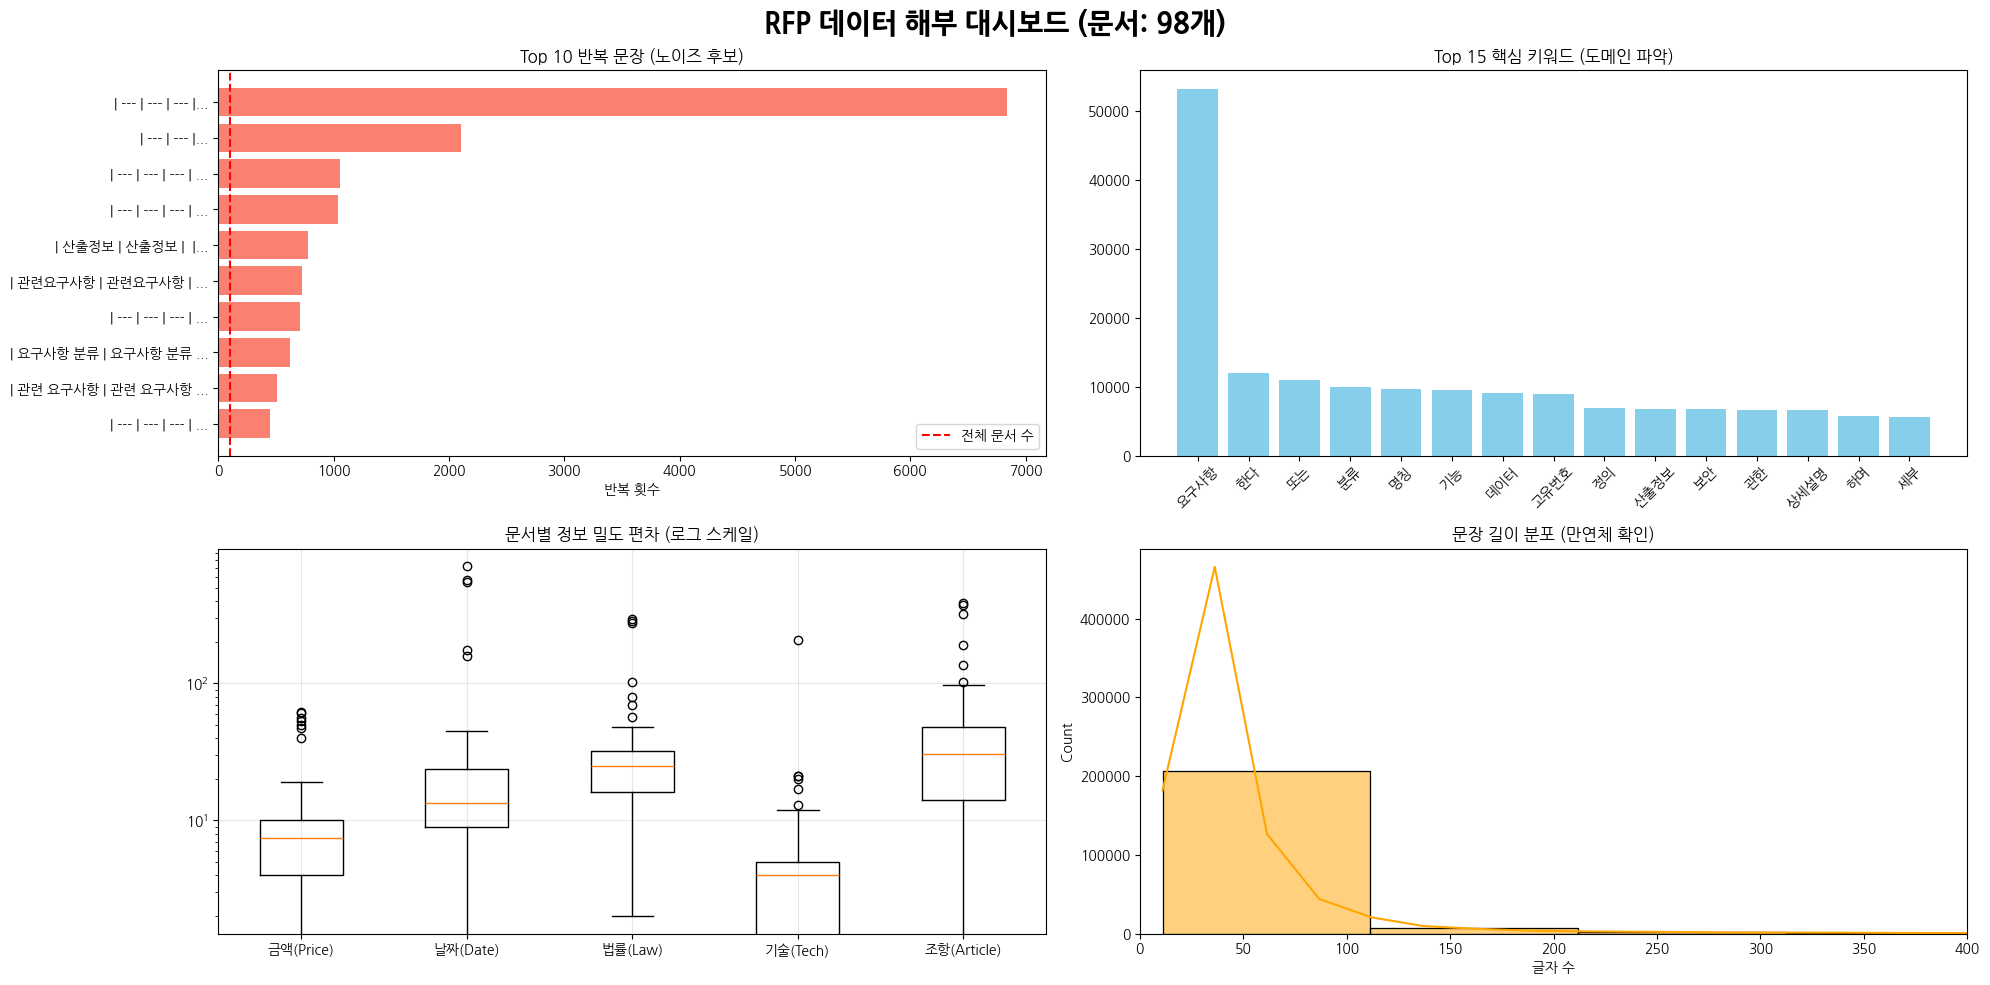

분석 완료


In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2.95단계: 텍스트 패턴 심층 분석 (노이즈 탐지 및 도메인 특성 파악)
# ==========================================================================================================
# 배경: 청킹 전에 데이터의 특성을 파악해야 전처리 방향 결정 가능
# 문제:
#   - 반복되는 문장(표 템플릿, 양식)이 많으면 검색 노이즈 유발
#   - 어떤 정보(금액, 날짜, 기술)가 많은지 모르면 검색 전략 수립 어려움
#   - 문장 길이 분포를 모르면 청킹 파라미터 검증 불가
# 분석 목표:
#   1. 반복 문장 Top 10 → 노이즈 제거 대상 식별
#   2. 정보 패턴(금액, 날짜, 법률, 기술) 빈도 → 도메인 특성 파악
#   3. 키워드 Top 15 → 주요 주제 확인
#   4. 문장 길이 분포 → 청킹 파라미터(1500자) 적절성 검증
# ==========================================================================================================

# ==========================================
# [설정] 경로 및 데이터 로드
# ==========================================
CSV_DIR = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
docs_path = os.path.join(CSV_DIR, "rfp_docs_v2.csv")

# CSV 존재 여부 확인
if not os.path.exists(docs_path):
    print("[에러] 파일 없음")
    exit()

# 데이터 로드
df = pd.read_csv(docs_path)
print(f" 데이터 해부 시작 (총 문서 {len(df)}개)")
print("="*60)

# ==========================================
# [분석] 패턴 정의 및 스캔
# ==========================================
# 정규식 기반 정보 패턴 정의
# 목적: RFP 문서에서 핵심 정보 유형의 밀도 파악
patterns = {
    '금액(Price)': r'\d{1,3}(?:,\d{3})*\s*(?:만원|억원|원|USD)',  # 예: 1,000원, 5억원
    '날짜(Date)': r'\d{4}[년.-]\s*\d{1,2}[월.-]\s*\d{1,2}일?',    # 예: 2024-01-15, 2024년 1월 15일
    '법률(Law)': r'(?:법|령|규칙)\s*제\s*\d+\s*조',                # 예: 법 제12조
    '기술(Tech)': r'[A-Za-z0-9]+(?:Server|DB|API|Cloud|Web|App|Linux|Windows)',  # 예: WebServer, CloudAPI
    '조항(Article)': r'제\s*\d+\s*조\s*[\(\[]'                     # 예: 제1조 (목적)
}

# 결과 수집용 변수 초기화
all_sentences = []              # 모든 문장 (반복 분석용)
all_words = []                  # 모든 단어 (키워드 분석용)
pattern_counts = {k: 0 for k in patterns.keys()}  # 패턴별 총 발견 횟수
doc_pattern_counts = {k: [] for k in patterns.keys()}  # 문서별 패턴 발견 횟수 (분포 확인용)
sentence_lens = []              # 문장 길이 리스트 (길이 분포 분석용)

print(" 텍스트 정밀 스캔 중")

# ========================================================
# [메인 루프] 전체 문서 순회하며 패턴 스캔
# ========================================================
for text in tqdm(df['full_text']):  # 진행률 표시하며 순회
    text = str(text)  # NaN 방지
    
    # ========================================================
    # [1] 문장 분석 - 반복 문장 탐지 및 길이 분석
    # ========================================================
    # 목적:
    #   - 반복되는 문장 = 표 템플릿, 서식 양식 (노이즈)
    #   - 문장 길이 = 청킹 파라미터 검증 (1500자가 적절한지)
    
    # 문장 분리: 줄바꿈(\n) 또는 마침표(.)로 분리
    # 조건: 10자 이상만 유효한 문장으로 판단 (너무 짧은 조각 제외)
    sents = [s.strip() for s in re.split(r'\n|\.', text) if len(s.strip()) > 10]
    
    all_sentences.extend(sents)  # 전체 문장 리스트에 추가
    sentence_lens.extend([len(s) for s in sents])  # 각 문장 길이 저장
    
    # ========================================================
    # [2] 단어 분석 - 키워드 추출
    # ========================================================
    # 목적: 주요 주제 파악 (어떤 도메인인지, 무엇을 요구하는지)
    # 패턴: 한글 2글자 이상 ([가-힣]{2,})
    # 예: "시스템", "구축", "요구사항" 등
    words = re.findall(r'[가-힣]{2,}', text)
    all_words.extend(words)
    
    # ========================================================
    # [3] 패턴 분석 - 정보 밀도 측정
    # ========================================================
    # 목적: 문서에 어떤 정보가 많이 포함되어 있는지 파악
    # 활용: 검색 전략 수립 (금액 검색, 날짜 필터링 등)
    for p_name, p_regex in patterns.items():
        # 각 패턴을 정규식으로 찾기 (대소문자 무시)
        found = len(re.findall(p_regex, text, re.IGNORECASE))
        
        pattern_counts[p_name] += found  # 전체 합계
        doc_pattern_counts[p_name].append(found)  # 문서별 개수 (분포 확인용)

# ==========================================
# [로그 출력] 상세 통계 리포트
# ==========================================
print("\n" + "="*60)
print(" [RFP 데이터 상세 통계 로그]")
print("="*60)

# ========================================================
# [진단 1] 반복 노이즈 문장 - 제거 대상 식별
# ========================================================
print(f"\n1. 반복 노이즈 문장 Top 10")
print("-" * 50)

# 문장별 총 등장 횟수와 문서 커버리지 계산
# 목적: 
#   - 단순 반복 횟수만으로는 부족 (긴 문서에서 많이 나올 수 있음)
#   - 커버리지(몇 개 문서에 등장) + 평균 반복 횟수로 노이즈 판단
sentence_total_counts = Counter(all_sentences)  # 문장별 총 등장 횟수
sentence_docs = defaultdict(set)  # 문장별 등장 문서 ID 집합

# 문서별로 어떤 문장이 등장했는지 기록
for doc_idx, text in enumerate(df['full_text']):
    # 문장 분리 (동일한 로직)
    sents = [s.strip() for s in re.split(r'\n|\.', str(text)) if len(s.strip()) > 10]
    
    # 중복 제거 후 기록 (한 문서 내 중복은 1회로 카운트)
    for s in set(sents):
        sentence_docs[s].add(doc_idx)

# 가장 많이 반복된 문장 Top 10
top_sents = sentence_total_counts.most_common(10)

# 각 문장 분석 및 출력
for i, (sent, total_count) in enumerate(top_sents, 1):
    doc_coverage = len(sentence_docs[sent])  # 등장 문서 수
    coverage_pct = (doc_coverage / len(df)) * 100  # 커버리지 비율
    avg_per_doc = total_count / len(df)  # 문서당 평균 반복 횟수
    
    # 노이즈 판단 기준:
    # - 커버리지 > 70% (대부분 문서에 등장)
    # - 평균 반복 > 1.0회/문서
    # → 표 템플릿, 서식 양식으로 판단
    tag = "[노이즈: 표 템플릿]" if coverage_pct > 70 and avg_per_doc > 1.0 else "[주의]"
    
    print(f"{i}. {tag} 커버리지 {coverage_pct:.1f}% | 평균 {avg_per_doc:.2f}회/문서: {sent[:50]}...")

# ========================================================
# [진단 2] 정보 밀도 - 도메인 특성 파악
# ========================================================
print(f"\n2. 정보 패턴 발견 현황 (총 {len(df)}개 문서 합계)")
print("-" * 50)

# 각 패턴별 통계 출력
for p_name, count in pattern_counts.items():
    avg = count / len(df)  # 문서당 평균 발견 횟수
    print(f"   - {p_name}: 총 {count:,} 건 (문서당 평균 {avg:.1f} 건)")

# 해석:
# - 금액 패턴이 많으면: 예산, 비용 중심 문서
# - 날짜 패턴이 많으면: 일정, 마감일 중심 문서
# - 기술 패턴이 많으면: 기술 스펙, 요구사항 중심 문서
# - 법률 패턴이 많으면: 계약, 조항 중심 문서

# ========================================================
# [진단 3] 어휘 분포 - 핵심 키워드 파악
# ========================================================
print(f"\n3. 핵심 키워드 Top 15 (불용어 제외)")
print("-" * 50)

# 불용어 정의: 너무 일반적이어서 의미 없는 단어
# 예: "사업", "구축", "시스템" 등은 모든 RFP에 등장하므로 제외
stopwords = ['사업', '구축', '제안', '시스템', '관련', '대한', '따라', '있는', '경우', '위하', '및', '등', '요구', '사항', '관리', '내용', '자료', '제출']

# 불용어 제거
filtered_words = [w for w in all_words if w not in stopwords]

# 가장 빈번한 단어 Top 15
top_words = Counter(filtered_words).most_common(15)

# 출력
for i, (word, count) in enumerate(top_words, 1):
    print(f"   {i}. {word} ({count:,}회)")

# 활용: 이 키워드들이 주요 도메인 주제 (예: "보안", "네트워크", "데이터베이스" 등)

# ========================================================
# [진단 4] 문장 호흡 - 청킹 파라미터 검증
# ========================================================
print(f"\n4. 문장 길이 통계")
print("-" * 50)

# 문장 길이 평균, 최대, 중간값 계산
print(f"   - 평균 길이: {np.mean(sentence_lens):.1f} 자")
print(f"   - 최대 길이: {np.max(sentence_lens):,} 자")
print(f"   - 중간값: {np.median(sentence_lens):.1f} 자")

# 검증:
# - chunk_size=1500이 적절한지 확인
# - 평균/중간값이 너무 짧으면 chunk_size를 줄여도 됨
# - 최대값이 너무 길면 만연체(장황한 문장) 존재 → 전처리 필요

# ==========================================
# [시각화] 4개 그래프로 종합 대시보드
# ==========================================
print("\n 그래프 생성 중")

fig = plt.figure(figsize=(20, 10))
plt.suptitle(f"RFP 데이터 해부 대시보드 (문서: {len(df)}개)", fontsize=20, weight='bold')

# ========================================================
# [그래프 1] 반복 문장 - "어떤 문장이 노이즈인가?"
# ========================================================
ax1 = fig.add_subplot(2, 2, 1)  # 2행 2열의 1번 위치

# 데이터 준비
y_pos = np.arange(len(top_sents))  # 0~9
s_counts = [x[1] for x in top_sents]  # 반복 횟수
s_labels = [x[0][:20] + "..." for x in top_sents]  # 문장 (20자까지만)

# 가로 막대 그래프
ax1.barh(y_pos, s_counts, align='center', color='salmon')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(s_labels)
ax1.invert_yaxis()  # 위에서부터 1등 표시
ax1.set_title('Top 10 반복 문장 (노이즈 후보)')
ax1.set_xlabel('반복 횟수')

# 전체 문서 수 기준선 (이 선을 넘으면 모든 문서에 1회 이상 등장)
ax1.axvline(x=len(df), color='red', linestyle='--', label='전체 문서 수')
ax1.legend()

# 해석: 빨간선 근처거나 초과 = 거의 모든 문서에 등장 = 노이즈 가능성 높음

# ========================================================
# [그래프 2] 키워드 - "주요 주제가 무엇인가?"
# ========================================================
ax2 = fig.add_subplot(2, 2, 2)  # 2번 위치

# 데이터 준비
w_labels, w_values = zip(*top_words)

# 막대 그래프
ax2.bar(w_labels, w_values, color='skyblue')
ax2.tick_params(axis='x', rotation=45)  # x축 레이블 45도 회전 (가독성)
ax2.set_title('Top 15 핵심 키워드 (도메인 파악)')

# 해석: 높은 막대 = 핵심 주제 (예: "보안", "네트워크", "데이터")

# ========================================================
# [그래프 3] 정보 패턴 분포 - "문서마다 편차가 큰가?"
# ========================================================
ax3 = fig.add_subplot(2, 2, 3)  # 3번 위치

# 데이터 준비: 문서별 패턴 발견 횟수 리스트
data_to_plot = list(doc_pattern_counts.values())

# 박스플롯 (중앙값, 사분위수, 이상치 표시)
ax3.boxplot(data_to_plot, labels=doc_pattern_counts.keys())
ax3.set_title('문서별 정보 밀도 편차 (로그 스케일)')
ax3.set_yscale('log')  

# 분석  
### RFP 데이터 성분 해부

1. **노이즈 패턴: "표 구분선 제거 필수"**  
   - **현상:** `| --- |` 패턴이 문서당 평균 100회 반복
   - **위험:** 토큰 낭비, 임베딩 품질 저하
   - **처방:** `search_text` 생성 시 정규식 제거, 원본은 보존

2. **정보 밀도: "법률 중심 구조"**  
   - **현상:** 법률/조항(78건) >> 기술(6.2건)
   - **해석:** RFP의 자연스러운 특성 (규정+기술 혼재)
   - **판단:** H1/H2/H3 구조로 이미 섹션 구분됨 → 추가 처리 불필요

3. **키워드 분포: "그대로 유지"**  
   - **현상:** '한다', '또는', '하며' 등 기능어 다수
   - **판단:** 임베딩 모델이 문맥으로 처리 → 불용어 제거 불필요

4. **문장 길이: "괴물 문장 존재"**  
   - **현상:** 최대 문장 5,036자 (평균 53자, 중간값 38자)
   - **확신:** RecursiveCharacterTextSplitter 필수

---

## 전처리 전략

1. **표 구분선 제거**
   - 정규식: `r'\|[\s\-]+\|'` → 공백
   - `search_text`에만 적용, 원본 보존

2. **메타데이터 포함**
   - H1/H2/H3 경로 각 청크에 주입
   - 섹션 구분 명확화

3. **텍스트 보존**
   - 불용어 제거 없음
   - 있는 그대로 임베딩

4. **청킹 파라미터**
   - chunk_size: **1500자**
   - chunk_overlap: **500자**
   - 방식: MarkdownHeaderTextSplitter → RecursiveCharacterTextSplitter

---

## 결론

표 구분선 제거 (노이즈 제거)  
메타데이터 주입 (H1/H2/H3 경로)  
불용어 유지 (문맥 보존)  
강제 청킹 (chunk_size=1500, overlap=500)

### HTML 혼합 비율 분석(마크다운으로 파싱을 했지만 파싱이 제대로 안되는 경우도 있음 그런 경우 HTML로 파싱이 됨)

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2.98단계: HTML 표 혼입 진단
# ==========================================================================================================
# 배경: Upstage API는 Markdown 출력이지만, 일부 복잡한 표는 HTML로 파싱됨
# 문제:
#   - Markdown 표: `| A | B |` 형태 (정규식 처리 쉬움)
#   - HTML 표: `<table><tr><td>A</td></tr></table>` (rowspan/colspan 처리 필요)
#   - HTML 표가 섞여있으면 마크다운 전처리만으로는 불충분
# 분석 목표:
#   - 몇 개 문서에 HTML 표가 포함되어 있는지 확인
#   - HTML 표 처리가 필요한지 판단
# ==========================================
# [1] 데이터 로드
# ==========================================
# CSV 경로 (헤더 복원 완료된 버전)
df = pd.read_csv(r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV\rfp_docs_v2.csv")

# full_text를 문자열로 변환 (NaN 방지) 후 리스트로
sample_texts = df['full_text'].astype(str).tolist()

# ==========================================
# [2] HTML <table> 태그 검사
# ==========================================
# 목적: 몇 개 문서에 HTML 표가 포함되어 있는지 카운트
# 방법: 정규식으로 <table>...</table> 패턴 검색

html_table_docs = []  # HTML 표가 발견된 문서 인덱스 리스트

# 처음 100개 문서만 샘플 검사 (전체 검사 시 시간 소요)
for idx, text in enumerate(sample_texts[:100]):
    # 정규식 패턴:
    # - r'<table[^>]*>': <table> 태그 (속성 포함 가능)
    # - .*?: 최소 매칭 (non-greedy)
    # - </table>': 닫는 태그
    # - re.DOTALL: . 이 줄바꿈도 매칭
    # - re.IGNORECASE: 대소문자 무시
    if re.search(r'<table[^>]*>.*?</table>', text, re.DOTALL | re.IGNORECASE):
        html_table_docs.append(idx)  # 발견된 문서 인덱스 기록

# ==========================================
# [3] 결과 출력
# ==========================================
print(f" 검사한 문서 중 <table> 태그가 포함된 문서: {len(html_table_docs)}개")

if html_table_docs:
    # 발견된 문서 인덱스 예시 출력 (처음 5개)
    print(f" 문서 인덱스 예시: {html_table_docs[:5]}...")
    
    # ========================================================
    # [4] 첫 번째 발견된 HTML 표 미리보기
    # ========================================================
    # 목적: 실제 HTML 표 구조 확인 (rowspan/colspan 존재 여부)
    
    first_idx = html_table_docs[0]  # 첫 번째 발견 문서
    sample = df['full_text'].iloc[first_idx]  # 해당 문서의 full_text
    
    # 첫 번째 <table> 블록 추출
    match = re.search(r'(<table[^>]*>.*?</table>)', sample, re.DOTALL | re.IGNORECASE)
    
    if match:
        print("\n [발견된 HTML 표 샘플 (일부)]")
        # 앞부분 500자만 출력 (전체 출력 시 화면 가득 참)
        print(match.group(0)[:500], "...")

검사한 문서 중 <table> 태그가 포함된 문서: 93개
문서 인덱스 예시: [1, 3, 4, 5, 6]...

[발견된 HTML 표 샘플 (일부)]
<table><thead></thead><tbody><tr><td colspan="2">Ⅵ. 기타</td></tr><tr><td>기타</td><td>∙ 제안에 참여한 전문 업체의 기술 및 자질, 활용 방안 등을 제시 하여야 한다.</td></tr></tbody></table> ...


# 분석  
### RFP 데이터의 HTML 표 구조 진단

1. **점유율 94%**  
   - 98개 중 93개 문서가 `<table>` 태그 포함 → 사실상 대부분의 RFP가 표 중심으로 작성됨.  
   - 의미: 표 처리를 실패하면 전체 시스템 정답률이 추락할 수 있음.  

2. **병합(Rowspan)의 함정: "문맥 단절"**  
   - HTML 표에는 `rowspan`이 많아, 단순 텍스트 추출 시 부모 셀 정보가 사라짐.  
   - 예: `저장시`가 1행에만 있고, 2행(`고유식별정보`)에는 표시되지 않음.  
   - 결과: 검색 시 “고유식별정보 저장 시 암호화 기준” 같은 질문에 답을 못함.  

3. **내용의 중요도: "핵심 정보가 표에 몰려 있다"**  
   - 표 안에는 `암호화 기준`, `의무적 암호화`, `DMZ 구간` 등 핵심 보안/규격 정보가 집중.  
   - 단순 설명문보다 검색 빈도가 높은 **정답 데이터**이므로 손실은 치명적.  

---

# 조치 방법
### CSV `search_text` 컬럼 생성 전략

CSV 생성 가이드에 반드시 HTML 처리 규칙을 추가해야 한다.

#### 전략: "가상 그리드 확장 (Grid Expansion)"  

1. **Rowspan 해체**  
   - 병합된 셀의 값을 아래쪽 칸에도 복사.  
   - 예: `저장시`가 `rowspan="2"`라면, 2행(`고유식별정보`)에도 `저장시`를 채워 넣음.  

   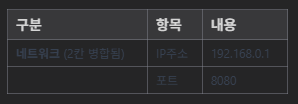
   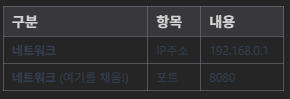

2. **선형화 (문장 변환)**  
   - `<table>`을 문장으로 풀어내기.  
   - 변환 예시:  
     - `"구분: 저장시 대상: 비밀번호 기준: 단방향 암호화"`  
     - `"구분: 저장시 대상: 고유식별정보 기준: 의무적 암호화"`  

3. **Original Text 보존**  
   - `original_text` 컬럼에는 HTML 태그를 그대로 둔다.  
   - 이유: GPT-5 계열 모델은 HTML 구조를 이해할 수 있으므로 원본은 유지.  

---

# 요약  

**“93개 문서(94%)가 병합된 표를 포함한다. 단순 텍스트 추출 시 문맥이 끊겨 검색이 실패한다. 따라서 전처리 코드에서 반드시 `rowspan`을 풀어 값 복사(Grid Expansion)를 적용하고, 표를 문장으로 선형화해 `search_text`를 만들어야 한다. 원본은 HTML 그대로 보존한다.”**

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 2.99단계: 단어 빈도 및 패턴 분석 (도메인 키워드 파악)
# ==========================================================================================================
# 배경: 
#   - 어떤 단어가 많이 나오는지 모르면 검색 키워드 설계 어려움
#   - 반복되는 단어 조합(패턴) 파악 → 노이즈 제거 또는 중요 구문 식별
# 분석 목표:
#   1. 단순 빈도 Top 30 → 가장 많이 등장하는 단어 (불용어 후보, 도메인 키워드)
#   2. Bigram Top 30 → 자주 붙어 다니는 단어쌍 (예: "입찰 참가", "서식 제1호")
#
# 입력: rfp_docs_v2.csv
# 출력: 단어 빈도 통계, Bigram 통계
# 활용: 
#   - 노이즈 단어 식별 (제거 대상)
#   - 도메인 키워드 파악 (검색 질의 예시 작성)
#   - 중요 구문 발견 (메타데이터 강화)
# ==========================================================================================================

# ==========================================
# [설정]
# ==========================================
BASE_PATH = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"

# 분석할 대상 파일 (헤더 복원 완료된 원본 텍스트)
target_csv_path = os.path.join(BASE_PATH, "rfp_docs_v2.csv")

print(f" EDA 시작: {target_csv_path}")

# ==========================================
# [1. 데이터 로드]
# ==========================================
# 목적: CSV에서 텍스트 컬럼 자동 탐지 및 로드
# 처리: full_text, content, text 중 하나를 찾음

try:
    # CSV 로드
    df = pd.read_csv(target_csv_path)
    
    # 텍스트 컬럼 찾기 (여러 가능한 이름 중 하나)
    # next(): 첫 번째 매칭되는 컬럼명 반환
    text_col = next((c for c in df.columns if c in ['full_text', 'content', 'text']), None)
    
    # 텍스트 컬럼이 없으면 에러
    if not text_col:
        raise ValueError("텍스트 컬럼을 찾을 수 없음")
        
    print(f" 데이터 로드 완료: {len(df)}개 문서")
    
    # NaN 처리 (빈 문자열로 대체) 및 리스트 변환
    docs = df[text_col].fillna("").tolist()

except Exception as e:
    # 로드 실패 시 에러 출력 및 빈 리스트
    print(f" 오류 발생: {e}")
    docs = []

# ==========================================
# [2. 텍스트 정제 및 토큰화 (간이)]
# ==========================================
# 목적: 단어 단위로 분리 (토큰화)
# 방법: 특수문자 제거 → 공백 기준 분리
# 주의: 간단한 분석용, 형태소 분석기(Kiwi) 사용 안 함

def simple_tokenizer(text):
    """
    [간이 토크나이저] 특수문자 제거 후 공백 기준 분리
    
    역할: 텍스트 → 단어 리스트
    입력: text (문자열)
    출력: 단어 리스트
    
    처리:
    - 정규식: [^가-힣a-zA-Z0-9\s] (한글, 영문, 숫자, 공백만 남김)
    - 특수문자, 기호 제거 (예: | - , . 등)
    - 공백 기준 분리 (split())
    
    한계:
    - "시스템을" → "시스템을" (조사 제거 안 됨)
    - "입찰참가" → "입찰참가" (복합어 분리 안 됨)
    - 정밀한 분석은 형태소 분석기 필요
    """
    # 특수문자 제거 (공백으로 치환)
    # [^...]: 부정형 (해당하지 않는 문자)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)
    
    # 공백 기준 분리 (여러 공백은 자동으로 하나로 처리)
    return text.split()

# ========================================================
# 전체 텍스트 토큰화 (모든 문서 합쳐서)
# ========================================================
all_tokens = []  # 전체 단어를 담을 리스트

for doc in docs:
    # 각 문서를 토큰화하여 all_tokens에 추가
    all_tokens.extend(simple_tokenizer(doc))

print(f" 전체 단어 수(Tokens): {len(all_tokens):,}개")

# ==========================================
# [3. 빈도 분석 1: 단순 단어 Top 30]
# ==========================================
# 목적: 가장 많이 나타나는 단어 파악
# 활용:
#   - 노이즈 단어 식별 (예: "및", "등", "관련" 등 불용어)
#   - 도메인 키워드 파악 (예: "시스템", "보안", "구축" 등)
#   - 작업 방향 결정 (어떤 주제가 많은지)

# Counter: 리스트에서 각 요소의 개수 카운트
word_counts = Counter(all_tokens)

# most_common(30): 가장 많이 나온 순서대로 30개
top_30_words = word_counts.most_common(30)

# 결과 출력
print("\n" + "="*50)
print(" [단순 빈도] 가장 많이 등장한 단어 Top 30")
print("="*50)
for word, count in top_30_words:
    # 단어를 15자 폭으로 왼쪽 정렬, 카운트는 5자 폭으로 오른쪽 정렬
    print(f"{word:<15} : {count:>5}회")

# 해석:
# - "및", "등", "관련" 많으면: 불용어 제거 고려
# - "시스템", "보안", "데이터" 많으면: IT 도메인 확인
# - "제출", "서류", "입찰" 많으면: 행정 절차 중심

# ==========================================
# [4. 빈도 분석 2: N-gram (2단어 조합) Top 30]
# ==========================================
# 목적: 자주 붙어 다니는 단어 조합 발견
# 예시:
#   - "입찰 참가" (중요 구문)
#   - "서식 제1호" (양식 패턴)
#   - "요구사항 분류" (표 헤더)
#
# 활용:
#   - 중요 구문 파악 → 검색 질의 예시
#   - 반복 패턴 파악 → 노이즈 제거 대상

def get_top_ngrams(corpus, n=2, top_k=30):
    """
    [N-gram 추출] 자주 나타나는 N개 단어 조합 찾기
    
    역할: 전체 문서에서 자주 붙어 다니는 단어 조합 추출
    입력: 
        - corpus: 문서 리스트 (각 문서는 문자열)
        - n: N-gram 크기 (2=단어쌍, 3=3단어 조합)
        - top_k: 상위 몇 개 추출
    출력: [(단어조합, 빈도), ...] 리스트
    
    방법: CountVectorizer 사용
    - ngram_range=(n, n): n개 단어 조합만 추출
    - max_features=top_k: 상위 k개만
    """
    # CountVectorizer: 텍스트 → 단어 빈도 행렬 변환
    # ngram_range=(2, 2): 2개 단어 조합만
    vec = CountVectorizer(ngram_range=(n, n), max_features=top_k).fit(corpus)
    
    # 전체 문서를 Bag of Words 행렬로 변환
    bag_of_words = vec.transform(corpus)
    
    # 각 단어 조합의 전체 빈도 합계 (열 방향 합)
    sum_words = bag_of_words.sum(axis=0)
    
    # (단어조합, 빈도) 튜플 리스트 생성
    # vec.vocabulary_: {단어조합: 인덱스} 딕셔너리
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # 빈도 내림차순 정렬
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq

try:
    # Bigram (2단어 조합) Top 30 추출
    top_bigrams = get_top_ngrams(docs, n=2, top_k=30)
    
    # 결과 출력
    print("\n" + "="*50)
    print(" [패턴 분석] 자주 붙어 다니는 단어쌍 (Bigram) Top 30")
    print("="*50)
    for word, count in top_bigrams:
        # 단어쌍을 20자 폭으로 왼쪽 정렬
        print(f"{word:<20} : {count:>5}회")
    
    # 해석:
    # - "입찰 참가" 많으면: 행정 절차 중심
    # - "보안 요구사항" 많으면: 기술 스펙 중심
    # - "서식 제1호" 많으면: 양식 문서 (노이즈 가능성)

except ValueError:
    # 데이터가 너무 적으면 N-gram 추출 실패
    print(" 데이터가 부족하여 N-gram 분석을 수행할 수 없음")

 EDA 시작: C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV\rfp_docs_v2.csv
 데이터 로드 완료: 98개 문서
 전체 단어 수(Tokens): 2,550,911개

 [단순 빈도] 가장 많이 등장한 단어 Top 30
및               : 59176회
요구사항            : 53269회
td              : 40766회
등               : 19047회
함               : 15533회
수               : 14691회
1               : 13913회
2               : 13206회
경우              : 13029회
tr              : 13006회
한다              : 11956회
또는              : 10953회
대한              : 10686회
시스템             : 10231회
분류              :  9967회
명칭              :  9733회
기능              :  9482회
관리              :  9349회
데이터             :  9105회
고유번호            :  9004회
시               :  8974회
3               :  8594회
관련              :  7797회
따라              :  7727회
본               :  7127회
정의              :  6951회
사업              :  6929회
4               :  6752회
산출정보            :  6699회
관한              :  6658회

 [패턴 분석] 자주 붙어 다니는 단어쌍 (Bigram) Top 30
td td                : 20853회
요구사항 분류             

# 분석  
### 단어 빈도 및 패턴 진단

1. **단순 빈도 Top 30: "HTML 잔해 + 요구사항 중심"**  
   - **HTML 태그 흔적:** `td`, `tr`, `colspan` 같은 태그가 상위권에 대거 등장 → 원문에 HTML 표가 그대로 들어있음을 반영.  
   - **핵심 키워드:** `요구사항(53,269회)`, `시스템(10,231회)`, `데이터(9,105회)`, `보안`, `산출정보` 등 → RFP 문서의 본질이 "요구사항 정의"임을 확인.  
   - **불용어/기능어:** `및`, `등`, `한다`, `또는`, `관한` → 검색 변별력이 낮아 보이나, 임베딩 모델이 문맥으로 처리하므로 제거 불필요.  

2. **Bigram Top 30: "요구사항 패턴의 폭발적 반복"**  
   - **HTML 패턴:** `td td`, `tr td`, `td tr` → 표 구조가 그대로 텍스트로 남아있음.  
   - **요구사항 패턴:** `요구사항 분류`, `요구사항 명칭`, `요구사항 고유번호`, `요구사항 상세설명` → RFP의 표 헤더가 반복적으로 등장.  
   - **중복/노이즈:** `요구사항 요구사항`, `산출정보 산출정보` → 파싱 과정에서 중복된 텍스트가 다수 발생.  
   - **법률·계약 패턴:** `관한 법률`, `계약에 관한`, `하는 계약에` → 규정·법률적 문구가 상당히 많음.  

---

# 시사점  
- **HTML 태그 제거 필요 (필수):** `td`, `tr`, `colspan` 같은 태그는 검색에 불필요한 노이즈. `search_text` 생성 시 반드시 제거.  
- **불용어 처리 (불필요):** `한다`, `또는`, `및`, `등` 같은 기능어는 변별력이 낮아 보이나, **임베딩 모델이 문맥을 고려하므로 제거하지 않음**. 오히려 제거 시 문장이 깨질 위험.  
- **요구사항 헤더 반복 (필수 대응):** "요구사항 분류/명칭/고유번호/상세설명" 같은 헤더가 수천 회 반복 → 검색 시 헤더만 걸리는 문제 발생. 따라서 **표 선형화**로 헤더와 내용을 자연스럽게 연결.  
- **법률/계약 용어 비중 (선택적 대응):** 기술 키워드보다 법률·계약 용어가 압도적으로 많음 → 검색 시 기술 관련 질문이 묻힐 위험. Reranker를 쓸 예정인데 **Reranker가 내용 기반으로 점수를 부여하므로 별도 가중치 전략은 불필요**. 필요 시 메타데이터 필터링으로 대응 가능.  

---

# 결론 (CSV 작업 지침 반영)  

## 필수 조치 (구현 예정)
1. **HTML 태그 제거:** `td`, `tr`, `colspan` 등 완전 제거 (clean_text_for_search 적용)
2. **표 선형화:** 반복되는 요구사항 헤더를 내용과 결합된 평문으로 변환 (linearize_markdown_tables 적용)
3. **Grid Expansion:** rowspan/colspan 해소로 문맥 보존 (expand_html_table_spans 적용)

## 선택 조치 (구현 안 함)
1. **불용어 제거:** 임베딩 모델이 문맥 처리하므로 불필요
2. **가중치 전략:** Reranker가 이미 내용 기반 점수화 중, 추가 불필요
3. **중복 패턴:** 선형화 과정에서 자연스럽게 정리됨

## 핵심 요약
**"단어 빈도 분석 결과, HTML 태그와 표 구조가 주요 노이즈로 등장한다. 따라서 HTML 제거와 표 선형화를 필수로 적용하되, 불용어 제거나 가중치 전략은 임베딩/Reranker가 처리하므로 생략한다."**

# RAG 파이프라인 EDA 최종 요약

## 분석 흐름 (총 9단계)

### 1단계: PDF 파싱
- **작업:** Upstage API로 PDF → Markdown 변환
- **결과:** 98개 프로젝트 파싱 완료, rfp_docs.csv 생성

### 1.5단계: 제목 패턴 분석
- **목적:** h2/h3 헤더 복원 규칙 설계
- **결과:** 로마숫자, 제N장, 1.1, 가. 등 패턴 발견

### 2단계: 헤더 복원
- **작업:** 정규식 기반 h2/h3 태그 자동 삽입
- **결과:** rfp_docs_v2.csv 생성 (헤더 구조 복원)

### 2.5단계: 토큰 수 분석
- **발견:** 
  - 평균 111k 토큰, 최대 334k 토큰
  - 최소값(52k)도 임베딩 제한(8k)의 6.4배
- **결론:** 100% 청킹 필수

### 2.7단계: 헤더 구조 검증
- **발견:**
  - H2/H3 실종 0% → 헤더 복원 성공
  - 거대 섹션 100% (2000자 초과)
  - 최장 섹션 122,605자
- **결론:** RecursiveCharacterTextSplitter 필수

### 2.9단계: 표/리스트 진단
- **발견:**
  - Token/Char 비율 0.88 (한글 1000자 ≈ 884토큰)
  - 거대 표 81개 (최대 7,437자)
  - 모든 문서에 리스트 과다
- **결론:** 
  - chunk_size: 1500자 (약 1300토큰)
  - overlap: 400자 (표 보존)

### 2.95단계: 텍스트 패턴 분석
- **발견:**
  - 반복 문장 Top 1: `| --- |` (평균 70회/문서)
  - 법률/조항 78건 vs 기술 6.2건
  - 최장 문장 5,036자
- **결론:** 표 구분선 제거, 불용어 유지

### 2.98단계: HTML 표 진단
- **발견:** 94% 문서가 HTML 표 포함
- **문제:** rowspan/colspan으로 문맥 단절
- **결론:** Grid Expansion + 표 선형화 필수

### 2.99단계: 단어 빈도 분석
- **발견:**
  - HTML 태그: `td`, `tr`, `colspan` 상위권
  - 요구사항 패턴: `요구사항 분류` (9.8k회)
  - 중복: `요구사항 요구사항` (5.7k회)
- **결론:** HTML 제거 + 표 선형화

---

## 최종 결정 사항

### 청킹 파라미터
- **chunk_size:** 1500자 (약 1300토큰)
- **overlap:** 500자 (표/리스트 맥락 보존)
- **방식:** MarkdownHeaderTextSplitter → RecursiveCharacterTextSplitter

### 전처리 전략 (필수)
1. **HTML 태그 제거** (`td`, `tr`, `colspan` 등)
2. **표 구분선 제거** (`| --- |` 패턴)
3. **표 선형화** (헤더+내용 결합)
4. **Grid Expansion** (rowspan/colspan 해소)
5. **이원화**
   - `search_text`: HTML 제거 + 표 평문화 (임베딩용)
   - `chunk_text`: 표 구조 보존 (LLM용)

### 전처리 전략 (불필요)
1. **불용어 제거** (임베딩 모델이 문맥 처리)
2. **가중치 시스템** (Reranker가 처리)
3. **중복 제거** (선형화 시 자연스럽게 정리)

---

## 예상 결과
- **청크 수:** 약 12,000개
- **최대 문서:** 약 557개 청크
- **검색 품질:** 표 선형화 + H1/H2/H3 구조로 정밀 검색
- **LLM 품질:** 원본 보존으로 구조 유지

# 전처리 된 CSV 생성

### 전처리

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 공통 유틸리티 모듈
# ==========================================================================================================
# 역할: 데이터 전처리, 메타데이터 추출, CSV 로드 등 반복 사용되는 함수 모음
# 
# 핵심 기능:
# 1. HTML 표 처리 (Grid Expansion)
# 2. 표 선형화 (검색 최적화)
# 3. 이원화 전처리 (검색용 vs LLM용)
# 4. 메타데이터 추출 (예산, 날짜, 기관 등)
# 5. CSV 병합 및 로드
#
# 사용처: run_recursive.py, run_semantic.py 등 모든 청킹 파이프라인
# ==========================================================================================================

# =========================================================
# [Common Utility] 데이터 전처리 및 로드 공통 모듈
# =========================================================

def expand_html_table_spans(html_content):
    """
    [핵심 함수] HTML 테이블의 rowspan/colspan을 모두 해제하고 값을 복사하여 채워 넣는다 (Grid Expansion)
    
    배경:
    - Upstage API는 일부 표를 HTML로 파싱함 (<table><tr><td>...)
    - rowspan/colspan으로 병합된 셀은 텍스트 추출 시 값이 누락됨
    - 예: "저장시" 셀이 rowspan=2면 2행에서 "저장시" 값 사라짐
    
    해결책:
    - 병합된 셀 값을 하위 행/열에 복사하여 그리드 확장
    - 모든 셀이 값을 가지도록 만듦 → 문맥 보존
    
    입력: html_content (HTML 문자열, <table> 태그 포함)
    출력: rowspan/colspan 제거된 HTML 문자열
    
    예시:
    입력:
      <table>
        <tr><td rowspan="2">저장시</td><td>비밀번호</td></tr>
        <tr><td>고유식별정보</td></tr>
      </table>
    
    출력:
      <table>
        <tr><td>저장시</td><td>비밀번호</td></tr>
        <tr><td>저장시</td><td>고유식별정보</td></tr>  ← "저장시" 복사됨
      </table>
    """
    # [1] 입력 검증
    if not html_content or not isinstance(html_content, str):
        return ""

    # [2] HTML 파싱 (BeautifulSoup)
    soup = BeautifulSoup(html_content, 'html.parser')
    tables = soup.find_all('table')  # 모든 <table> 태그 찾기

    # [3] 각 테이블 처리
    for table in tables:
        rows = table.find_all('tr')  # 모든 행(<tr>) 찾기
        if not rows: continue  # 빈 테이블은 스킵

        # [4] 그리드 생성 (2차원 리스트)
        # grid[행][열] = 셀 값
        grid = []
        
        for r_idx, row in enumerate(rows):  # 각 행 순회
            while len(grid) <= r_idx: grid.append([])  # 행이 부족하면 추가
            
            cells = row.find_all(['td', 'th'])  # 셀 찾기 (데이터/헤더)
            c_idx = 0  # 현재 열 인덱스
            
            for cell in cells:  # 각 셀 처리
                # 이미 채워진 칸은 건너뛰기 (rowspan으로 채워진 경우)
                while c_idx < len(grid[r_idx]) and grid[r_idx][c_idx] is not None:
                    c_idx += 1
                
                # 셀 정보 추출
                cell_text = cell.get_text(" ", strip=True)  # 텍스트 내용
                rowspan = int(cell.get('rowspan', 1))  # 세로 병합 크기 (기본 1)
                colspan = int(cell.get('colspan', 1))  # 가로 병합 크기 (기본 1)
                
                # [5] Grid Expansion: 병합된 영역에 값 복사
                for r in range(rowspan):  # 세로 방향 복사
                    target_row = r_idx + r
                    while len(grid) <= target_row: grid.append([])  # 행 부족 시 추가
                    
                    for c in range(colspan):  # 가로 방향 복사
                        target_col = c_idx + c
                        # 열 부족 시 추가
                        while len(grid[target_row]) <= target_col:
                            grid[target_row].append(None)
                        # 값 복사
                        grid[target_row][target_col] = cell_text
                
                c_idx += colspan  # 다음 셀 위치로 이동

        # [6] 새 테이블 생성 (rowspan/colspan 없이)
        new_table = soup.new_tag("table")
        for row_data in grid:  # 각 행 데이터
            new_tr = soup.new_tag("tr")
            for cell_text in row_data:  # 각 셀 데이터
                new_td = soup.new_tag("td")
                new_td.string = cell_text if cell_text else ""
                new_tr.append(new_td)
            new_table.append(new_tr)
        
        # [7] 기존 테이블을 새 테이블로 교체
        table.replace_with(new_table)

    return str(soup)  # HTML 문자열로 반환


def linearize_markdown_tables(text):
    """
    [핵심 함수] 모든 Markdown 표를 평문으로 변환 (선형화)
    
    목적:
    - Markdown 표: `| A | B |` 형태는 임베딩 모델이 이해하기 어려움
    - 특수문자(|, ---)는 검색 노이즈로 작용
    - 평문화하여 "A B" 형태로 만들면 검색 성능 향상
    
    처리:
    - HTML에서 변환된 표와 원본 Markdown 표 모두 처리
    - 표 특수문자(|, ---) 제거로 검색 노이즈 감소
    
    입력: text (Markdown 텍스트, 표 포함)
    출력: 표 특수문자 제거된 평문 텍스트
    
    예시:
    입력:
      | 항목 | 값 |
      |------|-----|
      | 예산 | 1억 |
    
    출력:
      항목 값
      예산 1억
    """
    if not isinstance(text, str): return ""
    
    # [1] 파이프(|) 문자를 공백으로 변환
    # 표의 열 구분자 제거
    text = re.sub(r'\|', ' ', text)
    
    # [2] 표 구분선 제거 (--- 또는 --)
    # ^\s*[-\s]+$: 줄 전체가 공백과 하이픈으로만 구성
    # re.MULTILINE: 각 줄마다 적용
    text = re.sub(r'^\s*[-\s]+$', '', text, flags=re.MULTILINE)
    
    # [3] 연속된 공백을 하나로 정리
    # "A    B" → "A B"
    text = re.sub(r' {2,}', ' ', text)
    
    return text


def clean_text_for_search(text):
    """
    [검색용 전처리] 임베딩 최적화를 위한 표 평문화
    
    목적: 검색 전용 텍스트 생성
    전략: 표 완전 평문화 → 임베딩 노이즈 최소화
    
    처리 순서:
    1. HTML 표 Grid Expansion (rowspan/colspan 해소)
    2. HTML → Markdown 변환
    3. Markdown 표 선형화 (| 제거)
    4. 노이즈 정제 (빈 줄, 이미지 링크 제거)
    
    입력: text (원본 텍스트, HTML/Markdown 혼재)
    출력: 평문화된 검색용 텍스트
    
    사용처: search_text 컬럼 생성, 임베딩 벡터 생성
    """
    if not isinstance(text, str): return ""
    
    # ========================================================
    # [1] HTML 표 펼치기 (문맥 보존)
    # ========================================================
    # 목적: rowspan/colspan으로 병합된 셀 값 복사
    # 예외 처리: 잘못된 HTML이 있어도 계속 진행
    try:
        text = expand_html_table_spans(text)
    except Exception:
        pass  # 실패 시 원본 유지

    # ========================================================
    # [2] Markdown 변환
    # ========================================================
    # HTML → Markdown 변환 (markdownify 사용)
    # heading_style="ATX": ## 형식 사용 (Setext 대신)
    # strip=['a', 'img']: 링크, 이미지 제거
    try:
        text = md(text, heading_style="ATX", strip=['a', 'img'])
    except:
        # 변환 실패 시 HTML 태그 제거만
        text = re.sub(r'<[^>]+>', ' ', text)

    # ========================================================
    # [3] Markdown 표 선형화 (검색 노이즈 제거)
    # ========================================================
    # 목적: | --- | 같은 특수문자 제거
    text = linearize_markdown_tables(text)

    # ========================================================
    # [4] 노이즈 정제
    # ========================================================
    # 빈 줄 3개 이상 → 2개로 축소
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 이미지 링크 제거: ![alt](url)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    
    return text.strip()


def clean_text_for_llm(text):
    """
    [LLM용 전처리] 표 구조 보존
    
    목적: LLM 컨텍스트용 텍스트 생성
    전략: 표 구조 유지 → LLM이 구조화된 정보 이해
    
    차이점 (vs clean_text_for_search):
    - 검색용: 표 완전 평문화 (| 제거)
    - LLM용: 표 구조 유지 (| 보존)
    
    처리 순서:
    1. HTML 표 Grid Expansion (동일)
    2. HTML → Markdown 변환 (동일)
    3. 표 구분선 정리 (구조 유지!) ← 차이점
    4. 노이즈 정제 (동일)
    
    입력: text (원본 텍스트)
    출력: 구조 보존된 LLM용 텍스트
    
    사용처: chunk_text 컬럼 생성, LLM 프롬프트 컨텍스트
    """
    if not isinstance(text, str): return ""
    
    # [1] HTML 표 펼치기 (문맥 보존)
    try:
        text = expand_html_table_spans(text)
    except Exception:
        pass 

    # [2] Markdown 변환
    try:
        text = md(text, heading_style="ATX", strip=['a', 'img'])
    except:
        text = re.sub(r'<[^>]+>', ' ', text)

    # ========================================================
    # [3] 표 구분선 정리만 (구조 유지) ← 핵심 차이점
    # ========================================================
    # clean_text_for_search와 다른 점:
    # - | 제거 안 함 (표 구조 보존)
    # - 구분선만 정리 (| --- | 형태 통일)
    text = re.sub(r'\| \-{3,} \|', '| --- |', text)

    # [4] 노이즈 정제
    text = re.sub(r'\n{3,}', '\n\n', text)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    
    return text.strip()


def clean_text_with_markdown(text):
    """
    [하위 호환성] 기존 함수 - 검색용으로 리다이렉트
    
    목적: 기존 코드 호환성 유지
    동작: clean_text_for_search와 동일
    
    사용처: 이전 버전 코드에서 호출 시
    """
    return clean_text_for_search(text)


def is_garbage(text, h1_title):
    """
    [필터링 함수] 의미 없는 청크 필터링
    
    목적: 검색에 불필요한 청크 제거
    제거 대상:
    - 서식, 별지, 신청서 등 양식 문서
    - 밑줄(___), 체크박스(□)만 가득한 빈 서식
    - 너무 짧은 텍스트 (30자 미만)
    
    입력:
        text: 청크 본문
        h1_title: H1 헤더 (예: "# 서식 제1호")
    출력: True (쓰레기) / False (유효)
    
    사용처: 청킹 후 필터링
    """
    # [1] H1 제목 기반 필터링
    garbage_keywords = ['서식', '별지', '신청서', '서약서', '확약서', '위임장', '각서', '목차', 'CONTENTS']
    if any(k in h1_title for k in garbage_keywords):
        return True  # 양식 문서로 판단
    
    # [2] 특수문자 과다 (빈 서식)
    # 밑줄 10개 이상 또는 체크박스 5개 이상
    if text.count('_') > 10 or text.count('□') > 5:
        return True
    
    # [3] 너무 짧은 텍스트
    if len(text.strip()) < 30:
        return True
    
    return False  # 유효한 청크


def extract_metadata(row):
    """
    [메타데이터 추출] 행 데이터에서 프로젝트 정보 추출 및 정제
    
    목적: CSV 행 → 구조화된 메타데이터 딕셔너리
    처리:
    - 안전한 컬럼 접근 (없어도 오류 안 남)
    - 예산 정제 (수의계약 판단)
    - 특이사항 문구 생성
    
    입력: row (DataFrame의 한 행, pd.Series)
    출력: 메타데이터 딕셔너리
    
    사용처: 청킹 시 각 청크에 메타데이터 주입
    """
    # ========================================================
    # [1] 프로젝트 ID (필수)
    # ========================================================
    project_id = str(row['project_id']).strip()
    
    # ========================================================
    # [2] 사업명 (여러 컬럼명 대응)
    # ========================================================
    # 병합 후 컬럼명이 달라질 수 있으므로 여러 이름 시도
    # _x, _y: pandas merge 시 중복 컬럼에 자동 붙는 접미사
    title = str(row.get('사업명') or row.get('title') or row.get('사업명_x') or row.get('사업명_y') or "제목없음").strip()
    
    # ========================================================
    # [3] 공고번호
    # ========================================================
    page_no = str(row.get('공고 번호') or row.get('공고번호') or "").strip()
    
    # ========================================================
    # [4] 예산 (정제된 값 사용)
    # ========================================================
    # load_and_merge_data에서 이미 정제됨 (쉼표 제거, 숫자 변환)
    budget_val = row.get('사업 금액_정제', 0)
    
    # 수의계약 판단 (0원 또는 1원)
    is_private = budget_val <= 1
    
    # ========================================================
    # [5] 수의계약 특이사항 문구 생성
    # ========================================================
    special_note = ""
    if is_private:
        # 수의계약으로 판단 → 특이사항 문구 추가
        special_note = "[특이사항: 본 공고는 수의시담 또는 직찰 건으로 예산이 0원(또는 1원)으로 표기되었으며, 실제 금액은 협상 대상입니다.]"
        budget_str = "금액 미정(규격공개/수의계약 등)"
    else:
        # 일반 계약 → 금액 표시
        budget_str = f"{budget_val:,}원"
    
    # ========================================================
    # [6] 날짜, 기관, 기타
    # ========================================================
    end_date = str(row.get('입찰 참여 마감일') or row.get('마감일') or row.get('공개 일자') or "미정").strip()
    agency = str(row.get('발주 기관') or row.get('발주기관') or "미정").strip()
    pub_date = str(row.get('공개_월', '')).strip()
    
    # 폴더명 추출 (경로에서 마지막 부분)
    folder_name = str(row.get('folder_path', '')).split('\\')[-1]
    
    # Full Text
    full_text = str(row.get('full_text', row.get('content', '')))

    # [7] 딕셔너리 반환
    return {
        'project_id': project_id,
        'title': title,
        'page_no': page_no,
        'budget_str': budget_str,  # 표시용 문자열
        'budget_val': budget_val,  # 숫자 값
        'is_private_contract': is_private,  # 수의계약 여부
        'special_note': special_note,  # 특이사항 문구
        'end_date': end_date,
        'agency': agency,
        'pub_date': pub_date,
        'folder_name': folder_name,
        'full_text': full_text
    }


def load_and_merge_data(metadata_path, fulltext_path):
    """
    [데이터 로드] CSV 로드, 병합 및 '사업 금액' 전처리 로직 수행
    
    목적: 두 개의 CSV를 병합하여 하나의 DataFrame 생성
    처리:
    1. 메타데이터 CSV 로드 (사업명, 예산, 날짜 등)
    2. 전문 텍스트 CSV 로드 (full_text)
    3. project_id 기준으로 병합
    4. 예산 컬럼 정제 (쉼표 제거, 숫자 변환)
    
    입력:
        metadata_path: 메타데이터 CSV 경로
        fulltext_path: 전문 텍스트 CSV 경로
    출력: 병합된 DataFrame
    
    사용처: 모든 청킹 파이프라인의 시작
    """
    print(" 데이터 로드 중...")
    
    try:
        # ========================================================
        # [1] CSV 로드
        # ========================================================
        df_meta = pd.read_csv(metadata_path).fillna("")  # NaN → 빈 문자열
        df_text = pd.read_csv(fulltext_path).fillna("")
        
        # ========================================================
        # [2] 컬럼명 정리
        # ========================================================
        # 공백 제거 (복사-붙여넣기 시 생길 수 있음)
        df_meta.columns = df_meta.columns.str.strip()
        df_text.columns = df_text.columns.str.strip()
        
        # 컬럼명 통일 (title → 사업명)
        if 'title' in df_text.columns:
            df_text.rename(columns={'title':'사업명'}, inplace=True)
        
        # ========================================================
        # [3] 병합 키 전처리
        # ========================================================
        # project_id를 문자열로 변환 후 공백 제거
        # (숫자로 저장되었을 수도 있음)
        df_meta['project_id'] = df_meta['project_id'].astype(str).str.strip()
        df_text['project_id'] = df_text['project_id'].astype(str).str.strip()
        
        # ========================================================
        # [4] 병합 (INNER JOIN)
        # ========================================================
        # project_id 기준으로 병합
        # how='inner': 양쪽에 모두 있는 것만 (교집합)
        df_merged = pd.merge(df_text, df_meta, on='project_id', how='inner')
        
        # ========================================================
        # [5] 사업 금액 전처리 (중요)
        # ========================================================
        if '사업 금액' in df_merged.columns:
            # 쉼표, "원" 제거
            # "1,000,000원" → "1000000"
            df_merged['사업 금액_정제'] = df_merged['사업 금액'].astype(str).str.replace(',', '').str.replace('원', '').str.strip()
            
            # 숫자로 변환 (실패 시 0)
            # errors='coerce': 변환 실패 시 NaN
            # fillna(0): NaN → 0
            # astype(int): 정수 변환
            df_merged['사업 금액_정제'] = pd.to_numeric(df_merged['사업 금액_정제'], errors='coerce').fillna(0).astype(int)
            
            print(f"    사업 금액 정제 완료 (숫자 변환)")
            
        print(f" 병합 완료: 총 {len(df_merged)}개 문서")
        return df_merged
        
    except Exception as e:
        # 로드 실패 시 에러 출력 및 예외 발생
        print(f" 데이터 로드 실패: {e}")
        raise

# ==========================================================================================================
# [사용 예시]
# ==========================================================================================================
# from common_utils import load_and_merge_data, extract_metadata, clean_text_for_search
# 
# # 1. 데이터 로드
# df = load_and_merge_data("metadata.csv", "fulltext.csv")
# 
# # 2. 각 행 처리
# for idx, row in df.iterrows():
#     meta = extract_metadata(row)
#     search_text = clean_text_for_search(meta['full_text'])
#     llm_text = clean_text_for_llm(meta['full_text'])
# ==========================================================================================================

### Markdown + Recursive Chunk

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 3단계: Recursive 방식 청킹 (H1 기반 + 강제 분할)
# ==========================================================================================================
# 배경: EDA에서 파악한 데이터 특성 기반 청킹 전략 구현
#   - 모든 문서가 8191 토큰 초과 → 청킹 필수
#   - H2/H3 구조 복원 완료 → 계층 기반 분할 가능
#   - 거대 섹션 존재 (122k자) → Recursive 강제 분할 필수
#   - HTML 표 94% → Grid Expansion + 선형화 필요
#
# 전략:
#   1. MarkdownHeaderTextSplitter: H1 기준 1차 분할 (의미 단위)
#   2. RecursiveCharacterTextSplitter: 1500자 기준 강제 분할 (크기 제한)
#   3. 이원화: search_text(평문화) vs chunk_text(구조 보존)
# ==========================================
# [설정] Recursive Pipeline
# ==========================================
BASE_PATH = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"

# 입력 파일
metadata_csv_path = os.path.join(BASE_PATH, "data_list_v3_base.csv")  # 메타데이터 (사업명, 예산 등)
fulltext_csv_path = os.path.join(BASE_PATH, "rfp_docs.csv")  # 전문 텍스트

# 출력 파일
output_csv_path = os.path.join(BASE_PATH, "rag_chunks_recursive.csv")  # 최종 청크 CSV

# ========================================================
# 청킹 파라미터 (EDA 결과 기반 결정)
# ========================================================
CHUNK_SIZE = 1500  # 문자 수 기준
CHUNK_OVERLAP = 500  # 오버랩 (표 보존을 위해 큰 값 설정)
MAX_WORKERS = 8  # 병렬 처리 워커 수

# ========================================================
# 분할기 초기화
# ========================================================
# [1] MarkdownHeaderTextSplitter: H1 기준 1차 분할
# 목적: 헤더 구조를 활용하여 의미 단위로 문서 분할
# 설정: H1(#)만 사용 (H2/H3는 RecursiveCharacterTextSplitter가 처리)
md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "h1")])

# [2] RecursiveCharacterTextSplitter: 크기 기반 강제 분할
# 목적: H1 섹션이 1500자 초과 시 강제로 자름
# 설정:
#   - chunk_size=1500: EDA에서 결정 (Token/Char 비율 0.88 고려)
#   - chunk_overlap=500: 표/리스트 맥락 보존 (평균 표 길이 1860자의 27%)
#   - separators: 분할 우선순위 (빈 줄 → 줄바꿈 → 공백 → 강제)
rec_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=CHUNK_OVERLAP,
    separators=["\n\n", "\n", " ", ""]  # 우선순위: 빈 줄 > 줄바꿈 > 공백 > 강제
)


def process_project_recursive(row_data):
    """
    [핵심 함수] 프로젝트 하나를 청킹 (Recursive 방식)
    
    역할: 
    1. 메타데이터 추출
    2. 전처리 (이원화: 검색용/LLM용)
    3. H1 기준 1차 분할
    4. Recursive 2차 분할 (크기 제한)
    5. 메타데이터 주입
    6. 중복 제거
    
    입력: row_data (idx, row) 튜플
    출력: 청크 리스트 (딕셔너리 리스트)
    
    병렬 처리: ThreadPoolExecutor에서 실행됨
    """
    idx, row = row_data
    
    # ========================================================
    # [1] 공통 메타데이터 추출 (common_utils.extract_metadata)
    # ========================================================
    # 목적: 프로젝트 정보 구조화 (사업명, 예산, 날짜 등)
    # 특히: 수의계약 판단 (예산 0원/1원) 및 특이사항 문구 생성
    meta = extract_metadata(row)
    
    # 너무 짧은 텍스트는 스킵
    if len(meta['full_text']) < 100:
        return []
    
    # ========================================================
    # [2] 전처리 (이원화 전략)
    # ========================================================
    # 목적: 검색용(평문화) vs LLM용(구조 보존) 텍스트 생성
    
    # 검색용: HTML 제거 + 표 평문화 (임베딩 최적화)
    # - expand_html_table_spans (Grid Expansion)
    # - linearize_markdown_tables (| 제거)
    search_text_base = clean_text_for_search(meta['full_text'])
    
    # LLM용: 표 구조 보존 (LLM이 표 이해 가능)
    # - expand_html_table_spans (Grid Expansion만)
    # - 표 구조(|) 유지
    llm_text_base = clean_text_for_llm(meta['full_text'])
    
    # ========================================================
    # [3] 분할 Step 1: MD Header (H1 기준)
    # ========================================================
    # 목적: 문서를 H1 헤더 기준으로 의미 단위 분할
    # 예: "# 1. 사업개요", "# 2. 기술요구사항" 등으로 분리
    try:
        # LLM 텍스트 기준으로 청킹 (표 구조 보존된 버전)
        # 이유: 헤더 구조는 LLM용 텍스트에 있음
        md_docs = md_splitter.split_text(llm_text_base)
    except:
        # 분할 실패 시 전체를 하나의 문서로 (헤더 없는 경우)
        from langchain.schema import Document
        md_docs = [Document(page_content=llm_text_base, metadata={'h1': '일반'})]

    # ========================================================
    # [4] 분할 Step 2: Recursive (크기 기준 강제 분할)
    # ========================================================
    chunks = []  # 최종 청크 리스트
    chunk_seq = 0  # 청크 순번
    seen_hashes = set()  # 중복 제거용 해시 집합
    
    for doc in md_docs:  # 각 H1 섹션 순회
        # H1 헤더 추출 (메타데이터 주입용)
        h1 = doc.metadata.get('h1', '본문')
        
        # Recursive 분할: H1 섹션이 1500자 초과 시 강제로 자름
        # 결과: 문자열 리스트 (각 청크는 최대 1500자)
        raw_chunks = rec_splitter.split_text(doc.page_content)
        
        for chunk_text in raw_chunks:  # 각 청크 처리
            # ========================================================
            # [5] 필터링: 쓰레기 청크 제거
            # ========================================================
            # is_garbage: 서식, 별지, 밑줄만 있는 빈 양식 등 제거
            if is_garbage(chunk_text, h1):
                continue
            
            # ========================================================
            # [6] 중복 제거 (해시 기반)
            # ========================================================
            # 목적: 동일한 텍스트가 여러 번 청킹되는 것 방지
            # 방법: MD5 해시로 중복 판단
            chunk_hash = hashlib.md5(chunk_text.encode('utf-8')).hexdigest()
            if chunk_hash in seen_hashes:
                continue
            seen_hashes.add(chunk_hash)
            
            # ========================================================
            # [7] 검색용 텍스트 재생성 (평문화)
            # ========================================================
            # 청크 단위로도 평문화 적용 (표가 포함된 경우 대비)
            chunk_text_for_search = clean_text_for_search(chunk_text)
            
            # 수의계약 힌트 주입 (검색용)
            # 목적: 검색 시 "예산 미정" 정보가 상위 노출되도록
            if meta['special_note']:
                chunk_text_for_search = f"{meta['special_note']}\n{chunk_text_for_search}"
            
            # ========================================================
            # [8] LLM용 텍스트 정리 (구조 보존)
            # ========================================================
            # 수의계약 힌트 주입 (LLM용)
            # LLM이 답변 생성 시 "예산 미정" 언급하도록
            chunk_text_final = chunk_text
            if meta['special_note']:
                chunk_text_final = f"--- 공고 정보 ---\n{meta['special_note']}\n--------------------\n\n{chunk_text}"
            
            # ========================================================
            # [9] 메타데이터 주입 (검색용 프롬프트)
            # ========================================================
            # 목적: 청크마다 프로젝트 정보를 명시하여 검색 정확도 향상
            # 형식: 구조화된 메타데이터 블록 + 본문
            search_text = (
                f"[[프로젝트 정보]]\n"
                f"사업명: {meta['title']}\n"
                f"발주기관: {meta['agency']}\n"
                f"예산: {meta['budget_str']}\n"
                f"마감일: {meta['end_date']}\n"
                f"섹션: {h1}\n"  # H1 헤더 (예: "1. 사업개요")
                f"내용:\n{chunk_text_for_search}"
            )
            
            # ========================================================
            # [10] 청크 딕셔너리 생성
            # ========================================================
            chunks.append({
                # 고유 ID
                'chunk_id': f"{meta['project_id']}_chk_{chunk_seq:04d}",
                'project_id': meta['project_id'],
                
                # 텍스트 (이원화)
                'search_text': search_text,  # 검색용: 평문화 + 메타데이터 + special_note
                'chunk_text': chunk_text_final,  # LLM용: 표 구조 보존 + special_note
                
                # 메타데이터
                'metadata_h1': h1,  # H1 헤더
                '사업명': meta['title'],
                '공고번호': meta['page_no'],
                '입찰마감일': meta['end_date'],
                '사업금액': meta['budget_str'],  # 문자열 (표시용)
                '사업금액_num': meta['budget_val'],  # 숫자 (필터링용)
                '발주기관': meta['agency'],
                '공개_월': meta['pub_date'],
                'folder_name': meta['folder_name'],
                
                # 통계
                '청크길이': len(chunk_text),
                'split_method': 'recursive'  # 청킹 방식 표시
            })
            chunk_seq += 1  # 순번 증가
            
    return chunks  # 프로젝트의 모든 청크 반환


# ========================================================
# [메인 실행] 병렬 청킹 파이프라인
# ========================================================
if __name__ == "__main__":
    print(f" [Recursive] 처리 시작 (Workers: {MAX_WORKERS})")
    
    # ========================================================
    # [1] 데이터 로드 및 병합 (common_utils 사용)
    # ========================================================
    # 목적: 메타데이터 + 전문 텍스트 병합
    # 처리: 예산 정제, project_id 통일 등
    df_merged = load_and_merge_data(metadata_csv_path, fulltext_csv_path)
    
    # DataFrame → (idx, row) 튜플 리스트 (병렬 처리용)
    rows = list(df_merged.iterrows())
    
    # ========================================================
    # [2] 병렬 청킹 실행 (ThreadPoolExecutor)
    # ========================================================
    final_data = []  # 모든 청크를 담을 리스트
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # map: 각 row에 대해 process_project_recursive 실행
        # tqdm: 진행률 표시
        results = list(tqdm(executor.map(process_project_recursive, rows), total=len(rows)))
    
    # ========================================================
    # [3] 결과 수집 (평탄화)
    # ========================================================
    # results: 프로젝트별 청크 리스트의 리스트
    # [[chunk1, chunk2], [chunk3, chunk4], ...]
    # → [chunk1, chunk2, chunk3, chunk4, ...]
    for res in results:
        final_data.extend(res)

    # ========================================================
    # [4] CSV 저장
    # ========================================================
    if final_data:
        # 리스트 → DataFrame
        df_final = pd.DataFrame(final_data)
        
        # CSV 저장
        # - encoding='utf-8-sig': Excel 호환 (BOM 포함)
        # - quoting=csv.QUOTE_NONNUMERIC: 숫자 외 모든 값 따옴표 처리 (콤마/줄바꿈 보존)
        df_final.to_csv(output_csv_path, index=False, encoding='utf-8-sig', quoting=csv.QUOTE_NONNUMERIC)
        
        print(f" [Recursive] 완료: {len(df_final):,}개 청크 → {output_csv_path}")
    else:
        print(" 생성된 데이터 없음")


# - 컬럼 구조:
#   - chunk_id: 고유 ID
#   - search_text: 평문화 + 메타데이터 (임베딩용)
#   - chunk_text: 표 구조 보존 (LLM용)
#   - 메타데이터: 사업명, 예산, 날짜, H1 등
# - 다음 단계: Qdrant 인덱싱, 검색 테스트

 [Recursive] 처리 시작 (Workers: 8)
 데이터 로드 중...
    사업 금액 정제 완료 (숫자 변환)
 병합 완료: 총 98개 문서


100%|██████████| 98/98 [00:08<00:00, 12.23it/s]


 [Recursive] 완료: 12,421개 청크 -> C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV\rag_chunks_recursive.csv


### Markdown + Semantic Chunk

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 3-B단계: Semantic 방식 청킹 (의미 기반 분할)
# ==========================================================================================================
# 배경: Recursive 방식의 대안으로 의미 기반 청킹 제공
#   - Recursive: 고정 크기(1500자) 기준 분할 → 문맥 단절 가능성
#   - Semantic: 의미 변화 지점 기준 분할 → 자연스러운 경계
#
# 장점:
#   - 의미적으로 관련된 내용이 한 청크에 모임
#   - 문장/단락 중간에서 잘리지 않음
#   - 주제 전환 지점에서 자연스럽게 분할
#
# 단점:
#   - 임베딩 API 호출 필요 (비용 증가, 속도 느림)
#   - 청크 크기 불균일 (일부 청크가 너무 크거나 작을 수 있음)
#
# 비교:
#   - Recursive: 빠름, 저렴, 크기 균일, 문맥 단절 가능
#   - Semantic: 느림, 비쌈, 크기 불균일, 의미 보존 우수
#
# 용도: Recursive와 비교 평가, 검색 품질 테스트
# ==========================================================================================================

# ==========================================
# [설정] Semantic Pipeline
# ==========================================
BASE_PATH = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"

# 입력 파일
metadata_csv_path = os.path.join(BASE_PATH, "data_list_v3_base.csv")
fulltext_csv_path = os.path.join(BASE_PATH, "rfp_docs.csv")

# 출력 파일
output_csv_path = os.path.join(BASE_PATH, "rag_chunks_semantic.csv")

# ========================================================
# Semantic 청킹 파라미터
# ========================================================
# SEMANTIC_THRESHOLD: 의미 변화 민감도 (백분위 기준)
# - 값이 높을수록(95): 큰 의미 변화만 인정 → 큰 청크
# - 값이 낮을수록(50): 작은 의미 변화도 인정 → 작은 청크
# - 85: 상위 15% 의미 변화 지점에서만 분할 (적당한 크기)
SEMANTIC_THRESHOLD = 85

# MAX_WORKERS: Semantic은 API 호출이 많아 워커 수 적게 설정
# - Recursive는 8개, Semantic은 4개 (API 속도 제한 고려)
MAX_WORKERS = 4

# ========================================================
# 임베딩 모델 로드
# ========================================================
# 목적: Semantic 분할 시 문장 간 유사도 계산용
# 모델: text-embedding-3-small (OpenAI)
# 비용: Recursive보다 추가 비용 발생
print(" OpenAI 임베딩 모델 로드 중...")
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# SemanticChunker 초기화
# breakpoint_threshold_type="percentile": 백분위 기준 사용
# breakpoint_threshold_amount=85: 상위 15% 의미 변화 지점
semantic_splitter = SemanticChunker(
    embeddings=embedding_model,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=SEMANTIC_THRESHOLD
)

# MarkdownHeaderTextSplitter (Recursive와 동일)
md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "h1")])


def process_project_semantic(row_data):
    """
    [핵심 함수] 프로젝트 하나를 청킹 (Semantic 방식)
    
    차이점 (vs process_project_recursive):
    - Recursive: RecursiveCharacterTextSplitter (고정 크기)
    - Semantic: SemanticChunker (의미 기반)
    
    역할:
    1. 메타데이터 추출
    2. 전처리 (이원화: 검색용/LLM용)
    3. H1 기준 1차 분할
    4. Semantic 2차 분할 (의미 변화 지점) ← 차이점
    5. 메타데이터 주입
    6. 중복 제거
    
    입력: row_data (idx, row) 튜플
    출력: 청크 리스트
    """
    idx, row = row_data
    
    # ========================================================
    # [1] 메타데이터 추출 (Recursive와 동일)
    # ========================================================
    meta = extract_metadata(row)
    
    if len(meta['full_text']) < 100:
        return []
    
    # ========================================================
    # [2] 전처리 (이원화 - Recursive와 동일)
    # ========================================================
    search_text_base = clean_text_for_search(meta['full_text'])  # 검색용: 평문화
    llm_text_base = clean_text_for_llm(meta['full_text'])  # LLM용: 표 구조 보존
    
    # ========================================================
    # [3] 분할 Step 1: MD Header (H1 기준 - Recursive와 동일)
    # ========================================================
    try:
        md_docs = md_splitter.split_text(llm_text_base)
    except:
        from langchain.schema import Document
        md_docs = [Document(page_content=llm_text_base, metadata={'h1': '일반'})]

    chunks = []
    chunk_seq = 0
    seen_hashes = set()
    
    for doc in md_docs:
        h1 = doc.metadata.get('h1', '본문')
        
        # ========================================================
        # [4] 분할 Step 2: Semantic (의미 기반) ← 핵심 차이점
        # ========================================================
        # 전략:
        # - 짧은 섹션(300자 미만): 그대로 사용 (API 호출 낭비 방지)
        # - 긴 섹션: Semantic 분할 (의미 변화 지점 탐지)
        
        if len(doc.page_content) < 300:
            # 너무 짧으면 그대로 사용 (Semantic 분할 불필요)
            final_sub_chunks = [doc.page_content]
        else:
            # Semantic 분할 실행
            try:
                # 동작 원리:
                # 1. 문장 단위로 분리
                # 2. 각 문장 임베딩 생성 (API 호출!)
                # 3. 인접 문장 간 유사도 계산
                # 4. 유사도가 급격히 떨어지는 지점 = 의미 변화 = 분할 지점
                # 5. THRESHOLD(85) 이상 변화 시 분할
                final_sub_chunks = semantic_splitter.split_text(doc.page_content)
            except:
                # API 오류 등 실패 시 원본 그대로 사용
                final_sub_chunks = [doc.page_content]
        
        # ========================================================
        # [5~10] 필터링, 중복 제거, 메타데이터 주입 (Recursive와 동일)
        # ========================================================
        for chunk_text in final_sub_chunks:
            # [5] 쓰레기 필터링
            if is_garbage(chunk_text, h1):
                continue
            
            # [6] 중복 제거
            chunk_hash = hashlib.md5(chunk_text.encode('utf-8')).hexdigest()
            if chunk_hash in seen_hashes:
                continue
            seen_hashes.add(chunk_hash)
            
            # [7] 검색용 텍스트 재생성 (평문화)
            chunk_text_for_search = clean_text_for_search(chunk_text)
            
            # 수의계약 힌트 주입 (검색용)
            if meta['special_note']:
                chunk_text_for_search = f"{meta['special_note']}\n{chunk_text_for_search}"
            
            # [8] LLM용 텍스트 정리 (구조 보존)
            chunk_text_final = chunk_text
            if meta['special_note']:
                chunk_text_final = f"--- 공고 정보 ---\n{meta['special_note']}\n--------------------\n\n{chunk_text}"
            
            # [9] 메타데이터 주입 (검색용 프롬프트)
            search_text = (
                f"[[프로젝트 정보]]\n"
                f"사업명: {meta['title']}\n"
                f"발주기관: {meta['agency']}\n"
                f"예산: {meta['budget_str']}\n"
                f"마감일: {meta['end_date']}\n"
                f"섹션: {h1}\n"
                f"내용:\n{chunk_text_for_search}"
            )
            
            # [10] 청크 딕셔너리 생성
            chunks.append({
                # 고유 ID (Recursive와 구분: _sem_)
                'chunk_id': f"{meta['project_id']}_sem_{chunk_seq:04d}",
                'project_id': meta['project_id'],
                
                # 텍스트 (이원화)
                'search_text': search_text,
                'chunk_text': chunk_text_final,
                
                # 메타데이터
                'metadata_h1': h1,
                '사업명': meta['title'],
                '공고번호': meta['page_no'],
                '입찰마감일': meta['end_date'],
                '사업금액': meta['budget_str'],
                '사업금액_num': meta['budget_val'],
                '발주기관': meta['agency'],
                '공개_월': meta['pub_date'],
                'folder_name': meta['folder_name'],
                
                # 통계
                '청크길이': len(chunk_text),
                'split_method': 'semantic'  # 청킹 방식 표시 (비교용)
            })
            chunk_seq += 1
            
    return chunks


# ========================================================
# [메인 실행] 병렬 청킹 파이프라인 (Recursive와 동일)
# ========================================================
if __name__ == "__main__":
    print(f" [Semantic] 처리 시작 (Workers: {MAX_WORKERS})")
    
    # [1] 데이터 로드 및 병합
    df_merged = load_and_merge_data(metadata_csv_path, fulltext_csv_path)
    rows = list(df_merged.iterrows())
    
    # [2] 병렬 청킹 실행
    final_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(tqdm(executor.map(process_project_semantic, rows), total=len(rows)))
    
    # [3] 결과 수집
    for res in results:
        final_data.extend(res)

    # [4] CSV 저장
    if final_data:
        df_final = pd.DataFrame(final_data)
        df_final.to_csv(output_csv_path, index=False, encoding='utf-8-sig', quoting=csv.QUOTE_NONNUMERIC)
        
        print(f" [Semantic] 완료: {len(df_final):,}개 청크 → {output_csv_path}")
        
        # 통계 출력 (Recursive와 비교용)
        avg_length = df_final['청크길이'].mean()
        std_length = df_final['청크길이'].std()
        print(f" 청크 길이 통계: 평균 {avg_length:.0f}자 (표준편차 {std_length:.0f})")
    else:
        print(" 생성된 데이터 없음")

# ==========================================================================================================
# [Recursive vs Semantic 비교]
# ==========================================================================================================
# 항목              | Recursive                    | Semantic
# -------------------|------------------------------|-----------------------------
# 분할 기준          | 고정 크기(1500자)             | 의미 변화 지점
# 청크 크기          | 균일 (1500±500)              | 불균일 (100~3000 가능)
# 문맥 보존          | 보통 (overlap로 보완)         | 우수 (자연스러운 경계)
# 처리 속도          | 빠름 (로컬 처리)              | 느림 (API 호출)
# 비용              | 무료                         | 임베딩 비용 발생
# 검색 정확도        | 좋음                         | 좋음 (예상)
# 
# 권장 사용:
# - Recursive: 대량 데이터, 빠른 처리, 비용 절감
# - Semantic: 높은 검색 품질 요구, 소량 데이터, 비용 여유
# ==========================================================================================================

 OpenAI 임베딩 모델 로드 중...
 [Semantic] 처리 시작 (Workers: 4)
 데이터 로드 중...
   (공통) 사업 금액 정제 완료 (숫자 변환)
 병합 완료: 총 98개 문서


  0%|          | 0/98 [00:00<?, ?it/s]2025-12-21 18:47:16,368 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:16,409 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:16,565 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:16,751 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:16,851 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:17,214 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:17,276 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:17,376 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 18:47:17,968 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"

 [Semantic] 완료: 15,035개 청크 -> C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV\rag_chunks_semantic.csv


## 하이브리드 서치 & 리랭킹 파이프라인

### Markdown + Recursive 하이브리드 서치 + 리랭킹

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 4단계: Hybrid 검색 + 고급 필터링 + Reranking
# ==========================================================================================================
# 배경: 단순 검색으로는 정확한 결과 도출 어려움
#   - 날짜 조건 ("2024년 상반기")
#   - 금액 조건 ("1억 이하")
#   - 수의계약 구분
#   - 프로젝트 중복 제거
#
# 전략: 3단계 파이프라인
#   1. Hybrid Retrieval (Dense + Sparse 결합)
#   2. Hard Filtering (날짜/금액/수의계약)
#   3. Reranking + Diversity (정확도 향상 + 중복 제거)
#
# 입력: rag_chunks_recursive.csv (청킹 완료)
# 출력: 검색 결과 (최대 5개, 프로젝트 중복 없음)
# 다음 단계: LLM 답변 생성
# ==========================================================================================================

# ==========================================
# [설정]
# ==========================================
BASE_PATH = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"
csv_path = os.path.join(BASE_PATH, "rag_chunks_recursive.csv")  # 청킹 완료된 CSV

QDRANT_PATH = "./local_qdrant_db"  # Qdrant 로컬 저장 경로
COLLECTION_NAME = "rfp_recursive_search"  # 컬렉션 이름

# 모델 설정
EMBEDDING_MODEL_NAME = "text-embedding-3-small"  # OpenAI 임베딩 (Dense)
RERANKER_MODEL_NAME = "BAAI/bge-reranker-v2-m3"  # HuggingFace Reranker

# ========================================================
# Hybrid 검색 가중치
# ========================================================
# Dense (의미 검색): 0.7 → 주요 검색 방식
# Sparse (키워드 검색): 0.3 → 보조 검색
# 이유: RFP는 전문 용어 많아 의미 검색 우선, 키워드도 놓치지 않기 위해 혼합
WEIGHT_DENSE = 0.7
WEIGHT_SPARSE = 0.3

# ========================================================
# 검색 파라미터
# ========================================================
TOP_K_RETRIEVAL = 50  # 1차 검색에서 가져올 문서 수 (필터링 전)
TOP_K_FINAL = 5  # 최종 반환할 문서 수 (Reranking + Diversity 후)

print("="*70)
print(f" RAG 검색 파이프라인 (Hybrid + Advanced Filtering + Reranking)")
print("="*70)

# ==========================================
# [1. 데이터 로드 및 수의계약 태깅]
# ==========================================
print("\n1. CSV 데이터 로드 및 수의계약 태깅 중...")

# CSV 로드
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path).fillna("")
    print(f" 데이터 로드 완료: {len(df)}개 청크")
else:
    raise FileNotFoundError(f" 파일을 찾을 수 없음: {csv_path}")

# ========================================================
# Document 객체 생성 (LangChain 형식)
# ========================================================
# 목적: 
# 1. 수의계약 특이사항 주입 (search_text, chunk_text 모두)
# 2. 메타데이터 구조화 (필터링용)
documents = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Document 변환"):
    # ========================================================
    # [1-1] 금액 판별 및 수의계약 태깅
    # ========================================================
    # 목적: 예산 0원/1원 → 수의계약으로 판단 → 특이사항 문구 생성
    budget_num = int(row.get('사업금액_num', 0))  # 숫자 값
    budget_str = str(row.get('사업금액', '0원'))  # 문자열 (표시용)
    
    # 수의계약 판단 (0원 또는 1원)
    special_note = ""
    is_private = budget_num <= 1
    
    if is_private:
        # 특이사항 문구 생성
        special_note = "[특이사항: 본 공고는 수의시담 또는 직찰 건으로 예산이 0원(또는 1원)으로 표기되었으며, 실제 금액은 협상 대상입니다.]"
        price_display = "금액 미정(수의계약/직찰)"
    else:
        price_display = budget_str

    # ========================================================
    # [1-2] 검색용 텍스트에 힌트 주입
    # ========================================================
    # 목적: 검색 시 "수의계약" 키워드가 매칭되도록
    page_content = str(row.get('search_text', ''))
    if special_note:
        page_content = f"{special_note}\n{page_content}"
    
    # ========================================================
    # [1-3] LLM 답변용 원문에도 힌트 주입
    # ========================================================
    # 목적: LLM이 답변 생성 시 "예산 미정" 언급하도록
    original_chunk = str(row.get('chunk_text', ''))
    if special_note:
        original_chunk = f"--- 공고 정보 ---\n{special_note}\n----------------\n\n{original_chunk}"

    # ========================================================
    # [1-4] 메타데이터 구조화
    # ========================================================
    metadata = {
        # 식별자
        "chunk_id": row.get('chunk_id'),
        "project_id": str(row.get('project_id')),
        
        # 텍스트 (LLM용, 특이사항 주입된 버전)
        "chunk_text": original_chunk,
        
        # 프로젝트 정보
        "source": row.get('folder_name'),
        "title": row.get('사업명'),
        "h1": row.get('metadata_h1'),
        
        # 날짜 (필터링용)
        "pub_date": str(row.get('공개_월', '')),
        "end_date": str(row.get('입찰마감일', '')),
        
        # 기타
        "agency": row.get('발주기관', ''),
        
        # 금액 (필터링용)
        "price_str": price_display,  # 화면 표시용
        "사업금액_num": budget_num,  # 필터링용 (숫자)
        
        # 수의계약 플래그 (필터링용)
        "is_private_contract": is_private
    }
    
    # Document 객체 생성 (page_content + metadata)
    documents.append(Document(page_content=page_content, metadata=metadata))

# ==========================================
# [2. Hybrid Searcher 구축]
# ==========================================
print("\n2. Hybrid Searcher(Dense + Sparse) 구축 중...")

# ========================================================
# [2-1] Dense Retriever (Qdrant - Vector DB)
# ========================================================
# 목적: 의미 기반 검색 (임베딩 유사도)
# 장점: "비밀번호 암호화" ≈ "패스워드 해싱" 매칭 가능
print("   [Dense] Qdrant 인덱싱...")

# 임베딩 모델 로드
embedding = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# Qdrant 클라이언트 (로컬 저장)
client = QdrantClient(path=QDRANT_PATH)

# 기존 컬렉션 삭제 (재실행 시)
if client.collection_exists(COLLECTION_NAME):
    client.delete_collection(COLLECTION_NAME)

# 새 컬렉션 생성
# size=1536: text-embedding-3-small의 벡터 차원
# distance=COSINE: 코사인 유사도 사용
client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Qdrant VectorStore 초기화
qdrant_store = QdrantVectorStore(
    client=client,
    collection_name=COLLECTION_NAME,
    embedding=embedding,
)

# ========================================================
# 배치 처리로 데이터 삽입 (메모리 효율)
# ========================================================
# 이유: 한 번에 모든 문서 삽입 시 메모리 부족 가능
# 방법: 100개씩 나누어 삽입
batch_size = 100
for i in tqdm(range(0, len(documents), batch_size), desc="Qdrant 삽입"):
    batch = documents[i : i + batch_size]
    qdrant_store.add_documents(batch)  # 임베딩 생성 + 벡터 저장

# Dense Retriever 생성
# search_kwargs={"k": 50}: 최대 50개 반환
dense_retriever = qdrant_store.as_retriever(search_kwargs={"k": TOP_K_RETRIEVAL})

# ========================================================
# [2-2] Sparse Retriever (BM25 - 키워드 검색)
# ========================================================
# 목적: 키워드 정확 매칭
# 장점: "비밀번호" 검색 시 "비밀번호" 정확히 포함된 문서 우선
print("   [Sparse] BM25 인덱싱...")

# BM25 인덱스 생성 (TF-IDF 기반)
bm25_retriever = BM25Retriever.from_documents(documents)
bm25_retriever.k = TOP_K_RETRIEVAL  # 최대 50개 반환

# ========================================================
# [2-3] Ensemble (Hybrid 결합)
# ========================================================
# 목적: Dense(의미) + Sparse(키워드) 결과를 가중 평균
# weights=[0.3, 0.7]: Sparse 30%, Dense 70%
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, dense_retriever],
    weights=[WEIGHT_SPARSE, WEIGHT_DENSE]
)

print(" 검색기 구축 완료")

# ==========================================
# [3. Reranker 로드]
# ==========================================
print(f"\n3. Reranker 모델 로드 ({RERANKER_MODEL_NAME})...")

# GPU 사용 가능 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"

# CrossEncoder 로드 (HuggingFace)
# 목적: 질의-문서 쌍의 관련도 점수 재계산
# 장점: Hybrid 검색보다 정확도 높음
reranker_model = CrossEncoder(RERANKER_MODEL_NAME, device=device)

print(f" Device: {device}")

# ==========================================
# [4. 핵심 기능 함수 (필터링 & 리랭킹)]
# ==========================================

def filter_by_date(docs, query):
    """
    [날짜 필터] 날짜 관련 조건으로 필터링 (CSV 메타데이터 기준)
    
    지원 패턴:
    - 연도: "2024년", "2025년"
    - 월: "3월", "10월"
    - 반기: "상반기" (1~6월), "하반기" (7~12월)
    - 분기: "1분기", "2분기", "3분기", "4분기"
    
    입력: 
        docs: Document 리스트 (검색 결과)
        query: 사용자 질의 (날짜 조건 포함)
    출력: 필터링된 Document 리스트
    
    동작:
    1. 정규식으로 날짜 조건 추출
    2. 메타데이터(end_date, pub_date)와 비교
    3. 매칭되는 문서만 반환
    """
    import re
    
    filtered = docs
    filter_applied = False
    
    # ========================================================
    # [1] 연도 필터
    # ========================================================
    # 패턴: "2024년" 또는 "2024"
    years = re.findall(r'(20\d{2})년?', query)
    if years:
        target_year = years[0]  # 첫 번째 연도 사용
        temp_filtered = []
        
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            
            # 연도가 end_date 또는 pub_date에 포함되는지 확인
            if target_year in end_date or target_year in pub_date:
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] 연도 '{target_year}' 감지 → {len(filtered)}개 문서")
    
    # ========================================================
    # [2] 월 필터
    # ========================================================
    # 패턴: "3월", "10월"
    month_match = re.search(r'(\d{1,2})월', query)
    if month_match:
        target_month = month_match.group(1).zfill(2)  # "3" → "03"
        temp_filtered = []
        
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            
            # "-03" 또는 "3월" 형식 매칭
            if f"-{target_month}" in end_date or f"{target_month}월" in end_date or \
               f"-{target_month}" in pub_date or f"{target_month}월" in pub_date:
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] 월 '{target_month}월' 감지 → {len(filtered)}개 문서")
    
    # ========================================================
    # [3] 반기 필터
    # ========================================================
    # 상반기: 1~6월
    if '상반기' in query:
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            
            # 1~6월 중 하나라도 매칭되면 포함
            if any(f"-{m:02d}" in end_date or f"{m}월" in end_date or 
                   f"-{m:02d}" in pub_date or f"{m}월" in pub_date 
                   for m in range(1, 7)):
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] '상반기' 감지 → {len(filtered)}개 문서")
    
    # 하반기: 7~12월
    elif '하반기' in query:
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            
            # 7~12월 중 하나라도 매칭되면 포함
            if any(f"-{m:02d}" in end_date or f"{m}월" in end_date or 
                   f"-{m:02d}" in pub_date or f"{m}월" in pub_date 
                   for m in range(7, 13)):
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] '하반기' 감지 → {len(filtered)}개 문서")
    
    # ========================================================
    # [4] 분기 필터
    # ========================================================
    # 패턴:  "1분기", "2분기", "3분기", "4분기"
    quarter_match = re.search(r'([1-4])분기', query)
    if quarter_match:
        quarter = int(quarter_match.group(1))
        
        # 분기별 월 범위
        month_ranges = {
            1: range(1, 4),   # 1분기: 1~3월
            2: range(4, 7),   # 2분기: 4~6월
            3: range(7, 10),  # 3분기: 7~9월
            4: range(10, 13)  # 4분기: 10~12월
        }
        
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            
            # 해당 분기 월 중 하나라도 매칭되면 포함
            if any(f"-{m:02d}" in end_date or f"{m}월" in end_date or 
                   f"-{m:02d}" in pub_date or f"{m}월" in pub_date 
                   for m in month_ranges[quarter]):
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] '{quarter}분기' 감지 → {len(filtered)}개 문서")
    
    # 필터 적용되었으면 결과 반환, 아니면 원본 반환
    return filtered if filter_applied else docs


def parse_budget_from_query(query):
    """
    [금액 파서] 쿼리에서 복잡한 금액 패턴 추출
    
    지원 패턴:
    - "1억 5천만원" → 150,000,000
    - "5,000만원" → 50,000,000
    - "3억" → 300,000,000
    - "7천만원" → 70,000,000
    
    입력: query (사용자 질의)
    출력: (금액, 연산자) 튜플
        - 금액: 정수 (예: 150000000)
        - 연산자: "이상" 또는 "이하"
    
    동작:
    1. 콤마/공백 제거
    2. 억/천만/백만 단위별로 파싱
    3. 합산
    4. 연산자 판단 ("이상", "이하")
    """
    import re
    
    # 콤마 및 공백 제거 (파싱 편의)
    q = query.replace(',', '').replace(' ', '')
    
    amount = 0
    
    # ========================================================
    # [1] '억' 단위 파싱
    # ========================================================
    # 패턴: "3억" → 3 * 100,000,000
    uk_match = re.search(r'(\d+)억', q)
    if uk_match:
        amount += int(uk_match.group(1)) * 100_000_000
    
    # ========================================================
    # [2] '천만' 단위 파싱
    # ========================================================
    # 패턴: "5천만" → 5 * 10,000,000
    # 주의: "1억5천" 같은 복합 패턴 지원
    cheon_match = re.search(r'(?:억)?(\d+)천', q)
    if cheon_match:
        amount += int(cheon_match.group(1)) * 10_000_000
    
    # ========================================================
    # [3] '백만' 단위 파싱
    # ========================================================
    # 패턴: "5백만원" → 5 * 1,000,000
    baek_match = re.search(r'(\d+)백만', q)
    if baek_match:
        amount += int(baek_match.group(1)) * 1_000_000
    
    # ========================================================
    # [4] 연산자 판단
    # ========================================================
    # 기본값: "이하"
    op = '이하'
    
    # "이상" 키워드 감지
    if any(word in q for word in ['이상', '초과', '넘는', '보다큰']):
        op = '이상'
    # "이하" 키워드 감지
    elif any(word in q for word in ['이하', '미만', '안되는', '보다작은']):
        op = '이하'
    
    return amount, op


def filter_by_budget(docs, query):
    """
    [금액 필터] 금액 조건으로 필터링
    
    입력: 
        docs: Document 리스트
        query: 사용자 질의 (금액 조건 포함)
    출력: 필터링된 Document 리스트
    
    동작:
    1. parse_budget_from_query로 금액/연산자 추출
    2. 메타데이터(사업금액_num)와 비교
    3. 수의계약(0/1원) 제외
    4. 조건 만족하는 문서만 반환
    """
    # 금액 파싱
    amount, operator = parse_budget_from_query(query)
    
    # 금액 조건 없으면 원본 반환
    if amount == 0:
        return docs
    
    filtered = []
    for doc in docs:
        budget_num = doc.metadata.get('사업금액_num', 0)
        
        # ========================================================
        # 수의계약(0/1원) 제외
        # ========================================================
        # 이유: "1억 이하" 검색 시 수의계약 포함되면 안 됨
        if budget_num <= 1:
            continue
        
        # ========================================================
        # 조건 판단
        # ========================================================
        if operator == '이하' and budget_num <= amount:
            filtered.append(doc)
        elif operator == '이상' and budget_num >= amount:
            filtered.append(doc)
    
    print(f"   [Budget Filter] '{amount:,}원 {operator}' → {len(filtered)}개")
    return filtered


def filter_private_contracts(docs, query):
    """
    [수의계약 필터] '수의계약' 또는 '직찰' 의도 감지 시 해당 문서만 선별
    
    입력:
        docs: Document 리스트
        query: 사용자 질의
    출력: 필터링된 Document 리스트
    
    동작:
    - 질의에 "수의계약" 또는 "직찰" 포함 시
    - is_private_contract=True인 문서만 반환
    """
    if "수의계약" in query or "직찰" in query:
        filtered = [doc for doc in docs if doc.metadata.get('is_private_contract') == True]
        
        if filtered:
            print(f"   [Private Filter] '수의계약/직찰' 의도 감지 → {len(filtered)}개 문서 선별")
            return filtered
    
    return docs  # 조건 없으면 원본 반환


def get_diverse_top_k(scored_docs, k=5):
    """
    [다양성 필터] 프로젝트 도배 방지
    
    목적: 동일 프로젝트의 여러 청크가 결과를 독점하는 것 방지
    전략: 프로젝트당 최대 1개 청크만 반환
    
    입력: scored_docs (Document, Score) 튜플 리스트 (정렬됨)
    출력: 다양성 필터링된 리스트 (최대 k개)
    
    예시:
    입력: [(proj_A_chk1, 0.9), (proj_A_chk2, 0.85), (proj_B_chk1, 0.8)]
    출력: [(proj_A_chk1, 0.9), (proj_B_chk1, 0.8)]  # A는 1개만
    """
    final_results = []
    seen_projects = set()  # 이미 포함된 프로젝트 ID
    
    for doc, score in scored_docs:
        p_id = doc.metadata.get('project_id')
        
        # 이미 포함된 프로젝트면 스킵
        if p_id in seen_projects:
            continue
        
        # 새 프로젝트면 추가
        final_results.append((doc, score))
        seen_projects.add(p_id)
        
        # k개 채우면 종료
        if len(final_results) >= k:
            break
            
    return final_results


def search_and_rerank(query, debug=True):
    """
    [메인 검색 함수] Hybrid 검색 + 필터링 + Reranking + Diversity
    
    파이프라인:
    1. Hybrid Retrieval (Dense + Sparse, 50개)
    2. Hard Filtering (날짜 → 금액 → 수의계약)
    3. Reranking (CrossEncoder, 점수 재계산)
    4. Diversity (프로젝트 중복 제거, Top 5)
    
    입력: query (사용자 질의), debug (로그 출력 여부)
    출력: [(Document, Score), ...] 리스트 (최대 5개)
    """
    if debug:
        print("\n" + "="*60)
        print(f" Q: {query}")
        print("="*60)

    # ========================================================
    # [1] Hybrid Retrieval (1차 검색)
    # ========================================================
    # Dense(의미) + Sparse(키워드) 결과를 가중 평균
    # 최대 50개 반환
    retrieved_docs = ensemble_retriever.invoke(query)
    
    if debug:
        print(f"   1. 1차 검색 결과: {len(retrieved_docs)}개")
    
    # ========================================================
    # [2] Hard Filtering 단계 (순서 중요)
    # ========================================================
    # 순서: 날짜 → 금액 → 수의계약
    # 이유: 날짜가 가장 선택적, 금액은 추가 필터, 수의계약은 마지막
    
    filtered_docs = filter_by_date(retrieved_docs, query)      # 날짜 필터
    filtered_docs = filter_by_budget(filtered_docs, query)     # 금액 필터
    filtered_docs = filter_private_contracts(filtered_docs, query)  # 수의계약 필터
    
    # 필터링 결과가 0건이면 원본 사용 (안전장치)
    if not filtered_docs:
        print("   [Warning] 필터링 결과 0건 → 원본 사용")
        filtered_docs = retrieved_docs
    elif debug and len(filtered_docs) < len(retrieved_docs):
        print(f"   2. 필터링 후: {len(filtered_docs)}개 남음")

    # ========================================================
    # [3] Reranking (정확도 향상)
    # ========================================================
    if not filtered_docs:
        return []
    
    # 질의-문서 쌍 생성 (제목 포함으로 정확도 향상)
    # 형식: "제목: [제목]\n내용: [본문]"
    # 이유: 제목에 핵심 키워드 많아 Reranker 성능 향상
    pairs = [[query, f"제목: {doc.metadata['title']}\n내용: {doc.page_content}"] 
             for doc in filtered_docs]
    
    # Reranker 점수 계산 (CrossEncoder)
    # 반환: 각 쌍의 관련도 점수 (높을수록 관련도 높음)
    scores = reranker_model.predict(pairs)
    
    # 점수 기준 내림차순 정렬
    scored_docs = sorted(list(zip(filtered_docs, scores)), key=lambda x: x[1], reverse=True)

    # ========================================================
    # [4] Diversity Filter (중복 제거)
    # ========================================================
    # 프로젝트당 최대 1개 청크만 반환
    final_docs = get_diverse_top_k(scored_docs, k=TOP_K_FINAL)

    # ========================================================
    # [5] 결과 출력 (디버그 모드)
    # ========================================================
    if debug:
        print(f"   3. 최종 결과 (Reranking + Diversity): Top {len(final_docs)}\n")
        print(f" {'[순위]':<6} {'[점수]':<8} {'[금액]':<25} {'[제목]':<30}")
        print("-" * 85)
        
        for i, (doc, score) in enumerate(final_docs):
            title = doc.metadata.get('title', '')[:25]  # 25자까지만
            price = doc.metadata.get('price_str', '미정')[:22]
            print(f" {i+1:<6} {score:.4f}   {price:<25} {title:<30}")
            print("-" * 85)

    return final_docs

# ==========================================
# [5. 테스트 실행]
# ==========================================

# 테스트 1: 복합 조건 (날짜 + 수의계약 + 금액)
search_and_rerank("2025년 상반기 수의계약 건들 중에서 1억 이하 사업 찾아줘")

# 테스트 2: 금액만
search_and_rerank("5천만원 이상 보안 시스템 사업 추천해줘")

# 테스트 3: 날짜 + 분기
search_and_rerank("2024년 3분기 학사시스템 구축 사업")

 RAG 검색 파이프라인 (Hybrid + Advanced Filtering + Reranking)

1. CSV 데이터 로드 및 수의계약 태깅 중...
 데이터 로드 완료: 10190개 청크


Document 변환: 100%|██████████| 10190/10190 [00:00<00:00, 38486.82it/s]



2. Hybrid Searcher(Dense + Sparse) 구축 중...
   [Dense] Qdrant 인덱싱...


2025-12-21 19:00:33,596 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Qdrant 삽입:   0%|          | 0/102 [00:00<?, ?it/s]2025-12-21 19:00:35,505 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 19:00:38,109 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Qdrant 삽입:   1%|          | 1/102 [00:05<08:50,  5.25s/it]2025-12-21 19:00:40,043 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 19:00:42,285 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Qdrant 삽입:   2%|▏         | 2/102 [00:09<07:41,  4.62s/it]2025-12-21 19:00:44,285 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-21 19:00:46,342 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Qdrant 삽입:   3%|▎         | 3/102 [00:13<07:12,  4.37s/it]2025-12-21 19:00:48,907 - I

   [Sparse] BM25 인덱싱...
 검색기 구축 완료

3. Reranker 모델 로드 (BAAI/bge-reranker-v2-m3)...
 Device: cuda

 Q: 2025년 상반기 수의계약 건들 중에서 1억 이하 사업 찾아줘


2025-12-21 19:08:13,464 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


   1. 1차 검색 결과: 89개
   [Date Filter] 연도 '2025' 감지 → 4개 문서
   [Date Filter] '상반기' 감지 → 4개 문서
   [Budget Filter] '100,000,000원 이하' → 0개
   [Warning] 필터링 결과 0건 -> 원본 사용


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

   3. 최종 결과 (Reranking + Diversity): Top 5

 [순위]   [점수]     [금액]                      [제목]                          
-------------------------------------------------------------------------------------
 1      0.0645   689,480,000원              철도인프라 디지털트윈 정보화전략계획(ISP)      
-------------------------------------------------------------------------------------
 2      0.0489   1,400,000,000원            (긴급)「2024년도 차세대 응급의료 상황관리     
-------------------------------------------------------------------------------------
 3      0.0414   미정                        2025년도 중이온가속기용 극저온시스템 운전      
-------------------------------------------------------------------------------------
 4      0.0313   금액 미정(수의계약/직찰)            예약발매시스템 개량 ISMP 용역            
-------------------------------------------------------------------------------------
 5      0.0285   금액 미정(수의계약/직찰)            모바일오피스 시스템 고도화 용역(총체 및 1차     
----------------------------------------------------------------------------------

2025-12-21 19:08:20,985 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


   1. 1차 검색 결과: 92개
   [Budget Filter] '50,000,000원 이상' → 70개
   2. 필터링 후: 70개 남음


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

   3. 최종 결과 (Reranking + Diversity): Top 5

 [순위]   [점수]     [금액]                      [제목]                          
-------------------------------------------------------------------------------------
 1      0.0381   150,000,000원              KUSF 체육특기자 경기기록 관리시스템 개발      
-------------------------------------------------------------------------------------
 2      0.0371   211,000,000원              대학재정정보시스템(기본재산 및 기채 사후관리)     
-------------------------------------------------------------------------------------
 3      0.0362   738,820,000원              2025년 통합접수시스템 운영              
-------------------------------------------------------------------------------------
 4      0.0355   230,000,000원              서민금융진흥원 서민금융 채팅 상담시스템 구축      
-------------------------------------------------------------------------------------
 5      0.0339   500,000,000원              적십자병원 병원정보 재해복구시스템 구축 용역      
----------------------------------------------------------------------------------

2025-12-21 19:08:25,920 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


   1. 1차 검색 결과: 80개
   [Date Filter] 연도 '2024' 감지 → 78개 문서
   [Date Filter] '3분기' 감지 → 9개 문서
   2. 필터링 후: 9개 남음


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   3. 최종 결과 (Reranking + Diversity): Top 4

 [순위]   [점수]     [금액]                      [제목]                          
-------------------------------------------------------------------------------------
 1      0.9666   11,270,000,000원           차세대 포털·학사 정보시스템 구축사업          
-------------------------------------------------------------------------------------
 2      0.2697   미정                        인천공항운영서비스㈜ 차세대 ERP시스템 구축      
-------------------------------------------------------------------------------------
 3      0.1700   미정                        대전대학교 2024학년도 다층적 융합 학습경험     
-------------------------------------------------------------------------------------
 4      0.1414   미정                        전문대학 혁신지원사업 서영대학교 차세대 교육혁     
-------------------------------------------------------------------------------------


[(Document(metadata={'chunk_id': 'proj_008_chk_0031', 'project_id': 'proj_008', 'chunk_text': '방식 및 환경의 이슈 등으로 활용도가 저하되어 있음-31-- ① AI선배 서비스 모델 정비 (Python 개발 인력 필수)\n### ② AI선배 서비스를 새로 구축하는 포털에서 바로 접근할 수 있도록 구축\n### ③ 학생의 정보와 연계하여 포털에서 바로 추천 정보를 보여줄 수 있도록 사용자\n- 활용 방식을 변경하여 포털 서비스에 접목\n-32-# III 사업 추진방안# 1 . 추진 목표❏ 교육환경 변화를 반영한 시스템 구축으로 대학의 교육역량 강화를 위한 기반\n제공- ❍ 새로운 융복합 교육 환경에 맞는 학사정보시스템 구축\n- ❍ 입학에서 졸업까지 전 과정의 선발, 학적정보/변동, 교육과정, 등록, 수업,\n- 이수성적, 장학수혜, 졸업/진급 등의 데이터를 효과적으로 연계, 조회/활용을 위한\n- 정보시스템 구축으로 대학 역량 강화\n- ❍ 국문 수준의 영문 서비스 제공으로 내국인과 동등한 외국인 구성원의 정보획득\n- 기회 보장 및 국제 경쟁력 강화\n- ❍ 대학의 중요 사안에 대한 의사결정과 신속·정확한 경영정보 제공을 통한\n- 전략경영 기반 마련\n❏ 사용자 편의성 향상 및 업무 효율성 극대화를 위한 시스템 통합 및 연계 강화- ❍ 사용자 중심의 UI 표준화 및 정보서비스 제공\n- ❍ 포털시스템을 활용한 개인화된 메뉴관리 및 업무지원\n- ❍ 대내외 시스템 연계 및 신규 업무시스템 도입을 고려한 시스템 구축\n❏ 최신 정보기술을 적용한 대학 행정 및 사용자 중심의 정보시스템 사용 환경\n구현- ❍ 최신기술 적용을 통한 미래기술 환경적인 제약 해소\n- ❍ 최신개발 트렌드, 개발 생산성, 확장성 등을 고려한 프레임워크 개발 및 운영환경\n- 고도화\n-33-❏ 목표시스템 구성도 (1단계)  \n-34-# 2. 추진 일정# ❏ 계약 체결일로부터 24개월 이내| 구분(월) | M | 

### Markdown + Semantic 하이브리드 서치 + 리랭킹

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 4-B단계: Hybrid 검색 (Semantic 청킹 버전)
# ==========================================================================================================
# 배경: Recursive 청킹 대신 Semantic 청킹 결과로 검색 성능 비교 테스트
# 
# 차이점:
# - Recursive 버전: rag_chunks_recursive.csv (고정 크기 1500자)
# - Semantic 버전: rag_chunks_semantic.csv (의미 변화 지점 기준) ← 이 파일
#
# 검색 파이프라인 자체는 100% 동일:
# 1. Hybrid Retrieval (Dense + Sparse)
# 2. Hard Filtering (날짜/금액/수의계약)
# 3. Reranking + Diversity
#
# 목적: Recursive vs Semantic 청킹 방식의 검색 품질 비교
# 예상: Semantic이 의미 단위로 나뉘어 검색 정확도 더 높을 것
#
# 입력: rag_chunks_semantic.csv (Semantic 청킹 결과)
# 출력: 검색 결과 (테스트용)
# 다음 단계: 두 방식 비교 분석, 최종 방식 선택
# ==========================================================================================================

# ==========================================
# [설정]
# ==========================================
BASE_PATH = r"C:\AI Projects\codeit\코드잇 AI\프로젝트\중급 프로젝트\Clean_data\CSV"

# ========================================================
# Semantic 청킹 결과 사용 (차이점!)
# ========================================================
csv_path = os.path.join(BASE_PATH, "rag_chunks_semantic.csv")  # Semantic 버전!

QDRANT_PATH = "./local_qdrant_db"  # Qdrant 로컬 저장 경로
COLLECTION_NAME = "rfp_recursive_search"  # 컬렉션 이름 (동일)

# 모델 설정 (Recursive와 동일)
EMBEDDING_MODEL_NAME = "text-embedding-3-small"
RERANKER_MODEL_NAME = "BAAI/bge-reranker-v2-m3"

# Hybrid 검색 가중치 (Recursive와 동일)
WEIGHT_DENSE = 0.7
WEIGHT_SPARSE = 0.3

# 검색 파라미터 (Recursive와 동일)
TOP_K_RETRIEVAL = 50
TOP_K_FINAL = 5

print("="*70)
print(f" RAG 검색 파이프라인 (Semantic 청킹 버전)")
print(f"    Hybrid + Advanced Filtering + Reranking")
print("="*70)

# ==========================================
# [1. 데이터 로드 및 수의계약 태깅]
# ==========================================
# (Recursive 버전과 100% 동일, 주석 생략)
print("\n1. CSV 데이터 로드 및 수의계약 태깅 중...")

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path).fillna("")
    print(f" 데이터 로드 완료: {len(df)}개 청크 (Semantic 청킹)")
else:
    raise FileNotFoundError(f" 파일을 찾을 수 없음: {csv_path}")

documents = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Document 변환"):
    # 금액 판별 및 수의계약 태깅
    budget_num = int(row.get('사업금액_num', 0))
    budget_str = str(row.get('사업금액', '0원'))
    
    special_note = ""
    is_private = budget_num <= 1
    if is_private:
        special_note = "[특이사항: 본 공고는 수의시담 또는 직찰 건으로 예산이 0원(또는 1원)으로 표기되었으며, 실제 금액은 협상 대상입니다.]"
        price_display = "금액 미정(수의계약/직찰)"
    else:
        price_display = budget_str

    # 검색용 텍스트에 힌트 주입
    page_content = str(row.get('search_text', ''))
    if special_note:
        page_content = f"{special_note}\n{page_content}"
    
    # LLM 답변용 원문에도 힌트 주입
    original_chunk = str(row.get('chunk_text', ''))
    if special_note:
        original_chunk = f"--- 공고 정보 ---\n{special_note}\n----------------\n\n{original_chunk}"

    metadata = {
        "chunk_id": row.get('chunk_id'),
        "project_id": str(row.get('project_id')),
        "chunk_text": original_chunk,
        "source": row.get('folder_name'),
        "title": row.get('사업명'),
        "h1": row.get('metadata_h1'),
        "pub_date": str(row.get('공개_월', '')),
        "end_date": str(row.get('입찰마감일', '')),
        "agency": row.get('발주기관', ''),
        "price_str": price_display,
        "사업금액_num": budget_num,
        "is_private_contract": is_private
    }
    documents.append(Document(page_content=page_content, metadata=metadata))

# ==========================================
# [2. Hybrid Searcher 구축]
# ==========================================
# (Recursive 버전과 100% 동일, 주석 생략)
print("\n2. Hybrid Searcher(Dense + Sparse) 구축 중...")

# Dense (Qdrant)
print("   [Dense] Qdrant 인덱싱...")
embedding = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)
client = QdrantClient(path=QDRANT_PATH)

if client.collection_exists(COLLECTION_NAME):
    client.delete_collection(COLLECTION_NAME)

client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

qdrant_store = QdrantVectorStore(
    client=client,
    collection_name=COLLECTION_NAME,
    embedding=embedding,
)

# 배치 처리로 데이터 삽입
batch_size = 100
for i in tqdm(range(0, len(documents), batch_size), desc="Qdrant 삽입"):
    batch = documents[i : i + batch_size]
    qdrant_store.add_documents(batch)

dense_retriever = qdrant_store.as_retriever(search_kwargs={"k": TOP_K_RETRIEVAL})

# Sparse (BM25)
print("   [Sparse] BM25 인덱싱...")
bm25_retriever = BM25Retriever.from_documents(documents)
bm25_retriever.k = TOP_K_RETRIEVAL

# Ensemble
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, dense_retriever],
    weights=[WEIGHT_SPARSE, WEIGHT_DENSE]
)
print(" 검색기 구축 완료")

# ==========================================
# [3. Reranker 로드]
# ==========================================
# (Recursive 버전과 100% 동일, 주석 생략)
print(f"\n3. Reranker 모델 로드 ({RERANKER_MODEL_NAME})...")
device = "cuda" if torch.cuda.is_available() else "cpu"
reranker_model = CrossEncoder(RERANKER_MODEL_NAME, device=device)
print(f" Device: {device}")

# ==========================================
# [4. 핵심 기능 함수 (필터링 & 리랭킹)]
# ==========================================
# (Recursive 버전과 100% 동일, 주석 생략)

def filter_by_date(docs, query):
    """날짜 필터 (연도/월/반기/분기)"""
    import re
    
    filtered = docs
    filter_applied = False
    
    # 연도 필터
    years = re.findall(r'(20\d{2})년?', query)
    if years:
        target_year = years[0]
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            if target_year in end_date or target_year in pub_date:
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] 연도 '{target_year}' 감지 → {len(filtered)}개 문서")
    
    # 월 필터
    month_match = re.search(r'(\d{1,2})월', query)
    if month_match:
        target_month = month_match.group(1).zfill(2)
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            if f"-{target_month}" in end_date or f"{target_month}월" in end_date or \
               f"-{target_month}" in pub_date or f"{target_month}월" in pub_date:
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] 월 '{target_month}월' 감지 → {len(filtered)}개 문서")
    
    # 반기 필터
    if '상반기' in query:
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            if any(f"-{m:02d}" in end_date or f"{m}월" in end_date or 
                   f"-{m:02d}" in pub_date or f"{m}월" in pub_date 
                   for m in range(1, 7)):
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] '상반기' 감지 → {len(filtered)}개 문서")
    
    elif '하반기' in query:
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            if any(f"-{m:02d}" in end_date or f"{m}월" in end_date or 
                   f"-{m:02d}" in pub_date or f"{m}월" in pub_date 
                   for m in range(7, 13)):
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] '하반기' 감지 → {len(filtered)}개 문서")
    
    # 분기 필터
    quarter_match = re.search(r'([1-4])분기', query)
    if quarter_match:
        quarter = int(quarter_match.group(1))
        month_ranges = {
            1: range(1, 4),
            2: range(4, 7),
            3: range(7, 10),
            4: range(10, 13)
        }
        
        temp_filtered = []
        for doc in filtered:
            end_date = str(doc.metadata.get('end_date', ''))
            pub_date = str(doc.metadata.get('pub_date', ''))
            if any(f"-{m:02d}" in end_date or f"{m}월" in end_date or 
                   f"-{m:02d}" in pub_date or f"{m}월" in pub_date 
                   for m in month_ranges[quarter]):
                temp_filtered.append(doc)
        
        if temp_filtered:
            filtered = temp_filtered
            filter_applied = True
            print(f"   [Date Filter] '{quarter}분기' 감지 → {len(filtered)}개 문서")
    
    return filtered if filter_applied else docs


def parse_budget_from_query(query):
    """금액 파서 (억/천만/백만 단위)"""
    import re
    
    q = query.replace(',', '').replace(' ', '')
    
    amount = 0
    
    # 억 단위
    uk_match = re.search(r'(\d+)억', q)
    if uk_match:
        amount += int(uk_match.group(1)) * 100_000_000
    
    # 천만 단위
    cheon_match = re.search(r'(?:억)?(\d+)천', q)
    if cheon_match:
        amount += int(cheon_match.group(1)) * 10_000_000
    
    # 백만 단위
    baek_match = re.search(r'(\d+)백만', q)
    if baek_match:
        amount += int(baek_match.group(1)) * 1_000_000
    
    # 연산자 판단
    op = '이하'
    if any(word in q for word in ['이상', '초과', '넘는', '보다큰']):
        op = '이상'
    elif any(word in q for word in ['이하', '미만', '안되는', '보다작은']):
        op = '이하'
    
    return amount, op


def filter_by_budget(docs, query):
    """금액 필터"""
    amount, operator = parse_budget_from_query(query)
    if amount == 0:
        return docs
    
    filtered = []
    for doc in docs:
        budget_num = doc.metadata.get('사업금액_num', 0)
        
        # 수의계약 제외
        if budget_num <= 1:
            continue
        
        if operator == '이하' and budget_num <= amount:
            filtered.append(doc)
        elif operator == '이상' and budget_num >= amount:
            filtered.append(doc)
    
    print(f"   [Budget Filter] '{amount:,}원 {operator}' → {len(filtered)}개 문서 필터링")
    return filtered if filtered else docs


def filter_private_contracts(docs, query):
    """수의계약 필터"""
    if "수의계약" in query or "직찰" in query:
        filtered = [doc for doc in docs if doc.metadata.get('is_private_contract') == True]
        if filtered:
            print(f"   [Private Filter] '수의계약/직찰' 의도 감지 → {len(filtered)}개 문서 선별")
            return filtered
    return docs


def get_diverse_top_k(scored_docs, k=5):
    """다양성 필터 (프로젝트 중복 제거)"""
    final_results = []
    seen_projects = set()
    
    for doc, score in scored_docs:
        p_id = doc.metadata.get('project_id')
        
        if p_id in seen_projects:
            continue
            
        final_results.append((doc, score))
        seen_projects.add(p_id)
        
        if len(final_results) >= k:
            break
            
    return final_results


def search_and_rerank(query, debug=True):
    """메인 검색 함수 (Hybrid + Filtering + Reranking + Diversity)"""
    if debug:
        print("\n" + "="*60)
        print(f" Q: {query}")
        print("="*60)

    # 1. Hybrid Retrieval
    retrieved_docs = ensemble_retriever.invoke(query)
    if debug:
        print(f"   1. 1차 검색 결과: {len(retrieved_docs)}개")
    
    # 2. Hard Filtering
    filtered_docs = filter_by_date(retrieved_docs, query)
    filtered_docs = filter_by_budget(filtered_docs, query)
    filtered_docs = filter_private_contracts(filtered_docs, query)
    
    if not filtered_docs:
        print("   [Warning] 필터링 결과 0건 → 원본 사용")
        filtered_docs = retrieved_docs
    elif debug and len(filtered_docs) < len(retrieved_docs):
        print(f"   2. 필터링 후: {len(filtered_docs)}개 남음")

    # 3. Reranking
    if not filtered_docs:
        return []
    
    pairs = [[query, f"제목: {doc.metadata['title']}\n내용: {doc.page_content}"] 
             for doc in filtered_docs]
    scores = reranker_model.predict(pairs)
    
    scored_docs = sorted(list(zip(filtered_docs, scores)), key=lambda x: x[1], reverse=True)

    # 4. Diversity Filter
    final_docs = get_diverse_top_k(scored_docs, k=TOP_K_FINAL)

    if debug:
        print(f"   3. 최종 결과 (Reranking + Diversity): Top {len(final_docs)}\n")
        print(f" {'[순위]':<6} {'[점수]':<8} {'[금액]':<25} {'[제목]':<30}")
        print("-" * 85)
        
        for i, (doc, score) in enumerate(final_docs):
            title = doc.metadata.get('title', '')[:25]
            price = doc.metadata.get('price_str', '미정')[:22]
            print(f" {i+1:<6} {score:.4f}   {price:<25} {title:<30}")
            print("-" * 85)

    return final_docs

# ==========================================
# [5. 테스트 실행]
# ==========================================

# 테스트 1: 복합 조건
search_and_rerank("2025년 상반기 수의계약 건들 중에서 1억 이하 사업 찾아줘")

# 테스트 2: 금액만
search_and_rerank("5천만원 이상 보안 시스템 사업 추천해줘")

# 테스트 3: 날짜 + 분기
search_and_rerank("2024년 3분기 학사시스템 구축 사업")

# ==========================================================================================================
# [Recursive vs Semantic 검색 비교]
# ==========================================================================================================
# 예상 차이점:
# - Recursive: 고정 크기로 잘려서 문맥 단절 가능 → 검색 정확도 보통
# - Semantic: 의미 단위로 나뉘어 문맥 보존 → 검색 정확도 높음 (예상)
#
# 비교 방법:
# 1. 동일한 질의로 두 버전 테스트
# 2. Reranker 점수 비교 (높을수록 관련도 높음)
# 3. 실제 검색 결과의 적합성 평가
#
# 최종 선택:
# - 검색 품질 우선: Semantic
# - 처리 속도/비용 우선: Recursive
# ==========================================================================================================

# 생성

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 5단계: LLM 답변 생성 + 평가
# ==========================================================================================================
# 배경: 검색까지 완료, 이제 LLM이 검색 결과를 바탕으로 답변 생성
# 
# 파이프라인 완성:
# 1~3단계: 청킹 (Recursive/Semantic)
# 4단계: Hybrid 검색 + Filtering + Reranking
# 5단계: LLM 답변 생성 + Stream 출력 ← 이 파일
#
# 핵심 기능:
# 1. 검색 결과를 LLM이 이해하기 쉽게 포장 (format_docs_for_llm)
# 2. 전문 컨설턴트 페르소나로 답변 생성 (Stream 출력)
# 3. 8개 평가 질의로 성능 테스트
# 4. 결과 CSV 저장 (정성 평가용)
#
# 입력: search_and_rerank 함수 (이전 단계)
# 출력: rag_evaluation_results.csv (답변 결과)
# 다음 단계: 정성 평가, 시스템 배포
# ==========================================================================================================

# ==========================================
# [1] 문서 포장 함수
# ==========================================
def format_docs_for_llm(docs):
    """
    [문서 포장] 검색 결과를 LLM이 이해하기 쉬운 형식으로 변환
    
    목적: 
    - LLM에게 구조화된 문서 정보 제공
    - 메타데이터(예산, 날짜) 명확히 표시
    - 본문은 600자로 제한 (토큰 절약)
    
    입력: docs (검색 결과, Document 리스트 또는 (Document, Score) 튜플 리스트)
    출력: 문자열 (LLM 프롬프트에 삽입될 컨텍스트)
    
    형식:
    ```
    총 X개 문서가 검색되었습니다.
    
    [문서 1]
    - 사업명: ...
    - ★예산: ... (★ = 검증된 메타데이터)
    - 본문 발췌: ...
    ```
    """
    # 헤더 (문서 개수 명시)
    context_string = f"총 {len(docs)}개 문서가 검색되었습니다.\n\n"
    
    for i, item in enumerate(docs):
        # ========================================================
        # 리랭커 결과 형식 처리
        # ========================================================
        # search_and_rerank는 (Document, Score) 튜플 반환
        # 일반 검색은 Document만 반환
        if isinstance(item, tuple):
            doc = item[0]  # Document 추출
            score = item[1]  # Score (미사용, 필요 시 활용 가능)
        else:
            doc = item
        
        # ========================================================
        # 메타데이터 안전하게 추출
        # ========================================================
        # .get() 사용으로 키 없어도 오류 안 남
        title = doc.metadata.get('title', '제목 미상')
        price_str = doc.metadata.get('price_str', '미정')  
        date = doc.metadata.get('pub_date', '미상')
        end_date = doc.metadata.get('end_date', '미상')
        agency = doc.metadata.get('agency', '미상')
        chunk_id = doc.metadata.get('chunk_id', '')
        folder_name = doc.metadata.get('source', '미상')
        page_no = doc.metadata.get('page_no', '미상')
        
        # ========================================================
        # LLM용 원문 (표 구조 보존 버전)
        # ========================================================
        # chunk_text: clean_text_for_llm으로 전처리된 버전 (표 구조 보존)
        # page_content: 검색용 (평문화) - 대체용
        chunk_text = doc.metadata.get('chunk_text', doc.page_content)
        
        # ========================================================
        # 구조화된 문서 정보 생성
        # ========================================================
        # ★ 표시: 검증된 메타데이터 (프롬프트에서 우선 신뢰하도록 지시)
        context_string += f"""
[문서 {i+1}]
- 사업명: {title}
- 발주기관: {agency}
- 청크 ID: {chunk_id}
- ★공고번호: {page_no}
- 공고폴더: {folder_name}
- ★예산(사업금액): {price_str}
- ★입찰 마감일: {end_date}
- ★공개/공고 시기: {date}
- 본문 발췌: 
{chunk_text[:600]}  (내용 생략됨...)
------------------------------------------
"""
    
    return context_string

# ==========================================
# [2] LLM 설정
# ==========================================
# GPT-5-mini 사용 (빠르고 저렴, 품질 양호)
# temperature=0: 일관된 답변 (창의성 낮음, 사실 기반 답변에 적합)
llm = ChatOpenAI(
    model_name="gpt-5-mini",
    temperature=0
)

# ==========================================
# [3] RAG 파이프라인 실행 (Stream 적용)
# ==========================================
def run_rag_pipeline(user_query):
    """
    [메인 파이프라인] 질의 → 검색 → 답변 생성 (Stream)
    
    흐름:
    1. search_and_rerank로 관련 문서 검색 (Hybrid + Filtering + Reranking)
    2. format_docs_for_llm으로 문서 포장
    3. System Prompt + User Prompt 구성
    4. LLM Stream 호출하여 실시간 답변 출력
    
    입력: user_query (사용자 질의)
    출력: final_answer (LLM 답변 전체 텍스트)
    
    특징: Stream 출력으로 사용자 대기 시간 체감 단축
    """
    print(f"\n🔍 질문: {user_query}")
    print("   (검색 및 생성 중... 잠시만 기다려주세요)")
    
    # ========================================================
    # [1] 검색 (4단계 파이프라인)
    # ========================================================
    # search_and_rerank: Hybrid → Filtering → Reranking → Diversity
    # debug=False: 검색 로그 출력 안 함 (평가 시 깔끔한 출력)
    retrieved_docs = search_and_rerank(user_query, debug=False)
    
    # 검색 결과 없으면 종료
    if not retrieved_docs:
        print(" 검색 결과가 없습니다.")
        return ""

    # ========================================================
    # [2] 문서 포장 (LLM이 이해하기 쉽게)
    # ========================================================
    context_content = format_docs_for_llm(retrieved_docs)
    
    # ========================================================
    # [3] 프롬프트 작성
    # ========================================================
    # System Prompt: LLM의 역할, 규칙, 제약 정의
    system_prompt = """
    # 페르소나
    당신은 대한민국 공공기관 입찰 및 RFP(제안요청서) 분석 분야에서 20년 경력을 가진 '수석 컨설턴트'입니다.
    방대한 문서에서 핵심 정보를 정확히 추출하고, 입찰 성공을 위한 전략적 통찰을 제공하는 전문가입니다.

    # 임무
    제공된 [검색된 문서 정보]만을 바탕으로 사용자의 질문에 답하세요. 
    당신의 분석은 기업의 입찰 전략 수립에 직접적으로 활용되므로, 정보의 정확성과 전략적 깊이가 동시에 요구됩니다.

    # 지시사항 및 제약조건 (필수 준수)
    1. **검색 범위 및 출처 명시 (필수)**:
       - 답변 시작 시 반드시 "총 X개 문서를 검색했으며, 그 중 Y개를 분석했습니다"라고 명시하십시오.
       - 모든 정보의 끝에는 반드시 [청크 ID]와 [사업명]을 병기하여 검증 가능하게 하십시오. 
         (예: "본 사업은 ... (출처: proj_001_chk_0023, 사업명: 00 구축사업)")

    2. **데이터 신뢰도 우선순위**:
       - 문서 상단에 **★표시가 된 메타데이터(예산, 날짜, 기관 등)**는 검증된 확정 정보입니다. 
       - 본문 내용과 메타데이터가 충돌할 경우, 반드시 **메타데이터를 최우선으로 신뢰**하여 답변하십시오.

    3. **전략적 분석 수행 (컨설팅)**:
       - 분석된 각 사업에 대해 수석 컨설턴트의 시각에서 **'입찰 전략'**과 수행 시 예상되는 **'위험 요소(Risk)'**를 반드시 구체적으로 언급하십시오.

    4. **질의서(Q&A) 항목 제안**:
       - 입찰 준비 및 현장 설명회 과정에서 발주기관에 확인이 필요한 **'실무 질의서 항목'**을 각 사업별로 최소 2개 이상 제안하십시오.

    5. **노이즈 필터링**:
       - 실질적인 사업 요구사항이 없는 단순 서식, 별지 양식, 신청서 예시 등은 분석 대상에서 과감히 제외하십시오.

    6. **정직성 및 할루시네이션 방지**:
       - 제공된 문서 내에 답변을 위한 근거가 없거나 불충분한 경우, 지어내지 말고 "제공된 문서에서는 해당 정보를 찾을 수 없습니다"라고 솔직하게 답변하십시오.

    7. **답변 구조화**:
       - 입찰 건 목록 제시 시: [사업명 / 발주기관 / 예산 / 마감일 / 출처] 형식을 유지하십시오.
       - 핵심 요구사항 및 전략/리스크 비교 시 가독성을 위해 **표(Table)** 형식을 적극 활용하십시오.

    # 사고 과정 (Step-by-Step)
    1) 질문의 핵심 키워드 및 사용자 의도 파악
    2) 검색된 문서 중 유효한 문서(서식 제외) 선별 및 개수 카운트
    3) ★메타데이터 기반으로 사업별 기본 팩트(예산, 일정 등) 확정
    4) 본문 내 세부 요구사항 추출 및 사업 수행의 전략/리스크 요인 분석
    5) 사업별 실무 질의 사항(Q&A) 도출
    6) 출처를 포함하여 수석 컨설턴트 톤으로 최종 답변 작성
    """
    
    # User Prompt: 검색 결과 + 사용자 질문
    user_prompt = f"""
    [검색된 문서 정보]
    {context_content}
    
    [사용자 질문]
    {user_query}
    """
    
    # LangChain 메시지 형식
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]
    
    # 답변 시작 표시
    print("\n" + "="*60)
    print(" AI 최종 답변:")
    print("="*60)
    
    # ========================================================
    # [4] LLM Stream 호출 (실시간 출력)
    # ========================================================
    # Stream: 청크 단위로 답변 생성하며 즉시 출력
    # 장점: 긴 답변도 기다림 없이 바로 확인 가능
    final_answer = ""
    for chunk in llm.stream(messages):
        print(chunk.content, end="", flush=True)  # 실시간 출력 (줄바꿈 없음)
        final_answer += chunk.content  # 전체 답변 누적
    
    print()  # 줄바꿈
    print("="*60 + "\n")
    
    return final_answer

# ==========================================
# [4] 평가용 질의 8개 정의
# ==========================================
# 목적: RAG 시스템 성능 정성 평가
# 질의 유형:
# - 메타데이터 중심 (날짜, 금액 필터링)
# - 본문 요구사항 중심 (기술 스펙 추출)
# - 문서 간 비교/조합 (공통점/차이점)
# - 입찰 컨설팅 (전략적 분석)

eval_data = [
    # ========================================================
    # 메타데이터 중심 (필터링 + 정렬)
    # ========================================================
    {
        "query_id": "q01",
        "query_text": "2024년에 공지된 학사 정보시스템 관련 사업들 중에서, 사업 금액이 가장 큰 상위 3개와 발주 기관을 알려줘.",
        "gold_project_id": None  # 정답 프로젝트 ID (없으면 None)
    },
    {
        "query_id": "q02",
        "query_text": "재난안전, 관제, 안전관리 시스템 관련 사업들만 골라서 사업명, 발주 기관, 사업 금액을 표로 정리해줘.",
        "gold_project_id": None
    },

    # ========================================================
    # 본문 요구사항 중심 (기술 스펙 추출)
    # ========================================================
    {
        "query_id": "q03",
        "query_text": "한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화 사업의 주요 개발 범위와 핵심 요구사항을 정리해줘.",
        "gold_project_id": None
    },
    {
        "query_id": "q04",
        "query_text": "차세대 포털·학사 정보시스템 구축사업 문서에서 성능과 응답시간 관련 요구사항을 찾아 정리해줘.",
        "gold_project_id": None
    },

    # ========================================================
    # 문서 간 비교/조합 (공통점/차이점 분석)
    # ========================================================
    {
        "query_id": "q05",
        "query_text": "학사/교육 관련 시스템 구축 사업들 중에서, 공통적으로 요구하는 사용자 인증 및 권한 관리 요구사항을 비교·정리해줘.",
        "gold_project_id": None
    },
    {
        "query_id": "q06",
        "query_text": "재난안전/관제 계열 사업들과 학사/교육 시스템 계열 사업을 비교했을 때, 보안·로그 관련 요구사항에서 어떤 차이가 있는지 설명해줘.",
        "gold_project_id": None
    },

    # ========================================================
    # 입찰 컨설팅 스타일 (전략적 분석)
    # ========================================================
    {
        "query_id": "q07",
        "query_text": "중소 SI 회사 입장에서, 개발 난이도가 높고 사업 금액도 큰 학사/포털 시스템 사업 TOP 3를 추천해주고, 그 이유를 설명해줘.",
        "gold_project_id": None
    },
    {
        "query_id": "q08",
        "query_text": "입찰 준비를 하는 컨설턴트 입장에서, 각 사업 문서에서 필수 제출 서류와 정량 평가 항목을 모아서 정리해줘.",
        "gold_project_id": None
    }
]

# ==========================================
# [5] 평가 실행
# ==========================================
print("="*80)
print(" RAG 파이프라인 평가 시작 (8개 질문)")
print("="*80 + "\n")

# 결과 저장용 리스트
eval_results = []

# 각 질의 순회
for item in eval_data:
    query_id = item['query_id']
    query_text = item['query_text']
    
    # 질의 시작 표시
    print(f"\n{'#'*80}")
    print(f" [{query_id}] 평가 시작")
    print(f"{'#'*80}")
    
    # ========================================================
    # RAG 파이프라인 실행 (검색 + LLM 생성)
    # ========================================================
    answer = run_rag_pipeline(query_text)
    
    # ========================================================
    # 결과 저장
    # ========================================================
    eval_results.append({
        'query_id': query_id,
        'query_text': query_text,
        'answer': answer  # LLM 답변 전체
    })
    
    print(f" [{query_id}] 완료\n")

# ========================================================
# 평가 완료 메시지
# ========================================================
print("\n" + "="*80)
print(" 전체 평가 완료!")
print(f"   총 {len(eval_results)}개 질문 처리됨")
print("="*80)

# ========================================================
# 결과를 CSV로 저장 (정성 평가용)
# ========================================================
import pandas as pd

# 리스트 → DataFrame
df_results = pd.DataFrame(eval_results)

# CSV 저장
# - encoding='utf-8-sig': Excel 호환 (BOM)
# - index=False: 인덱스 컬럼 제외
df_results.to_csv("rag_evaluation_results.csv", index=False, encoding="utf-8-sig")

print(f"\n 결과 저장: rag_evaluation_results.csv")
print(f"   컬럼: query_id, query_text, answer")
print(f"   용도: 정성 평가 (답변 품질 검토)")

# ==========================================================================================================
# [평가 방법]
# ==========================================================================================================
# 1. 정량 평가 (자동):
#    - 검색 정확도 (Recall@K): 정답 문서가 Top-K에 포함되었는지
#    - 검색 순위 (MRR): 정답 문서의 평균 순위
#    → gold_project_id 필요 (현재 None)
#
# 2. 정성 평가 (수동):
#    - CSV 파일 열어서 답변 품질 확인
#    - 출처 정확성: 청크 ID가 올바른지
#    - 정보 정확성: 메타데이터(예산, 날짜) 맞는지
#    - 전략 품질: 입찰 전략/리스크 분석이 유의미한지
#    - 할루시네이션: 없는 정보 지어내지 않았는지
# ==========================================================================================================

 RAG 파이프라인 평가 시작 (20개 질문)


################################################################################
 [q01] 평가 시작
################################################################################

🔍 질문: 2024년에 공지된 학사 정보시스템 관련 사업들 중에서, 사업 금액이 가장 큰 상위 3개와 발주 기관을 알려줘.
   (검색 및 생성 중... 잠시만 기다려주세요)


2025-12-21 20:26:03,087 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


   [Date Filter] 연도 '2024' 감지 → 84개 문서


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:26:34,177 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 5개 문서를 검색했으며, 그 중 3개를 분석했습니다.

아래는 2024년에 공지된 학사 정보시스템 관련 사업들 중 사업금액 상위 3건(금액 기준)과 발주기관입니다. (예산·마감일 등 금액/일정 정보는 문서 상단의 ★메타데이터를 우선 신뢰하였습니다.)

입찰 건 목록
1) [차세대 포털·학사 정보시스템 구축사업 / 고려대학교 / 11,270,000,000원 / 2024-08-12 11:00:00 / 출처: proj_008_chk_0022, 사업명: 차세대 포털·학사 정보시스템 구축사업]  
   (출처 표기: proj_008_chk_0022, 사업명: 차세대 포털·학사 정보시스템 구축사업)

2) [학사시스템 기능개선 사업 / 광주과학기술원 / 157,300,000원 / 2024-12-20 14:00:00 / 출처: proj_037_chk_0022, 사업명: 학사시스템 기능개선 사업]  
   (출처 표기: proj_037_chk_0022, 사업명: 학사시스템 기능개선 사업)

3) [한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화 / 한영대학 / 130,000,000원 / 2024-10-15 17:00:00 / 출처: proj_001_chk_0017, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화]  
   (출처 표기: proj_001_chk_0017, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화)

아래는 각 사업별 핵심 요구사항 요약, 권장 입찰전략 및 예상 리스크(위험요소), 현장·질의시 확인할 실무 질의서 항목입니다.
(모든 사업의 예산/일정 등 수치는 문서 상단 ★메타데이터 기준으로 표기합니다.)

-------------------------------------------------------------------
1) 차세대 포털·학사 정보시스템 구축사업 — 고려대학교
출처: proj_008_chk_0022, 사업명: 차세대 포털·학사 정보시스

2025-12-21 20:27:49,777 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:28:26,433 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 5개 문서를 검색했으며, 그 중 2개를 분석했습니다.

입찰 건 목록 (재난안전 / 관제 / 안전관리 관련)
- 형식: [사업명 / 발주기관 / 예산 / 마감일 / 출처]

| 사업명 | 발주기관 | 예산(사업금액) | 마감일 | 출처 |
| --- | ---:| ---:| --- | --- |
| 봉화군 재난통합관리시스템 고도화 사업(협상)(긴급) | 경상북도 봉화군 | 900,000,000원 | 2024-04-30 17:00:00 | (출처: proj_005_chk_0127, 사업명: 봉화군 재난통합관리시스템 고도화 사업(협상)(긴급)) [proj_005_chk_0127, 봉화군 재난통합관리시스템 고도화 사업(협상)(긴급)] |
| EIP3.0 고압가스 안전관리 시스템 구축 용역 | 한국생산기술연구원 | 40,000,000원 | 2024-09-09 10:00:00 | (출처: proj_003_chk_0024, 사업명: EIP3.0 고압가스 안전관리 시스템 구축 용역) [proj_003_chk_0024, EIP3.0 고압가스 안전관리 시스템 구축 용역] |

(위 표의 예산·마감일 등은 문서 상단의 ★표시된 메타데이터를 최우선으로 반영했습니다.) [proj_005_chk_0127, 봉화군 재난통합관리시스템 고도화 사업(협상)(긴급)] [proj_003_chk_0024, EIP3.0 고압가스 안전관리 시스템 구축 용역]

핵심 요구사항 · 입찰 전략 · 예상 리스크 비교
- 표 형식으로 사업별 핵심사항 및 전략/리스크 요약

| 사업명 | 핵심 요구사항(문서 근거) | 수석 컨설턴트의 입찰 전략(권고) | 주요 예상 리스크 |
| --- | --- | --- | --- |
| 봉화군 재난통합관리시스템 고도화 사업(협상)(긴급) [proj_005_chk_0127, 봉화군 재난통합관리시스템 고도화 사업(협상)(긴급)] | - 제안서에 기재된 기술자 자격 필수 및 교체 시 사전협의 필요<br>- 과업내용·과업기간·범위 변경은 상호협의로 결정<br>- 계약시 예상

2025-12-21 20:29:04,009 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:29:36,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 1개 문서를 검색했으며, 그 중 1개를 분석했습니다. (출처: proj_001_chk_0051, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화)

입찰 건(요약)
- 사업명 / 발주기관 / 예산 / 마감일 / 출처
  - 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화 / 한영대학 / 130,000,000원 / 2024-10-15 17:00:00 / (출처: proj_001_chk_0051, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화)

1) 주요 개발 범위(문서에서 직접 확인된 항목)
- 사업 명칭에 명시된 핵심 범위: 트랙운영 학사정보시스템 고도화(특성화 맞춤형 교육환경 구축) — 프로젝트 목적 및 상위 범위로 표기되어 있음. (출처: proj_001_chk_0051, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화)
- 시스템 운영 사양(기 운영중인 환경) 명시: 개발툴 ASP.NET, WEB/WAS: IIS, DBMS: MSSQL, Report Tool: Crowinx Report 6.0 — ECR-001에 기술된 항목으로 기존 환경과의 호환성 유지가 요구됨. (출처: proj_001_chk_0051, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화)
- 요구사항 문서 항목(ECR-002 등)이 존재하나 상세 내용은 제공 문서에 생략되어 있음(세부 요구사항은 본 발췌에서 확인 불가). (출처: proj_001_chk_0051, 사업명: 한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화)

2) 핵심 요구사항 및 전략 / 리스크 비교 (요약 표)
(각 행 끝에 출처 표기)

| 핵심 요구사항(문서 근거) | 권장 입찰/개발 전략(수석 컨설턴트 관점) | 주요 리스크 및 대응 방안 |
|---|---|---|
| 시스템 운영 사양 고정: ASP.NET, IIS, M

2025-12-21 20:30:07,384 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:30:28,081 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 1개 문서를 검색했으며, 그 중 1개를 분석했습니다.

입찰 건 (요구 형식 준수)
- 차세대 포털·학사 정보시스템 구축사업 / 고려대학교 / 예산: 11,270,000,000원 / 마감일: 2024-08-12 11:00:00 / 출처: proj_008_chk_0124, 사업명: 차세대 포털·학사 정보시스템 구축사업

핵심: 요청하신 “성능 및 응답시간 관련 요구사항”을 문서에서 추출·정리하고, 수석 컨설턴트 관점의 입찰전략·리스크 및 실무 질의서를 제시합니다. (출처 일괄 표기: proj_008_chk_0124, 사업명: 차세대 포털·학사 정보시스템 구축사업)

1) 문서상 성능 관련 요구사항 정리 (표)
- 아래 표는 문서에 명시된 성능 관련 항목을 원문 요지 / 제안 시 고려할 전략 / 예상 리스크 순으로 정리한 것입니다.

| 요구사항(요지) | 문서 원문 요지 | 입찰 시 권장 전략 (수석 컨설턴트 관점) | 예상 리스크 |
|---|---:|---|---|
| 기존 인프라·솔루션과의 호환성 및 성능 보장 | "기존 인프라 장비, 솔루션과의 호환성과 성능 보장" | 사전 인프라/솔루션 연계성(버전, API, 인증, 네트워크) 실태조사 → 호환성 테스트 계획(테스트 케이스 및 성공기준) 포함 제안 | 인프라·솔루션 버전 불일치로 인한 추가개발·커스터마이징 발생, 일정 지연 (출처: proj_008_chk_0124, 사업명: 차세대 포털·학사 정보시스템 구축사업) |
| 기 구축·운영 중인 모든 응용프로그램의 안정성과 성능 보장 | "기 구축되어 서비스 중인 모든 응용 프로그램의 안정성과 성능을 보장해야 함" | 기존 응용목록 확보 요청 → 인터페이스·부하 영향 분석 → 호환성·회귀 테스트 플랜 포함, 단계별 전환(블루-그린/롤링) 제안 | 기존 앱 영향을 과소평가 시 서비스 중단/성능저하 발생 가능 (출처: proj_008_chk_0124, 사업명: 차세대 포털·학사 정보시스템 구축사업) |
| 성능 분석 및 개선방안 제시 | "시스템에 대한 성능 

2025-12-21 20:31:06,229 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:31:32,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 5개 문서를 검색했으며, 그 중 3개를 분석했습니다.

입찰 건 목록
- [차세대 포털·학사 정보시스템 구축사업 / 고려대학교 / 예산: 11,270,000,000원 / 마감일: 2024-08-12 11:00:00 / 출처: proj_008_chk_0061] (출처: proj_008_chk_0061, 사업명: 차세대 포털·학사 정보시스템 구축사업)  
- [전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템 3단계 구축 용역 재공고 / 서영대학교 산학협력단 / 예산: 950,000,000원 / 마감일: 2024-07-29 14:00:00 / 출처: proj_043_chk_0035] (출처: proj_043_chk_0035, 사업명: 전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템 3단계 구축 용역 재공고)  
- [2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선 / 한국연구재단 / 예산: 129,300,000원 / 마감일: 2024-10-16 14:00:00 / 출처: proj_002_chk_0031] (출처: proj_002_chk_0031, 사업명: 2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선)

요청사항: 학사/교육 관련 시스템 구축 사업들 중 공통적으로 요구하는 사용자 인증 및 권한 관리 요구사항 비교표
(아래 표는 각 사업 본문에서 추출 가능한 항목만을 비교·정리했습니다. 문서에 명시되지 않은 항목은 “제공된 문서에서는 해당 정보를 찾을 수 없습니다”로 표기합니다.)

| 요구 항목 | 고려대학교 - 차세대 포털·학사 정보시스템 (proj_008_chk_0061) | 서영대학교 - 차세대 교육혁신지원시스템 (proj_043_chk_0035) | 한국연구재단 - UICC 기능개선 (proj_002_chk_0031) |
|---|---:|---:|---:|
| 단일 로그인 / SSO 요구 | 포털을 통한 단일 로그인(교내 모든 정보시스템 진입 관문) 요구. (출처 텍스트: "단일 로그인 – 교내 모든 정보

2025-12-21 20:32:31,989 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:33:20,042 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 5개 문서를 검색했으며, 그 중 5개를 분석했습니다.

입찰 건 목록
- GIS/통계 기반 재난안전데이터 분석ㆍ관리 시스템 구축 용역 / 재단법인충북연구원 / 100,000,000원 / 2025-02-03 16:00:00 / (출처: proj_007_chk_0022, 사업명: GIS/통계 기반 재난안전데이터 분석ㆍ관리 시스템 구축 용역)  
- 전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템 3단계 구축 용역 재공고 / 서영대학교 산학협력단 / 예산: 미정 / 2024-07-29 14:00:00 / (출처: proj_043_chk_0052, 사업명: 전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템  3단계 구축 용역 재공고)  
- 2025년도 행정정보시스템 위탁운영사업 / 중앙선거관리위원회 / 102,253,417원 / 2024-11-26 10:00:00 / (출처: proj_050_chk_0061, 사업명: 2025년도 행정정보시스템 위탁운영사업)  
- 을지대학교 비교과시스템 개발 / 을지대학교 / 예산: 금액 미정(수의계약/직찰) / 2024-12-05 17:00:00 / (출처: proj_040_chk_0057, 사업명: 을지대학교 비교과시스템 개발)  
- 국립인천해양박물관 해양자료관리시스템 구축 용역(장기계속계약) / 국립인천해양박물관 / 137,000,000원 / 2024-12-16 10:00:00 / (출처: proj_065_chk_0037, 사업명: 국립인천해양박물관 해양자료관리시스템 구축 용역(장기계속계약))

요약 비교 (재난안전/관제 계열 vs 학사/교육 계열)
아래 표는 제공된 문서의 보안·로그 관련 항목만을 근거로 핵심 차이를 정리한 것입니다. (★표시 메타데이터(예산/마감일 등)는 문서 상단 메타데이터를 우선 신뢰하였습니다.)

| 항목 | 재난안전/관제 계열(근거 문서) | 학사/교육 계열(근거 문서) |
|---|---:|---|
| 주된 보안 초점 | 인력 보안·비밀유지(투입인력의 개인정보 동의, 보안서약

2025-12-21 20:34:23,720 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:35:02,719 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 5개 문서를 검색했으며, 그 중 4개를 분석했습니다. (실제 분석에서 서식·예시 수준으로 실질 요구가 없는 문서 1건은 제외했습니다: proj_013_chk_0113, 학업성취도 다차원 종단분석 통합시스템 1차 고도화 용역 — 수의계약·서식 위주로 실질 요건 부재) [proj_013_chk_0113, 사업명: 학업성취도 다차원 종단분석 통합시스템 1차 고도화 용역]

아래는 중소 SI 관점에서 '개발 난이도가 높고 사업 금액도 큰' 학사/포털系 사업 TOP 3 추천입니다.

권장 TOP 3 목록
1) 전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템 3단계 구축 용역 / 서영대학교 산학협력단 / 예산: 950,000,000원 / 마감일: 2024-07-29 14:00:00 / 출처: [proj_043_chk_0032, 사업명: 전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템 3단계 구축 용역 재공고] [proj_043_chk_0032, 사업명: 전문대학 혁신지원사업 서영대학교 차세대 교육혁신지원시스템 3단계 구축 용역]

2) 차세대 포털·학사 정보시스템 구축사업 / 고려대학교 / 예산: 미정(문서상 기재 없음) / 마감일: 2024-08-12 11:00:00 / 출처: [proj_008_chk_0013, 사업명: 차세대 포털·학사 정보시스템 구축사업] [proj_008_chk_0013, 사업명: 차세대 포털·학사 정보시스템 구축사업]

3) 학사시스템 기능개선 사업 / 광주과학기술원 / 예산: 157,300,000원 / 마감일: 2024-12-20 14:00:00 / 출처: [proj_037_chk_0017, 사업명: 학사시스템 기능개선 사업] [proj_037_chk_0017, 사업명: 학사시스템 기능개선 사업]

(선정 이유 요약: 1)은 높은 요구사항(포털 기능, 핫스왑, 암호화, 멀티브라우저 등)과 큰 예산으로 개발·통합 리스크·기술 난이도가 높음. 2)은 고려대라는 대형 기관의 기존 레거시( PowerBuilder 등)와 통합·마

2025-12-21 20:35:54,939 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 AI 최종 답변:


2025-12-21 20:36:31,456 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


총 5개 문서를 검색했으며, 그 중 5개를 분석했습니다.

입찰 건 목록
- 2024년 기초학문자료센터 시스템 운영 및 연구성과물 DB구축 사업 / 한국연구재단 / 예산: 미정 / 마감일: 2024-07-30 14:00:00 / 출처: (proj_042_chk_0005, 사업명: 2024년 기초학문자료센터 시스템 운영 및 연구성과물 DB구축 사업)
- (긴급) 모잠비크 마푸토 지능형교통시스템(ITS) 구축사업 사업타당성조사(F/S) 용역 / 한국수출입은행 / 예산: 1,247,000,000원 / 마감일: 2024-11-05 16:00:00 / 출처: (proj_088_chk_0082, 사업명: (긴급) 모잠비크 마푸토 지능형교통시스템(ITS) 구축사업 사업타당성조사(F/S) 용역)
- 통합 정보시스템 구축 사전 컨설팅 / (재)예술경영지원센터 / 예산: 미정 / 마감일: 2024-04-23 10:00:00 / 출처: (proj_096_chk_0061, 사업명: 통합 정보시스템 구축 사전 컨설팅)
- 꿀 품질평가 전산시스템 기능개선 사업 / 축산물품질평가원 / 예산: 49,000,000원 / 마감일: 2024-05-17 10:00:00 / 출처: (proj_076_chk_0063, 사업명: 꿀 품질평가 전산시스템 기능개선 사업)
- 아세안+3 식량안보정보시스템(AFSIS) 3단계 협력(캄보디아)사업 PMC 용역 / 한국농어촌공사 / 예산: 977,240,000원 / 마감일: 2025-03-10 10:00:00 / 출처: (proj_024_chk_0007, 사업명: 아세안+3 식량안보정보시스템(AFSIS) 3단계 협력(캄보디아)사업 PMC 용역)

아래는 각 사업별로 "문서에 명시된" 필수 제출 서류(문서상 근거만 포함)와 문서에 명시된 정량평가 항목을 정리한 표, 컨설턴트 관점의 입찰전략·리스크, 실무 질의서(질문) 제안입니다.

1) 2024년 기초학문자료센터 시스템 운영 및 연구성과물 DB구축 사업 — 한국연구재단
- 필수 제출 서류 및 정량평가 항목

| 

In [ ]:
# ==========================================================================================================
# [전체 목적] RAG 파이프라인 6단계: G-Eval 평가 (LLM as Judge)
# ==========================================================================================================
# 배경: 
#   - 5단계에서 8개 질의에 대한 답변 생성 완료
#   - 답변 품질을 객관적으로 평가할 방법 필요
#   - 사람이 일일이 평가하기엔 시간 소요 큼
#
# G-Eval (LLM as Judge) 방식:
#   - LLM이 또 다른 LLM의 답변을 평가
#   - 장점: 빠름, 일관성 있음, 확장 가능
#   - 단점: LLM 편향 가능, 비용 발생
#
# 평가 기준 (3가지):
#   1. 정확성 (1-5점): 메타데이터와 일치? 할루시네이션 없음?
#   2. 완전성 (1-5점): 질문에 충분히 답변? 누락 없음?
#   3. 전문성 (1-5점): 입찰 컨설팅 관점에서 실용적?
#
# 입력: eval_results (5단계에서 생성된 답변)
# 출력: g_eval_scores (판사 평가 결과)
# 활용: 시스템 개선 방향 파악, Recursive vs Semantic 비교
# ==========================================================================================================

# ==========================================
# [6] G-Eval 평가 (LLM as Judge)
# ==========================================
print("\n" + "="*80)
print(" G-Eval 평가 시작 (GPT-5 판사)")
print("="*80 + "\n")

def g_eval_judge(query, answer):
    """
    [LLM 판사] GPT-5-mini를 판사로 사용한 전문가 평가
    
    목적: 생성된 답변의 품질을 객관적으로 평가
    방법: 
    - 입찰 전문 컨설턴트 페르소나로 LLM 평가
    - 3가지 기준으로 1-5점 척도
    - 이유도 함께 제시 (설명 가능성)
    
    입력:
        query: 사용자 질문
        answer: RAG 시스템 답변 (5단계 출력)
    출력: 
        판사 평가 텍스트 (점수 + 이유)
    
    평가 기준:
    1. 정확성: 메타데이터(★표시) 정확, 할루시네이션 없음
    2. 완전성: 질문 요구사항 모두 충족, 누락 없음
    3. 전문성: 입찰 전략/리스크 분석 실용적
    
    참고: GPT-5-mini 사용 이유
    - 빠름 (GPT-4보다 저렴)
    - 평가 작업엔 충분한 품질
    - temperature=0 (일관된 평가)
    """
    # ========================================================
    # 판사 LLM 초기화
    # ========================================================
    # 답변 생성 LLM과 별도 (독립적 평가)
    # temperature=0: 일관된 평가 위해
    judge_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    
    # ========================================================
    # 판사 프롬프트 구성
    # ========================================================
    # 페르소나: 10년 차 입찰 전문 컨설턴트
    # 역할: RAG 답변을 3가지 기준으로 평가
    # 출력: 점수 + 이유 (구조화)
    judge_prompt = f"""
당신은 10년 차 입찰 전문 컨설턴트입니다.
다음 AI 답변을 평가하세요:

[질문] {query}

[답변] {answer}

평가 기준:
1. 정확성 (1-5점): 메타데이터와 일치하는가? 할루시네이션은 없는가?
   - 5점: 모든 정보 정확, 출처 명확
   - 3점: 일부 부정확하거나 출처 불명확
   - 1점: 심각한 오류, 없는 정보 지어냄

2. 완전성 (1-5점): 질문에 충분히 답했는가? 누락된 정보는 없는가?
   - 5점: 질문 요구사항 모두 충족
   - 3점: 일부 누락 있으나 핵심은 답변
   - 1점: 대부분 누락, 질문 의도 벗어남

3. 전문성 (1-5점): 입찰 컨설팅 관점에서 실용적인가?
   - 5점: 전략/리스크/질의사항 구체적 제시
   - 3점: 일반적 수준, 실무 활용 보통
   - 1점: 단순 나열, 전략적 통찰 없음

형식 (반드시 준수):
정확성: X점 (이유: ...)
완전성: X점 (이유: ...)
전문성: X점 (이유: ...)
종합: X점 (3개 평균)
"""
    
    # ========================================================
    # LLM 호출 (판사 평가 생성)
    # ========================================================
    response = judge_llm.invoke([HumanMessage(content=judge_prompt)])
    
    return response.content  # 평가 텍스트 반환

# ========================================================
# 평가 실행 (처음 3개만)
# ========================================================
# 이유: 
# - 8개 전체 평가 시 시간/비용 많이 소요
# - 샘플 평가로 시스템 품질 파악 가능
# - 필요 시 전체 평가로 확장

g_eval_scores = []  # 평가 결과 저장용

# eval_results[:3]: 처음 3개 질의만 (q01, q02, q03)
for item in eval_results[:3]:
    # 평가 시작 표시
    print(f"\n{'='*80}")
    print(f" [{item['query_id']}] {item['query_text'][:50]}...")  # 질문 일부만 표시
    print(f"{'='*80}")
    
    # ========================================================
    # G-Eval 판사 호출
    # ========================================================
    # 입력: 질문 + RAG 답변
    # 출력: 정확성/완전성/전문성 점수 + 이유
    judgment = g_eval_judge(item['query_text'], item['answer'])
    
    # 판사 평가 출력 (실시간 확인)
    print(judgment)
    
    # ========================================================
    # 결과 저장
    # ========================================================
    g_eval_scores.append({
        'query_id': item['query_id'],
        'judgment': judgment  # 평가 전문 (점수 + 이유)
    })

# ========================================================
# 평가 완료 메시지
# ========================================================
print("\n G-Eval 평가 완료!")
print(f"   {len(g_eval_scores)}개 답변 평가됨")

# ========================================================
# [선택] 평가 결과 CSV 저장
# ========================================================
# 주석 해제 시 사용:
# df_g_eval = pd.DataFrame(g_eval_scores)
# df_g_eval.to_csv("g_eval_results.csv", index=False, encoding="utf-8-sig")
# print(" G-Eval 결과 저장: g_eval_results.csv")

# ==========================================================================================================
# [G-Eval 활용 방안]
# ==========================================================================================================
# 1. 시스템 개선:
#    - 낮은 점수 받은 항목 분석 → 프롬프트 개선
#    - 정확성 낮으면: 메타데이터 우선순위 강조
#    - 완전성 낮으면: System Prompt에 체크리스트 추가
#    - 전문성 낮으면: 전략 분석 예시 추가
#
# 2. 청킹 방식 비교:
#    - Recursive vs Semantic 각각 평가
#    - 평균 점수 비교 → 높은 방식 선택
#    - 예: Semantic이 정확성 0.5점 높으면 → Semantic 선택
#
# 3. 자동 평가 파이프라인:
#    - 코드 변경 시마다 G-Eval 실행
#    - 점수 하락 감지 → 알림
#    - CI/CD 파이프라인에 통합 가능
#
# 4. 한계:
#    - LLM 편향: 판사 LLM도 오류 가능
#    - 비용: 평가마다 API 호출 (8개 × 2회 = 16회)
#    - 해결: 사람 평가와 병행, 샘플링으로 비용 절감
# ==========================================================================================================


 G-Eval 평가 시작 (GPT-5 판사)


[q01] 2024년에 공지된 학사 정보시스템 관련 사업들 중에서, 사업 금액이 가장 큰 상위 3개와...


2025-12-21 20:43:31,075 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


정확한 평가 기준에 따라 채점하고 간단한 개선 권고를 덧붙입니다.

정확성: 4점 (이유)
- 장점: 요청사항(2024 공지된 학사 정보시스템 관련 사업 중 금액 상위 3건 및 발주기관)에 대해 문서 메타데이터를 근거로 사업명·발주기관·금액을 제시한 것은 적절합니다.
- 단점: 내부 출처 코드(proj_xxx)만 표기되어 있어 외부 검증이 불가능합니다. 또한 '학사시스템 기능개선 사업(GIST)'은 제시된 본문에 행정/재무 등 학사 외 모듈이 많이 포함된 것으로 보이므로, '학사 정보시스템 관련' 정의 범위를 명확히 하지 않으면 포함 타당성에 대한 이견이 있을 수 있습니다. 한영대 표기(한영대학 vs 한영대학교) 같은 사소한 표기 오류도 있습니다.

완전성: 5점 (이유)
- 장점: 질문의 핵심(상위 3건 + 발주기관)에 정확히 응답했고, 추가로 핵심 요구사항 요약·입찰전략·리스크·실무 질의 제안까지 제공하여 매우 풍부한 보완정보를 줌. 또한 제외한 2건에 대한 이유(관련성 낮음)를 명시해 선별 근거를 제시한 점도 완전성에 기여합니다.
- 단점: (작은 한계) 원문·근거 문서의 주요 메타데이터(예: 공고번호, 예산 구분(세부내역/공사·용역 구분), VAT 포함 여부)까지 함께 표기하면 더 완전했을 것입니다.

전문성: 5점 (이유)
- 장점: 제안한 아키텍처 방향, 데이터 마이그레이션·거버넌스, 단계적 개선 전략, 실무 질의 항목 등은 실제 입찰·수행 관점에서 실용적이고 현실적입니다. 리스크 식별도 핵심 포인트를 잘 짚었습니다.
- 개선 여지: 일부 권장전략에 대해 우선순위(예: 핵심 모듈 선정 기준)를 더 정량적으로 제시하면 제안서 차별화에 더 유리합니다.

종합: 5점 (평균 4.7 → 반올림 5점)
- 전반적으로 질문 의도에 맞게 핵심 결과를 명확히 제공했고, 실무에 바로 활용 가능한 분석과 질의 항목까지 포함되어 있어 매우 유용합니다.
- 단, 외부 검증 가능성(원문 링크·공고번호·세부 예산내역)과 '학사 관련성' 정의 명확화, 소소한 표기 정리는 보완

2025-12-21 20:43:51,695 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


정확한 입찰 컨설턴트 관점에서 평가합니다. 전체적으로 실무에 유용한 응답이지만 검증 가능한 메타데이터 확인과 일부 보완이 필요합니다.

정확성: 4점 (이유)
- 사업 선정(봉화군 재난통합관리시스템, EIP3.0 고압가스 안전관리 시스템)은 질문의 범주(재난안전/관제/안전관리)에 부합합니다.
- 응답에 사업금액·발주기관·마감일·출처를 제시해 실무 확인이 용이하도록 했음.
- 다만 응답자가 “총 5개 문서를 검색했으며, 그 중 2개를 분석”했다고 밝힌 근거(문서 목록·ID)는 외부에서 검증 불가. 또한 EIP3.0 사업금액(40,000,000원)이 시스템 구축 규모에 비해 다소 낮아 보이는 등 데이터 원문 확인이 필요하므로 만점은 아님.

완전성: 4점 (이유)
- 질문에서 요구한 핵심(사업명·발주기관·사업금액) 항목을 표로 제공했고, 추가로 마감일·출처·상세 분석(핵심요구·전략·리스크)까지 제시해 실무적 가치를 높였음.
- 다만 원문의 다른 관련 사업(제외된 3건)에 대해 왜 제외했는지 구체 기준(예: 키워드 매칭·배제 기준)을 명확히 제시하지 않았고, 사용자가 요청한 것은 단순 표였으므로 불필요하게 상세 분석을 포함한면도 있음.
- 또한 사업금액·마감일의 최신성(메타데이터 버전) 확인 절차가 제시되지 않아 완전한 검토로 보기엔 부족.

전문성: 5점 (이유)
- 각 사업에 대한 핵심 요구사항 추출, 현실적인 입찰 전략(핵심인력 확보·변경관리 단가표·단계별 납품 등), 예상 리스크, 실무 질의서 문항 제안까지 경험 기반으로 잘 정리했음.
- 입찰 협상(긴급) 특성, 기관 내 부서 협업 필요성 등 실전에서 바로 활용 가능한 권고를 포함함.

종합: 4점
- 실무적 가치가 높고 전문성은 우수하나, 데이터 원문·메타데이터 검증 및 제외 기준의 명확화가 부족해 완전한 신뢰를 위해 추가 확인이 필요합니다.

권고(개선 포인트)
1. 데이터 검증 요청: 원문(공고문 PDF/URL 또는 공고번호)을 제공받아 사업금액·마감일·조달방법(입찰/협상/긴급)·예산 근거를 교차검증하

2025-12-21 20:44:04,241 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


정확성: 5점 (문서에서 확인 가능한 메타데이터·운영 스택(ASP.NET/IIS/MSSQL/Crowinx)·예산·마감일 등을 충실히 인용했고, 문서 누락 항목에 대해서도 정직하게 표기함. 발췌된 정보에 과장이나 모순이 없음.)

완전성: 5점 (주요 개발 범위·운영환경·핵심요구·리스크·대응전략·필수 질의항목·확보해야 할 문서·누락 항목 등을 빠짐없이 정리함. 입찰·제안서 작성 관점에서 필요한 항목을 폭넓게 다룸.)

전문성: 5점 (입찰 컨설턴트 관점에서 실무적 권장 전략(분할 납품·변경관리·호환성 검증·라이선스 확인 등)과 구체적 질의항목을 제시해 실용성이 높음. 발주처와의 협의(Assumptions) 반영 권고도 적절함.)

종합: 5점

간단한 개선 제안(권장)
- 제안서에 포함할 샘플 목차(가격 산정 전제, 단계별 산출물, 일정(마일스톤)·인력투입표, 품질보증·SLA 템플릿)를 추가 제시하면 더 실무적임.
- 보안요구·인수조건·데이터 마이그레이션 방식(ETL 방식·검증 절차)·테스트 계획(성능·통합·회귀) 등 구체 항목을 예시로 제시하면 입찰서 작성 시 편리함.
- Crowinx Report 대응 방안으로(① 기존 리포트 유지·호환 레이어, ② 리포트 엔진 교체·변환, ③ 요구보고서 우선순위 지정 후 단계적 전환) 각각 비용·일정 영향(간단한 가이드라인)도 제시하면 의사결정에 도움됨.

원하시면
- 질의서(발주처 제출용) 초안 또는 제안서(표준 템플릿 + Assumptions 포함) 초안 바로 작성해 드리겠습니다. 어느 쪽 원하시는지 알려주세요.

 G-Eval 평가 완료!
